# Exemplo 4 - Pêndulo SINDy Autoencoder
# Descobrindo dinâmicas não-lineares com SINDy Autoencoders


Neste notebook vamos tratar de aplicar SINDy Autoencoders para o mesmo problema físico dos outros exemplos, a saber: o pêndulo. Porém, desta vez trataremos da equação não-linear do pêndulo, i.e., $$\ddot{z} + \sin{(z)}=0,$$ onde esperamos que a natureza não linear da rede neural seja capaz de lidar com este sistema. 
* Algumas funções estão fora do Notebook para evitar que ficasse muito grande. Veja os arquivos `sindy_utils` onde temos algumas funções necesárias para calcular o tamanho da biblioteca de funções, `sindy_library` em que definimos tal biblioteca, baseado em quais funções queremos, e `datagenPendulum` onde geramos os dados de treino $$\{\mathbf{x}(t), \dot{\mathbf{x}}(t), \ddot{\mathbf{x}}(t)\},$$ veja que aqui usaremos somente a posição e a derivada. Note também que caso somente tenhamos os dados da posição no tempo, se a sequencia de imagens tiver um framerate suficientemente alto, sempre é possivel tomar a derivada numérica e calcular a imagem derivada e assim obter os outros dados. Então, na prática, é passível de tomarmos somente filmagens do pêndulo, sem saber sua velocidade ou aceleração. 
* Neste exemplo  não usamos CNNs, o que melhoraria a rede, porém para fins didáticos e científicos, queremos mostrar que a rede não depende de mais adições, o que sucintaria dúvidas sobre de onde advém a vantagem com relação obter modelos espaços de equações diferenciais.

### Declarando bibliotecas

* Caso não tenha uma GPU em mãos ou CUDA instalado, tome `device = "cpu"`

In [1]:
import os
import pandas as pd
import numpy as np
from datagenPendulum import get_pendulum_data
from sindy_utils import library_size
from sindy_library import SINDyLibrary
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get cpu or gpu device for training.
device = "cuda" if tc.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## Buscando dados de treino

vamos treinar com as funções importadas de `datagenPendulum.py`

In [2]:
training_data = get_pendulum_data(60)
validation_data = get_pendulum_data(10)

### Vamos analisar como são os nossos dados, para isso plotamos cada  uma das entradas
* lembre que o nosso data-set é composto por $\{\mathbf{x}(t), \dot{\mathbf{x}}(t), \ddot{\mathbf{x}}(t)\},$ e também temos a inicialização aleatória das posições e velocidades iniciais $z,\dot{z}$, sempre respeitando a condição de energia para evitar voltas completas na oscilação do pêndulo $$ E = \dot{z}(0)/2 - \cos{z(0)} \leq 0.99$$

Text(0.5, 1.0, 'dz')

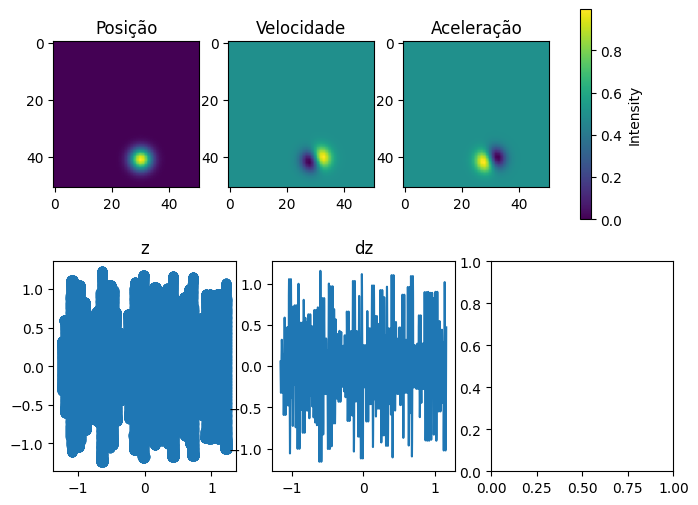

In [3]:
X, dX,ddX,z,dz = training_data['x'], training_data['dx'], training_data['ddx'], training_data['z'], training_data['dz']


fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column

# Plot the first subplot
im1 = axs[0,0].imshow(X[0].reshape(51,51))
axs[0,0].set_title('Posição')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Intensity')
im2 = axs[0,1].imshow(dX[0].reshape(51,51))
axs[0,1].set_title('Velocidade')
im3 = axs[0,2].imshow(ddX[0].reshape(51,51))
axs[0,2].set_title('Aceleração')
axs[1,0].scatter(np.linspace(min(z),max(z),len(z)),z)
axs[1,0].set_title('z')
axs[1,1].plot(np.linspace(min(dz),max(dz),len(dz)),dz)
axs[1,1].set_title('dz')


# Declarando parâmetros


Aqui declaramos alguns inputs que serão passados para o Modelo da rede em Pytorch.  Veja que há muitos outros parâmetros que poderiam ser repassados assim, para redes maiores. Manter os parâmetros como um dicionário separado da rede facilita a interpretação do código e o treinamento em que muitas variações serão testadas. 

In [4]:
params = {}

params['input_dim'] = training_data['x'].shape[-1]
params['latent_dim'] = 1
params['poly_order'] = 3
params['include_sine'] = True
params['learning_rate'] = 1e-4


## Declarando Rede

Diferentemente dos exemplos anteriores, em que declaramos tudo em uma rede só, aqui, para facilitar examinar o espaço latente $\mathbf{z}$ vamos declarar três modelos: Uma rede para o `Encoder()`, outra par ao `Decoder()`, e finalmente uma terceira que chama ambas as redes seccionalmente e aplica as condições para SINDy, aqui `Autoencoder()`, mas veja que as funções de declaração da biblioteca SINDy, parâmetros e máscara de coeficientes, são tomados como métodos.
* Veja como os parâmetros anteriores são aplicados aqui, colocando as funções como `True` as inclui na biblioteca:

``` python
    self.SINDyLibrary = SINDyLibrary(
                device=device,
                latent_dim=latent_dim, # definido nos parâmetros acima
                include_biases=False,
                include_states=True,
                include_sin=params['include_sine'], # definido nos parâmetros acima, aqui True
                include_cos=False,
                include_multiply_pairs=False, #caso para sistemas de mais dimensões como atratores de Lorentz, precisamos multiplicar os polinômios z_1z_2 etc
                poly_order=params['poly_order'], # definido nos parâmetros acima
                include_sqrt=False,
                include_inverse= False,
                include_sign_sqrt_of_diff=False)
            
            # Declaração como métodos dos coeficientes que multiplicam a biblioteca, $\Xi$. 
            self.XI = nn.Parameter(tc.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = tc.float32,requires_grad=True,device = device))
            self.XI_coefficient_mask = tc.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = tc.float32, device=device)
```

* Veja também que, agora, a rede é muito customizada, o que é uma tarefa razoavelmente direta graças à sintaxe do PyTorch e a declaração das redes por classes. O methodo que mais nos interessa aqui é o 

``` python
    def compute_quantities(self,x,xdot,xddot):
        # aplicação do encoder e decoder
        z = self.encoder(x)
        xtilde = self.decoder(z)

        # modelo vigente $z = \Theta \Xi = sindy_predict$
        theta = self.SINDyLibrary.transform(z) 
        scindy_predict = tc.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        # lista de pesos para calcular propagação sobre encoder e $\nabla \varphi$
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]

        # calculo das derivadas para z, d^2/dt^2 z
        zdot , zddot = self.z_derivative_order2(x, xdot, xddot, encoder_weight_list, encoder_biases_list)#, activation='relu')

        # lista de pesos para calcular a propagação sobre o decoder $\nabla \psi$
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]

        # calcula derivadas para d^2/dt^2 x
        xtildedot , xtildeddot = self.z_derivative_order2(z, zdot, scindy_predict, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict
```

* REF: Uma aplicação muito similar somente para a primeira derivada pode ser encontrada em [este post](https://pietro-sillano.github.io/projects/2.SINDY/)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(input_size,256)
        self.fc1 = nn.Linear(256,64)
        self.fc33 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64,16)
        self.fc4 = nn.Linear(16,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = tc.tanh(self.fc0(x))
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc33(x))
        x = tc.relu(self.fc3(x))   
        x = tc.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,16)
        self.fc2 = nn.Linear(16,64)
        self.fc33 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(64,256)
        self.fc5 = nn.Linear(256,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc2(x))
        x = tc.relu(self.fc33(x))   
        x = tc.tanh(self.fc4(x))
        x = tc.sigmoid(self.fc5(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        # importing parameters 
        input_size = params['input_dim']
        latent_dim = params['latent_dim']
        if 'include_sine' in params.keys():
            include_sine = params['include_sine']
        else:
            include_sine = False
        
        # defining network bits
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=params['include_sine'],
            include_cos=False,
            include_multiply_pairs=False, # usado somente para sistemas de mais dimensões, como atratores de Lorentz, ou reação-difusão
            poly_order=params['poly_order'],
            include_sqrt=False,
            include_inverse= False,
            include_sign_sqrt_of_diff=False)
        
        # Declaração como métodos dos coeficientes que multiplicam a biblioteca, $\Xi$. 
        self.XI = nn.Parameter(tc.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = tc.float32,requires_grad=True,device = device))
        self.XI_coefficient_mask = tc.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = tc.float32, device=device)


    def configure_optimizers(self):
        learning_rate = params['learning_rate']
        return tc.optim.Adam(self.parameters(), lr=learning_rate,betas=(0.9, 0.99), amsgrad=True)

    def z_derivative_order2(self, input, dx, ddx, weights, biases, activation='relu'):
        """
        Compute the first and second order time derivatives by propagating through the network.

        Arguments:
            input - 2D PyTorch tensor, input to the network. Dimensions are number of time points
            by number of state variables.
            dx - First order time derivatives of the input to the network.
            ddx - Second order time derivatives of the input to the network.
            weights - List of PyTorch tensors containing the network weights
            biases - List of PyTorch tensors containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu', 'relu', 'sigmoid', or 'linear'.

        Returns:
            dz - PyTorch tensor, first order time derivatives of the network output.
            ddz - PyTorch tensor, second order time derivatives of the network output.
        """
        dz = dx
        ddz = ddx

        for i in range(len(weights)-1):
            input = tc.matmul(input, weights[i].T) + biases[i]
            dz_prev = tc.matmul(dz, weights[i].T)

            if activation == 'elu':
                elu_derivative = tc.where(input < 0, tc.exp(input), tc.tensor(1.0))
                elu_derivative2 = tc.exp(input) * (input < 0).float()
                dz = elu_derivative * dz_prev
                ddz = elu_derivative2 * dz_prev.pow(2) + elu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.elu(input)

            elif activation == 'relu':
                relu_derivative = (input > 0).float()
                dz = relu_derivative * tc.matmul(dz, weights[i].T)
                ddz = relu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.relu(input)

            elif activation == 'sigmoid':
                sigmoid = tc.sigmoid(input)
                sigmoid_derivative = sigmoid * (1 - sigmoid)
                sigmoid_derivative2 = sigmoid_derivative * (1 - 2 * sigmoid)
                dz = sigmoid_derivative * dz_prev
                ddz = sigmoid_derivative2 * dz_prev.pow(2) + sigmoid_derivative * tc.matmul(ddz, weights[i].T)

            else:  # Linear activation
                dz = tc.matmul(dz, weights[i].T)
                ddz = tc.matmul(ddz, weights[i].T)

        # Final layer without activation
        dz = tc.matmul(dz, weights[-1].T) + biases[-1]
        ddz = tc.matmul(ddz, weights[-1].T) + biases[-1]

        return dz, ddz
    
    def compute_quantities(self,x,xdot,xddot):
        # aplicação do encoder e decoder
        z = self.encoder(x)
        xtilde = self.decoder(z)

        # modelo vigente $z = \Theta \Xi = sindy_predict$
        theta = self.SINDyLibrary.transform(z) 
        scindy_predict = tc.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        # lista de pesos para calcular propagação sobre encoder e $\nabla \varphi$
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]

        # calculo das derivadas para z, d^2/dt^2 z
        zdot , zddot = self.z_derivative_order2(x, xdot, xddot, encoder_weight_list, encoder_biases_list)#, activation='relu')

        # lista de pesos para calcular a propagação sobre o decoder $\nabla \psi$
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]

        # calcula derivadas para d^2/dt^2 x
        xtildedot , xtildeddot = self.z_derivative_order2(z, zdot, scindy_predict, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict

    def loss_function(self, x, xdot, xddot, xtilde, xtildedot, xtildeddot, zdot, zddot, scindy_predict,XI):
        '''toma entradas e saidas e devolve todas as loss functions em um dicionário '''
        mse = nn.MSELoss()
        # estes valores são usados na soma das loss functions, poderiam ser parâmetros externos
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5

        # declaração das loss functions
        loss = {}
        loss['recon_loss'] = mse(x, xtilde) # Loss de reconstrução da imagem da posição
        #loss ['sindy_loss_x'] = mse(xdot, xtildedot) # Loss para dinamicas com derivadas de de ordem 1 (não é usado aqui) 
        loss ['sindy_loss_z'] = mse(zddot, scindy_predict) # Loss da derivada em z, dz/dt 
        loss ['sindy_loss_ddx'] = mse(xddot,xtildeddot) # loss da derivada em $\tilde{\ddot{x}}$,i.e., da imagem da aceleração com a aceleração do modelo
        loss['sindy_regular_loss'] = tc.sum(tc.abs(XI)) #norma L1 dos coeficientes XI

        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_ddx'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        
        # tentativa de incluir a primeira derivada também, a performance é melhor
        #loss['tot'] = loss['recon_loss'] + alpha1*(loss['sindy_loss_ddx'] + loss['sindy_loss_x']) + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        
        tot = loss['tot']
        return tot, loss
    
    
    def forward(self, x, xdot, xddot):
        return self.compute_quantities(x, xdot, xddot)

#### Inicializando e salvando o modelo na memória

In [6]:
model = Autoencoder(params).to(device)

Encoder(
  (fc0): Linear(in_features=2601, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc33): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)
Linear(in_features=2601, out_features=256, bias=True)
Linear(in_features=256, out_features=64, bias=True)
Dropout(p=0.25, inplace=False)
Linear(in_features=64, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)


#### Verificando quais funções estão na biblioteca e serão usadas no modelo
i.e., estamos basicamente printando $\Theta$

In [7]:
model.SINDyLibrary.feature_names

['z0', 'sin(z0)', 'z0*z0', 'z0*z0*z0']

## Examinando os dados de treinamento
* Nossos dados são imagens, mas como não vamos usar CNN, eles estarão declarados como um vetor, i.e., usamos o método .flatten() do numpy para "achatar" a matriz da imagem (tamanho 51x51) em um vetor (tamanho 1x2601)

In [8]:
X[1]

array([1.98211338e-81, 1.43588348e-79, 9.00682031e-78, ...,
       3.19395947e-13, 2.30396908e-14, 1.43908182e-15])

* Convertendo os arrays de numpy para tensores de Pytorch

In [9]:
X = tc.from_numpy(X).float().to(device)
dX = tc.from_numpy(dX).float().to(device)
ddX = tc.from_numpy(ddX).float().to(device)
z = tc.from_numpy(z).float().to(device)
dz = tc.from_numpy(dz).float().to(device)


X.shape, dX.shape, X.dtype

(torch.Size([30000, 2601]), torch.Size([30000, 2601]), torch.float32)

In [10]:
X[1], dX[1], ddX[1], z[1], dz[1]

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.1940e-13, 2.3040e-14,
         1.4391e-15], device='cuda:0'),
 tensor([-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., 5.4753e-13, 4.2180e-14,
         2.8022e-15], device='cuda:0'),
 tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.4914e-12,
         -1.8676e-13, -1.2066e-14], device='cuda:0'),
 tensor([0.3199], device='cuda:0'),
 tensor([0.0511], device='cuda:0'))

## Escolhendo dados de validação, mesmo procedimento

In [11]:
X_val = tc.from_numpy(validation_data['x']).float().to(device)
dX_val = tc.from_numpy(validation_data['dx']).float().to(device)
ddX_val = tc.from_numpy(validation_data['ddx']).float().to(device)
z_val = tc.from_numpy(validation_data['z']).float().to(device)
dz_val = tc.from_numpy(validation_data['dz']).float().to(device)


In [12]:
train_size, val_size = X.shape[0], X_val.shape[0]
batch_size =  320
dataset = TensorDataset(X,dX,ddX)
validation_set = TensorDataset(X_val,dX_val,ddX_val)

train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(validation_set, shuffle=False, batch_size=batch_size)

# Treinamento

* Aqui vamos declarar algumas funções para que possamos ter prints mais intuitivos, além de também salvar nosso modelo encontrado e a loss function a cada numero de epochs
* também nessa célula declaramos o corte de coeficientes $\xi$ que estão abaixo do nosso threshold $0.1$, na função `sequencial_threshold()`

In [13]:
def save_model(t,exp):
    
    '''saves model '''
    
    if SAVE == True:
    
        print('saved in ',t,"epoche")
        f1 = './saved_models/' + 'best_model' + '.pt'
        tc.save({
        'epoch': t,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model.configure_optimizers().state_dict(),
        'loss': model.loss_function,
        'sindy_coefficients': model.XI,
        'coefficient_mask' : model.XI_coefficient_mask
        }, f1)
        
def print_model(t,exp):
    
    ''' prints model into a .txt file'''

    f = open(path + 'model'+str(exp)+'_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    latent_dim = params['latent_dim']
    for j in range(latent_dim):
        k=0
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]      
            if  abs(coeff) >= 0.1 and coeff != 0:
                if k<1:
                    f.write(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                else:
                    f.write(f"+ {coeff:.6f} {feature_list[i]}")
                k+=1
    f.close()

def sequential_threshold(epoch, seq_thres):

    ''' decides when to delete small coefficientes in XI'''
    
    if (epoch % seq_thres == 0 and epoch>1):
        print('Sequencial threshold, deleting coefficients below 0.1..')
        model.XI_coefficient_mask = tc.abs(model.XI) > 0.1

#training step for one epoch
def train_step(loss_list):

    ''' does one training epoch'''    

    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    #loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_ddx'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, (X,Xdot,Xddot) in enumerate (train_loader):
        X.to(device) # para passar para a gpu
        Xdot.to(device)
        Xddot.to(device)
        
        #forward pass 
        xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict = model(X,Xdot, Xddot)

        # Backpropagation
        optimizer = model.configure_optimizers()

        # calcula valores da loss
        loss, loss_dict = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        # salva loss encontradas no dicionario
        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))

    # deleta variáveis para liberar memória            
    del loss_epoch,loss_dict,xtilde, xtildedot,xtildeddot, z, zdot, zddot, scindy_predict,loss

def validation_step(loss_val_list):

    ''' calculates loss for validation data'''
    
    loss_val_epoch = []
    model.eval()     # Optional when not using Model Specific layer
    for batch, (X,Xdot, Xddot) in enumerate (val_loader):
        X.to(device) 
        Xdot.to(device)
        Xddot.to(device)

        #forward pass 
        xtilde, xtildedot, xtildeddot, z, zdot, zddot,scindy_predict = model(X,Xdot, Xddot)
        
        # validation loss 
        loss, _ = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss_val_epoch.append(loss.item())

        del  xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict,loss

    loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

def print_loss(t,loss_rate, loss_list):
    ''' simple prints of the Epochs to keep track of training'''
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

In [14]:
def plot_validation_comparison(epoch, val_rate):
    
    '''Plots a Matplotlib comparing x,xdot,xddot, to found xtilde,xtildedot xtildeddot in validation data-set - also states the current found model'''
    
    if epoch % val_rate == 0 and epoch>1:
        X_p, dX_p,ddX_p= validation_data['x'], validation_data['dx'], validation_data['ddx']

        X_pred, dX_pred, ddX_pred, _, _, _,scindy_predict = model(X_val,dX_val, ddX_val)
        X_pred = X_pred.cpu().detach().numpy()
        dX_pred = dX_pred.cpu().detach().numpy()
        ddX_pred = ddX_pred.cpu().detach().numpy()

        print('\n Model is now:')
        coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
        XI = model.XI.cpu().detach().numpy()
        feature_list = model.SINDyLibrary.get_feature_names()
        latent_dim = params['latent_dim']

        for j in range(latent_dim):
            k=0
            for i in range(len(feature_list)-1):
                coeff = XI[i][j] * coefficient_mask[i][j]      
                if  abs(coeff) >= 0.1 and coeff != 0:
                    if k<1:
                        print(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                    else:
                        print(f"+ {coeff:.6f} {feature_list[i]}")
                    k+=1

        fig, axs = plt.subplots(2, 3, figsize=(10, 8))
        plt.rcParams.update({'font.size': 18})

        # # Set consistent colorbar ranges
        # vmin_x = min(X_p[0].min(), X_pred[0].min())
        # vmax_x = max(X_p[0].max(), X_pred[0].max())
        
        # vmin_dx = min(dX_p[0].min(), dX_pred[0].min())
        # vmax_dx = max(dX_p[0].max(), dX_pred[0].max())
        
        # vmin_ddx = min(ddX_p[0].min(), ddX_pred[0].min())
        # vmax_ddx = max(ddX_p[0].max(), ddX_pred[0].max())

        # # Plot original data
        # im1 = axs[0,0].imshow(X_p[0].reshape(51,51), vmin=vmin_x, vmax=vmax_x)
        # axs[0,0].set_title('Posição Original')
        
        # im2 = axs[0,1].imshow(dX_p[0].reshape(51,51), vmin=vmin_dx, vmax=vmax_dx)
        # axs[0,1].set_title('Velocidade Original')
        
        # im3 = axs[0,2].imshow(ddX_p[0].reshape(51,51), vmin=vmin_ddx, vmax=vmax_ddx)
        # axs[0,2].set_title('Aceleração Original')

        # # Plot predicted data
        # im4 = axs[1,0].imshow(X_pred[0].reshape(51,51), vmin=vmin_x, vmax=vmax_x)
        # axs[1,0].set_title('Posição Prevista')
        
        # im5 = axs[1,1].imshow(dX_pred[0].reshape(51,51), vmin=vmin_dx, vmax=vmax_dx)
        # axs[1,1].set_title('Velocidade Prevista')
        
        # im6 = axs[1,2].imshow(ddX_pred[0].reshape(51,51), vmin=vmin_ddx, vmax=vmax_ddx)
        # axs[1,2].set_title('Aceleração Prevista')

        # # Add single colorbar
        # cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
        # fig.colorbar(im1, cax=cbar_ax)

        # plt.tight_layout()
        # plt.show()

### Declarando parâmetros de treino para as funções acima

In [15]:
VALIDATION = True
SAVE = True 

epochs = 300
#path = '../model/'

#path = './saved_models/'
seq_thres = 100   # Numero de epochs apos o qual aplicamos o threshold sequencial

equation_rate = 1 # print das equações encontradas em um arquivo .txt

loss_rate = equation_rate  # print no terminal dos valores das loss até entao

# print dos plots comparando x,xdot,xddot, e os encontrados xtilde,xtildedot xtildeddot no validation data-set 
# Também printa o modelo sindy encontrado
val_print_rate = equation_rate 


Encoder(
  (fc0): Linear(in_features=2601, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc33): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)
Linear(in_features=2601, out_features=256, bias=True)
Linear(in_features=256, out_features=64, bias=True)
Dropout(p=0.25, inplace=False)
Linear(in_features=64, out_features=16, bias=True)
Linear(in_features=16, out_features=1, bias=True)
--------------------------------------------------


  0%|          | 1/299 [00:02<13:02,  2.63s/it]

saved in  1 epoche


  1%|          | 2/299 [00:04<10:00,  2.02s/it]

saved in  2 epoche

 Model is now:
ddz0 = 0.981199 z0
+ 1.016603 sin(z0)
+ 0.981200 z0*z0


  1%|          | 3/299 [00:05<08:47,  1.78s/it]

saved in  3 epoche

 Model is now:
ddz0 = 0.971797 z0
+ 1.026005 sin(z0)
+ 0.971798 z0*z0


  1%|▏         | 4/299 [00:07<08:09,  1.66s/it]

saved in  4 epoche

 Model is now:
ddz0 = 0.962395 z0
+ 1.035407 sin(z0)
+ 0.962399 z0*z0


  2%|▏         | 5/299 [00:08<07:50,  1.60s/it]

saved in  5 epoche

 Model is now:
ddz0 = 0.952994 z0
+ 1.044808 sin(z0)
+ 0.953003 z0*z0


  2%|▏         | 6/299 [00:10<08:01,  1.64s/it]

saved in  6 epoche

 Model is now:
ddz0 = 0.943592 z0
+ 1.054210 sin(z0)
+ 0.943607 z0*z0


  2%|▏         | 7/299 [00:11<07:49,  1.61s/it]

saved in  7 epoche

 Model is now:
ddz0 = 0.934191 z0
+ 1.063611 sin(z0)
+ 0.934206 z0*z0


  3%|▎         | 8/299 [00:13<07:33,  1.56s/it]

saved in  8 epoche

 Model is now:
ddz0 = 0.924789 z0
+ 1.073013 sin(z0)
+ 0.924804 z0*z0


  3%|▎         | 9/299 [00:15<07:37,  1.58s/it]

saved in  9 epoche

 Model is now:
ddz0 = 0.915388 z0
+ 1.082414 sin(z0)
+ 0.915404 z0*z0


  3%|▎         | 10/299 [00:16<07:29,  1.56s/it]

saved in  10 epoche

 Model is now:
ddz0 = 0.905986 z0
+ 1.091816 sin(z0)
+ 0.906004 z0*z0


  4%|▎         | 11/299 [00:18<07:30,  1.56s/it]

saved in  11 epoche

 Model is now:
ddz0 = 0.896585 z0
+ 1.101218 sin(z0)
+ 0.896605 z0*z0


  4%|▍         | 12/299 [00:19<07:31,  1.57s/it]

saved in  12 epoche

 Model is now:
ddz0 = 0.887183 z0
+ 1.110619 sin(z0)
+ 0.887208 z0*z0


  4%|▍         | 13/299 [00:21<07:40,  1.61s/it]

saved in  13 epoche

 Model is now:
ddz0 = 0.877781 z0
+ 1.120021 sin(z0)
+ 0.877812 z0*z0


  5%|▍         | 14/299 [00:22<07:25,  1.56s/it]

saved in  14 epoche

 Model is now:
ddz0 = 0.868380 z0
+ 1.129422 sin(z0)
+ 0.868416 z0*z0


  5%|▌         | 15/299 [00:24<07:12,  1.52s/it]

saved in  15 epoche

 Model is now:
ddz0 = 0.858979 z0
+ 1.138824 sin(z0)
+ 0.859020 z0*z0


  5%|▌         | 16/299 [00:25<07:07,  1.51s/it]

saved in  16 epoche

 Model is now:
ddz0 = 0.849577 z0
+ 1.148225 sin(z0)
+ 0.849623 z0*z0


  6%|▌         | 17/299 [00:27<07:13,  1.54s/it]

saved in  17 epoche

 Model is now:
ddz0 = 0.840176 z0
+ 1.157627 sin(z0)
+ 0.840227 z0*z0


  6%|▌         | 18/299 [00:28<07:06,  1.52s/it]

saved in  18 epoche

 Model is now:
ddz0 = 0.830775 z0
+ 1.167028 sin(z0)
+ 0.830830 z0*z0


  6%|▋         | 19/299 [00:30<07:04,  1.52s/it]

saved in  19 epoche

 Model is now:
ddz0 = 0.821374 z0
+ 1.176430 sin(z0)
+ 0.821432 z0*z0


  7%|▋         | 20/299 [00:31<07:01,  1.51s/it]

saved in  20 epoche

 Model is now:
ddz0 = 0.811974 z0
+ 1.185831 sin(z0)
+ 0.812033 z0*z0


  7%|▋         | 21/299 [00:33<06:56,  1.50s/it]

saved in  21 epoche

 Model is now:
ddz0 = 0.802574 z0
+ 1.195233 sin(z0)
+ 0.802634 z0*z0


C:\Users\gubio\AppData\Local\Temp\ipykernel_4064\3165330700.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 3, figsize=(10, 8))
  7%|▋         | 22/299 [00:34<07:01,  1.52s/it]

saved in  22 epoche

 Model is now:
ddz0 = 0.793175 z0
+ 1.204431 sin(z0)
+ 0.793235 z0*z0


  8%|▊         | 23/299 [00:36<06:58,  1.52s/it]

saved in  23 epoche

 Model is now:
ddz0 = 0.783776 z0
+ 1.213626 sin(z0)
+ 0.783836 z0*z0


  8%|▊         | 24/299 [00:37<06:53,  1.50s/it]

saved in  24 epoche

 Model is now:
ddz0 = 0.774578 z0
+ 1.220443 sin(z0)
+ 0.774438 z0*z0


  8%|▊         | 25/299 [00:39<06:51,  1.50s/it]

saved in  25 epoche

 Model is now:
ddz0 = 0.766772 z0
+ 1.225452 sin(z0)
+ 0.765040 z0*z0


  9%|▊         | 26/299 [00:41<07:04,  1.56s/it]

saved in  26 epoche

 Model is now:
ddz0 = 0.759791 z0
+ 1.226458 sin(z0)
+ 0.755642 z0*z0


  9%|▉         | 27/299 [00:42<06:55,  1.53s/it]

saved in  27 epoche

 Model is now:
ddz0 = 0.755189 z0
+ 1.226454 sin(z0)
+ 0.746245 z0*z0


  9%|▉         | 28/299 [00:43<06:48,  1.51s/it]

saved in  28 epoche

 Model is now:
ddz0 = 0.750829 z0
+ 1.225056 sin(z0)
+ 0.736847 z0*z0


 10%|▉         | 29/299 [00:45<06:45,  1.50s/it]

saved in  29 epoche

 Model is now:
ddz0 = 0.747426 z0
+ 1.223669 sin(z0)
+ 0.727449 z0*z0


 10%|█         | 30/299 [00:46<06:41,  1.49s/it]

saved in  30 epoche

 Model is now:
ddz0 = 0.743828 z0
+ 1.219662 sin(z0)
+ 0.718052 z0*z0


 10%|█         | 31/299 [00:48<06:47,  1.52s/it]

saved in  31 epoche

 Model is now:
ddz0 = 0.739633 z0
+ 1.216861 sin(z0)
+ 0.708655 z0*z0


 11%|█         | 32/299 [00:50<07:08,  1.61s/it]

saved in  32 epoche

 Model is now:
ddz0 = 0.737831 z0
+ 1.213456 sin(z0)
+ 0.699257 z0*z0


 11%|█         | 33/299 [00:51<07:07,  1.61s/it]

saved in  33 epoche

 Model is now:
ddz0 = 0.735831 z0
+ 1.210006 sin(z0)
+ 0.689860 z0*z0


 11%|█▏        | 34/299 [00:53<06:56,  1.57s/it]

saved in  34 epoche

 Model is now:
ddz0 = 0.731841 z0
+ 1.207408 sin(z0)
+ 0.680463 z0*z0


 12%|█▏        | 35/299 [00:54<06:48,  1.55s/it]

saved in  35 epoche

 Model is now:
ddz0 = 0.731039 z0
+ 1.202208 sin(z0)
+ 0.671066 z0*z0
saved in  36 epoche

 Model is now:
ddz0 = 0.728640 z0
+ 1.198209 sin(z0)
+ 0.661668 z0*z0


 12%|█▏        | 37/299 [00:58<06:52,  1.57s/it]

saved in  37 epoche

 Model is now:
ddz0 = 0.727040 z0
+ 1.194011 sin(z0)
+ 0.652271 z0*z0


 13%|█▎        | 38/299 [00:59<06:42,  1.54s/it]

saved in  38 epoche

 Model is now:
ddz0 = 0.727638 z0
+ 1.189408 sin(z0)
+ 0.642874 z0*z0


 13%|█▎        | 39/299 [01:01<06:37,  1.53s/it]

saved in  39 epoche

 Model is now:
ddz0 = 0.728836 z0
+ 1.183608 sin(z0)
+ 0.633477 z0*z0


 13%|█▎        | 40/299 [01:02<06:39,  1.54s/it]

saved in  40 epoche

 Model is now:
ddz0 = 0.725438 z0
+ 1.180207 sin(z0)
+ 0.624079 z0*z0


 14%|█▎        | 41/299 [01:04<06:37,  1.54s/it]

saved in  41 epoche

 Model is now:
ddz0 = 0.724835 z0
+ 1.176201 sin(z0)
+ 0.614683 z0*z0


 14%|█▍        | 42/299 [01:05<06:33,  1.53s/it]

saved in  42 epoche

 Model is now:
ddz0 = 0.722034 z0
+ 1.172999 sin(z0)
+ 0.605286 z0*z0
saved in  43 epoche

 Model is now:
ddz0 = 0.720236 z0
+ 1.168618 sin(z0)
+ 0.595889 z0*z0


 15%|█▍        | 44/299 [01:08<06:38,  1.56s/it]

saved in  44 epoche

 Model is now:
ddz0 = 0.718246 z0
+ 1.164219 sin(z0)
+ 0.586492 z0*z0


 15%|█▌        | 45/299 [01:10<06:41,  1.58s/it]

saved in  45 epoche

 Model is now:
ddz0 = 0.716233 z0
+ 1.159222 sin(z0)
+ 0.577095 z0*z0


 15%|█▌        | 46/299 [01:12<06:38,  1.58s/it]

saved in  46 epoche

 Model is now:
ddz0 = 0.714431 z0
+ 1.155981 sin(z0)
+ 0.567699 z0*z0


 16%|█▌        | 47/299 [01:13<06:33,  1.56s/it]

saved in  47 epoche

 Model is now:
ddz0 = 0.713432 z0
+ 1.150584 sin(z0)
+ 0.558303 z0*z0


 16%|█▌        | 48/299 [01:15<06:26,  1.54s/it]

saved in  48 epoche

 Model is now:
ddz0 = 0.708832 z0
+ 1.147789 sin(z0)
+ 0.548906 z0*z0


 16%|█▋        | 49/299 [01:16<06:37,  1.59s/it]

saved in  49 epoche

 Model is now:
ddz0 = 0.706633 z0
+ 1.143787 sin(z0)
+ 0.539510 z0*z0


 17%|█▋        | 50/299 [01:18<06:26,  1.55s/it]

saved in  50 epoche

 Model is now:
ddz0 = 0.705035 z0
+ 1.139587 sin(z0)
+ 0.530113 z0*z0


 17%|█▋        | 51/299 [01:19<06:18,  1.52s/it]

saved in  51 epoche

 Model is now:
ddz0 = 0.702639 z0
+ 1.135785 sin(z0)
+ 0.520717 z0*z0


 17%|█▋        | 52/299 [01:21<06:13,  1.51s/it]

saved in  52 epoche

 Model is now:
ddz0 = 0.697832 z0
+ 1.134777 sin(z0)
+ 0.511321 z0*z0


 18%|█▊        | 53/299 [01:22<06:10,  1.51s/it]

saved in  53 epoche

 Model is now:
ddz0 = 0.694444 z0
+ 1.131379 sin(z0)
+ 0.501925 z0*z0


 18%|█▊        | 54/299 [01:24<06:09,  1.51s/it]

saved in  54 epoche

 Model is now:
ddz0 = 0.691438 z0
+ 1.128373 sin(z0)
+ 0.492528 z0*z0


 19%|█▊        | 56/299 [01:27<05:56,  1.47s/it]

saved in  56 epoche

 Model is now:
ddz0 = 0.685040 z0
+ 1.121773 sin(z0)
+ 0.473933 z0*z0


 19%|█▉        | 57/299 [01:28<05:54,  1.47s/it]

saved in  57 epoche

 Model is now:
ddz0 = 0.683055 z0
+ 1.117975 sin(z0)
+ 0.464735 z0*z0


 19%|█▉        | 58/299 [01:30<06:12,  1.54s/it]

saved in  58 epoche

 Model is now:
ddz0 = 0.679454 z0
+ 1.116158 sin(z0)
+ 0.455340 z0*z0


 20%|█▉        | 59/299 [01:31<06:06,  1.53s/it]

saved in  59 epoche

 Model is now:
ddz0 = 0.677452 z0
+ 1.113956 sin(z0)
+ 0.446144 z0*z0


 20%|██        | 60/299 [01:33<06:04,  1.53s/it]

saved in  60 epoche

 Model is now:
ddz0 = 0.674655 z0
+ 1.110363 sin(z0)
+ 0.436746 z0*z0


 20%|██        | 61/299 [01:34<05:58,  1.51s/it]

saved in  61 epoche

 Model is now:
ddz0 = 0.671265 z0
+ 1.107968 sin(z0)
+ 0.427550 z0*z0


 21%|██        | 62/299 [01:36<05:55,  1.50s/it]

saved in  62 epoche

 Model is now:
ddz0 = 0.668864 z0
+ 1.107151 sin(z0)
+ 0.418352 z0*z0


 21%|██        | 63/299 [01:37<05:55,  1.51s/it]

saved in  63 epoche

 Model is now:
ddz0 = 0.666065 z0
+ 1.105550 sin(z0)
+ 0.409755 z0*z0


 21%|██▏       | 64/299 [01:39<06:07,  1.56s/it]

saved in  64 epoche

 Model is now:
ddz0 = 0.664260 z0
+ 1.103141 sin(z0)
+ 0.401117 z0*z0


 22%|██▏       | 66/299 [01:42<05:49,  1.50s/it]

saved in  66 epoche

 Model is now:
ddz0 = 0.657664 z0
+ 1.099343 sin(z0)
+ 0.382730 z0*z0


 22%|██▏       | 67/299 [01:43<05:46,  1.49s/it]

saved in  67 epoche

 Model is now:
ddz0 = 0.654488 z0
+ 1.098140 sin(z0)
+ 0.373740 z0*z0


 23%|██▎       | 68/299 [01:45<05:43,  1.49s/it]

saved in  68 epoche

 Model is now:
ddz0 = 0.650693 z0
+ 1.096338 sin(z0)
+ 0.364744 z0*z0


 23%|██▎       | 69/299 [01:46<05:42,  1.49s/it]

saved in  69 epoche

 Model is now:
ddz0 = 0.648895 z0
+ 1.094736 sin(z0)
+ 0.358146 z0*z0


 23%|██▎       | 70/299 [01:48<05:42,  1.50s/it]

saved in  70 epoche

 Model is now:
ddz0 = 0.646284 z0
+ 1.093736 sin(z0)
+ 0.351144 z0*z0


 24%|██▍       | 72/299 [01:51<05:36,  1.48s/it]

saved in  72 epoche

 Model is now:
ddz0 = 0.640312 z0
+ 1.090730 sin(z0)
+ 0.338151 z0*z0


 24%|██▍       | 73/299 [01:52<05:33,  1.47s/it]

saved in  73 epoche

 Model is now:
ddz0 = 0.637113 z0
+ 1.088135 sin(z0)
+ 0.331356 z0*z0


 26%|██▌       | 77/299 [01:58<05:35,  1.51s/it]

saved in  77 epoche

 Model is now:
ddz0 = 0.621515 z0
+ 1.085514 sin(z0)
+ 0.306352 z0*z0


 26%|██▋       | 79/299 [02:01<05:31,  1.50s/it]

saved in  79 epoche

 Model is now:
ddz0 = 0.615916 z0
+ 1.083688 sin(z0)
+ 0.296751 z0*z0


 27%|██▋       | 80/299 [02:03<05:28,  1.50s/it]

saved in  80 epoche

 Model is now:
ddz0 = 0.611117 z0
+ 1.085086 sin(z0)
+ 0.291160 z0*z0


 27%|██▋       | 81/299 [02:04<05:25,  1.49s/it]

saved in  81 epoche

 Model is now:
ddz0 = 0.607925 z0
+ 1.084079 sin(z0)
+ 0.286371 z0*z0


 27%|██▋       | 82/299 [02:06<05:22,  1.49s/it]

saved in  82 epoche

 Model is now:
ddz0 = 0.603719 z0
+ 1.083894 sin(z0)
+ 0.281973 z0*z0


 28%|██▊       | 83/299 [02:07<05:38,  1.57s/it]

saved in  83 epoche

 Model is now:
ddz0 = 0.599519 z0
+ 1.083894 sin(z0)
+ 0.277582 z0*z0


 29%|██▉       | 86/299 [02:12<05:10,  1.46s/it]

saved in  86 epoche

 Model is now:
ddz0 = 0.588129 z0
+ 1.084083 sin(z0)
+ 0.270949 z0*z0


 29%|██▉       | 87/299 [02:13<05:10,  1.46s/it]

saved in  87 epoche

 Model is now:
ddz0 = 0.583326 z0
+ 1.084883 sin(z0)
+ 0.267956 z0*z0


 29%|██▉       | 88/299 [02:15<05:11,  1.48s/it]

saved in  88 epoche

 Model is now:
ddz0 = 0.579930 z0
+ 1.085081 sin(z0)
+ 0.265957 z0*z0


 30%|███       | 90/299 [02:17<05:03,  1.45s/it]

saved in  90 epoche

 Model is now:
ddz0 = 0.570966 z0
+ 1.086284 sin(z0)
+ 0.262351 z0*z0


 30%|███       | 91/299 [02:19<05:05,  1.47s/it]

saved in  91 epoche

 Model is now:
ddz0 = 0.567167 z0
+ 1.086882 sin(z0)
+ 0.261153 z0*z0


 31%|███       | 92/299 [02:20<05:02,  1.46s/it]

saved in  92 epoche

 Model is now:
ddz0 = 0.563168 z0
+ 1.087644 sin(z0)
+ 0.258544 z0*z0


 31%|███▏      | 94/299 [02:23<04:56,  1.45s/it]

saved in  94 epoche

 Model is now:
ddz0 = 0.553972 z0
+ 1.088237 sin(z0)
+ 0.255938 z0*z0
saved in  95 epoche

 Model is now:
ddz0 = 0.549349 z0
+ 1.090751 sin(z0)
+ 0.253344 z0*z0


 33%|███▎      | 98/299 [02:29<04:51,  1.45s/it]

saved in  98 epoche

 Model is now:
ddz0 = 0.537157 z0
+ 1.094774 sin(z0)
+ 0.248366 z0*z0


 33%|███▎      | 99/299 [02:31<04:52,  1.46s/it]

saved in  99 epoche

 Model is now:
ddz0 = 0.532557 z0
+ 1.095575 sin(z0)
+ 0.247361 z0*z0


 34%|███▍      | 102/299 [02:35<04:45,  1.45s/it]

saved in  102 epoche

 Model is now:
ddz0 = 0.519150 z0
+ 1.100375 sin(z0)
+ 0.244159 z0*z0


 35%|███▌      | 106/299 [02:41<04:51,  1.51s/it]

saved in  106 epoche

 Model is now:
ddz0 = 0.503756 z0
+ 1.103158 sin(z0)
+ 0.245765 z0*z0


 36%|███▌      | 107/299 [02:42<04:49,  1.51s/it]

saved in  107 epoche

 Model is now:
ddz0 = 0.498971 z0
+ 1.104956 sin(z0)
+ 0.244964 z0*z0


 39%|███▉      | 116/299 [02:55<04:25,  1.45s/it]

saved in  116 epoche

 Model is now:
ddz0 = 0.466387 z0
+ 1.109939 sin(z0)
+ 0.244385 z0*z0


 39%|███▉      | 117/299 [02:56<04:28,  1.48s/it]

saved in  117 epoche

 Model is now:
ddz0 = 0.462590 z0
+ 1.111141 sin(z0)
+ 0.244784 z0*z0


 40%|████      | 120/299 [03:01<04:16,  1.43s/it]

saved in  120 epoche

 Model is now:
ddz0 = 0.447584 z0
+ 1.118134 sin(z0)
+ 0.242383 z0*z0


 40%|████      | 121/299 [03:02<04:18,  1.45s/it]

saved in  121 epoche

 Model is now:
ddz0 = 0.442786 z0
+ 1.119136 sin(z0)
+ 0.242387 z0*z0


 41%|████      | 122/299 [03:04<04:36,  1.56s/it]

saved in  122 epoche

 Model is now:
ddz0 = 0.438186 z0
+ 1.120742 sin(z0)
+ 0.241187 z0*z0


 41%|████      | 123/299 [03:05<04:34,  1.56s/it]

saved in  123 epoche

 Model is now:
ddz0 = 0.433173 z0
+ 1.123128 sin(z0)
+ 0.240388 z0*z0


 41%|████▏     | 124/299 [03:07<04:35,  1.57s/it]

saved in  124 epoche

 Model is now:
ddz0 = 0.429374 z0
+ 1.125526 sin(z0)
+ 0.240187 z0*z0


 42%|████▏     | 126/299 [03:10<04:18,  1.50s/it]

saved in  126 epoche

 Model is now:
ddz0 = 0.421569 z0
+ 1.128325 sin(z0)
+ 0.240779 z0*z0


 44%|████▍     | 131/299 [03:17<04:01,  1.43s/it]

saved in  131 epoche

 Model is now:
ddz0 = 0.403564 z0
+ 1.134301 sin(z0)
+ 0.240552 z0*z0


 44%|████▍     | 133/299 [03:20<04:09,  1.50s/it]

saved in  133 epoche

 Model is now:
ddz0 = 0.394169 z0
+ 1.138109 sin(z0)
+ 0.238753 z0*z0


 45%|████▍     | 134/299 [03:22<04:08,  1.50s/it]

saved in  134 epoche

 Model is now:
ddz0 = 0.388171 z0
+ 1.140903 sin(z0)
+ 0.237754 z0*z0


 45%|████▌     | 136/299 [03:24<03:58,  1.47s/it]

saved in  136 epoche

 Model is now:
ddz0 = 0.379374 z0
+ 1.144729 sin(z0)
+ 0.236163 z0*z0


 46%|████▌     | 137/299 [03:26<03:57,  1.47s/it]

saved in  137 epoche

 Model is now:
ddz0 = 0.374176 z0
+ 1.146535 sin(z0)
+ 0.235562 z0*z0


 46%|████▋     | 139/299 [03:29<03:54,  1.47s/it]

saved in  139 epoche

 Model is now:
ddz0 = 0.365545 z0
+ 1.149943 sin(z0)
+ 0.235358 z0*z0


 47%|████▋     | 140/299 [03:30<03:53,  1.47s/it]

saved in  140 epoche

 Model is now:
ddz0 = 0.362140 z0
+ 1.151543 sin(z0)
+ 0.233957 z0*z0


 47%|████▋     | 142/299 [03:33<03:46,  1.44s/it]

saved in  142 epoche

 Model is now:
ddz0 = 0.353344 z0
+ 1.154747 sin(z0)
+ 0.233544 z0*z0


 48%|████▊     | 143/299 [03:35<03:47,  1.46s/it]

saved in  143 epoche

 Model is now:
ddz0 = 0.348492 z0
+ 1.156366 sin(z0)
+ 0.233535 z0*z0


 49%|████▉     | 146/299 [03:39<03:39,  1.43s/it]

saved in  146 epoche

 Model is now:
ddz0 = 0.337499 z0
+ 1.159754 sin(z0)
+ 0.232335 z0*z0
saved in  147 epoche

 Model is now:
ddz0 = 0.333491 z0
+ 1.161354 sin(z0)
+ 0.230343 z0*z0


 49%|████▉     | 148/299 [03:42<03:49,  1.52s/it]

saved in  148 epoche

 Model is now:
ddz0 = 0.330691 z0
+ 1.161555 sin(z0)
+ 0.229742 z0*z0


 50%|█████     | 150/299 [03:45<03:41,  1.49s/it]

saved in  150 epoche

 Model is now:
ddz0 = 0.324888 z0
+ 1.162557 sin(z0)
+ 0.228519 z0*z0


 54%|█████▍    | 162/299 [04:02<03:19,  1.46s/it]

saved in  162 epoche

 Model is now:
ddz0 = 0.292280 z0
+ 1.155728 sin(z0)
+ 0.216760 z0*z0


 58%|█████▊    | 172/299 [04:15<02:55,  1.38s/it]

saved in  172 epoche

 Model is now:
ddz0 = 0.270111 z0
+ 1.141704 sin(z0)
+ 0.208065 z0*z0


 58%|█████▊    | 173/299 [04:17<02:59,  1.42s/it]

saved in  173 epoche

 Model is now:
ddz0 = 0.266315 z0
+ 1.142326 sin(z0)
+ 0.206244 z0*z0


 58%|█████▊    | 174/299 [04:18<02:59,  1.44s/it]

saved in  174 epoche

 Model is now:
ddz0 = 0.262918 z0
+ 1.142123 sin(z0)
+ 0.205244 z0*z0


 59%|█████▊    | 175/299 [04:20<02:59,  1.45s/it]

saved in  175 epoche

 Model is now:
ddz0 = 0.261517 z0
+ 1.141320 sin(z0)
+ 0.205230 z0*z0


 59%|█████▉    | 176/299 [04:21<02:59,  1.46s/it]

saved in  176 epoche

 Model is now:
ddz0 = 0.258516 z0
+ 1.141895 sin(z0)
+ 0.204424 z0*z0


 59%|█████▉    | 177/299 [04:23<02:59,  1.47s/it]

saved in  177 epoche

 Model is now:
ddz0 = 0.254918 z0
+ 1.141702 sin(z0)
+ 0.202021 z0*z0


 60%|█████▉    | 179/299 [04:26<03:04,  1.53s/it]

saved in  179 epoche

 Model is now:
ddz0 = 0.249914 z0
+ 1.140108 sin(z0)
+ 0.199023 z0*z0


 61%|██████    | 181/299 [04:29<02:57,  1.50s/it]

saved in  181 epoche

 Model is now:
ddz0 = 0.245904 z0
+ 1.138507 sin(z0)
+ 0.197422 z0*z0


 63%|██████▎   | 187/299 [04:37<02:40,  1.43s/it]

saved in  187 epoche

 Model is now:
ddz0 = 0.230312 z0
+ 1.133395 sin(z0)
+ 0.190819 z0*z0


 65%|██████▍   | 193/299 [04:46<02:39,  1.50s/it]

saved in  193 epoche

 Model is now:
ddz0 = 0.218910 z0
+ 1.125401 sin(z0)
+ 0.184249 z0*z0


 66%|██████▌   | 196/299 [04:50<02:28,  1.44s/it]

saved in  196 epoche

 Model is now:
ddz0 = 0.214735 z0
+ 1.119975 sin(z0)
+ 0.182646 z0*z0


 70%|██████▉   | 208/299 [05:06<02:09,  1.42s/it]

saved in  208 epoche

 Model is now:
ddz0 = 0.190360 z0
+ 1.101971 sin(z0)
+ 0.170768 z0*z0


 70%|██████▉   | 209/299 [05:08<02:10,  1.45s/it]

saved in  209 epoche

 Model is now:
ddz0 = 0.187962 z0
+ 1.101568 sin(z0)
+ 0.169567 z0*z0


 70%|███████   | 210/299 [05:09<02:11,  1.48s/it]

saved in  210 epoche

 Model is now:
ddz0 = 0.185557 z0
+ 1.101158 sin(z0)
+ 0.167168 z0*z0


 75%|███████▍  | 224/299 [05:29<01:42,  1.37s/it]

saved in  224 epoche

 Model is now:
ddz0 = 0.166885 z0
+ 1.066218 sin(z0)
+ 0.151105 z0*z0


 75%|███████▌  | 225/299 [05:30<01:43,  1.40s/it]

saved in  225 epoche

 Model is now:
ddz0 = 0.165277 z0
+ 1.063621 sin(z0)
+ 0.150106 z0*z0


 77%|███████▋  | 230/299 [05:38<01:46,  1.55s/it]

saved in  230 epoche

 Model is now:
ddz0 = 0.157359 z0
+ 1.055001 sin(z0)
+ 0.143900 z0*z0


 79%|███████▉  | 236/299 [05:46<01:27,  1.39s/it]

saved in  236 epoche

 Model is now:
ddz0 = 0.143371 z0
+ 1.044617 sin(z0)
+ 0.132441 z0*z0


 79%|███████▉  | 237/299 [05:47<01:27,  1.41s/it]

saved in  237 epoche

 Model is now:
ddz0 = 0.142970 z0
+ 1.042214 sin(z0)
+ 0.131643 z0*z0


 82%|████████▏ | 244/299 [05:57<01:16,  1.38s/it]

saved in  244 epoche

 Model is now:
ddz0 = 0.132950 z0
+ 1.030209 sin(z0)
+ 0.125881 z0*z0


 82%|████████▏ | 245/299 [05:58<01:16,  1.42s/it]

saved in  245 epoche

 Model is now:
ddz0 = 0.130951 z0
+ 1.028404 sin(z0)
+ 0.124682 z0*z0


 82%|████████▏ | 246/299 [06:00<01:16,  1.43s/it]

saved in  246 epoche

 Model is now:
ddz0 = 0.129347 z0
+ 1.026004 sin(z0)
+ 0.123680 z0*z0


 87%|████████▋ | 259/299 [06:17<00:54,  1.37s/it]

saved in  259 epoche

 Model is now:
ddz0 = 0.113382 z0
+ 0.995359 sin(z0)
+ 0.113777 z0*z0


 89%|████████▊ | 265/299 [06:26<00:46,  1.38s/it]

saved in  265 epoche

 Model is now:
ddz0 = 0.103583 z0
+ 0.983773 sin(z0)
+ 0.108377 z0*z0


 89%|████████▉ | 267/299 [06:29<00:46,  1.44s/it]

saved in  267 epoche

 Model is now:
ddz0 = 0.979945 sin(z0)
+ 0.104985 z0*z0


 90%|████████▉ | 268/299 [06:30<00:47,  1.54s/it]

saved in  268 epoche

 Model is now:
ddz0 = 0.977983 sin(z0)
+ 0.103591 z0*z0


 91%|█████████ | 272/299 [06:36<00:37,  1.41s/it]

saved in  272 epoche

 Model is now:
ddz0 = 0.973979 sin(z0)


100%|██████████| 299/299 [07:12<00:00,  1.45s/it]


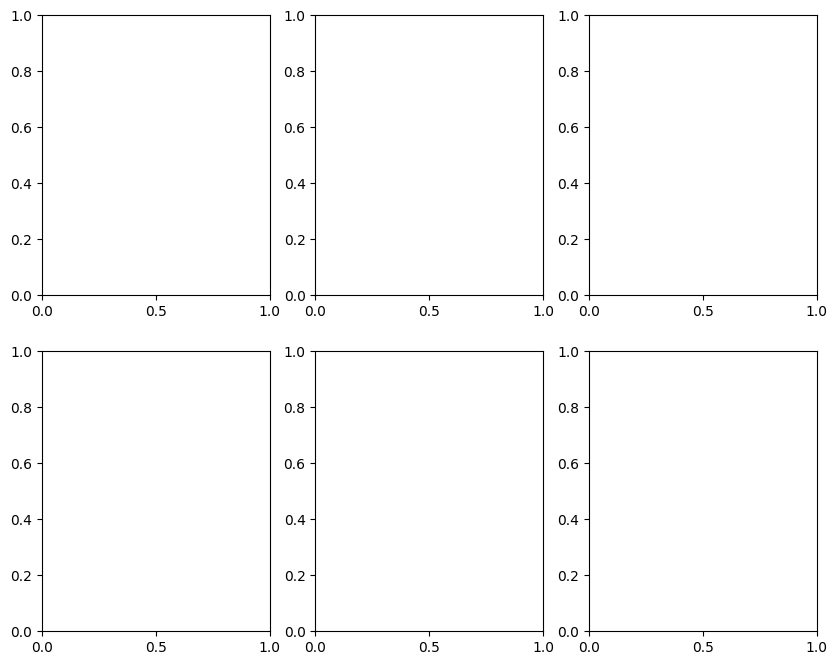

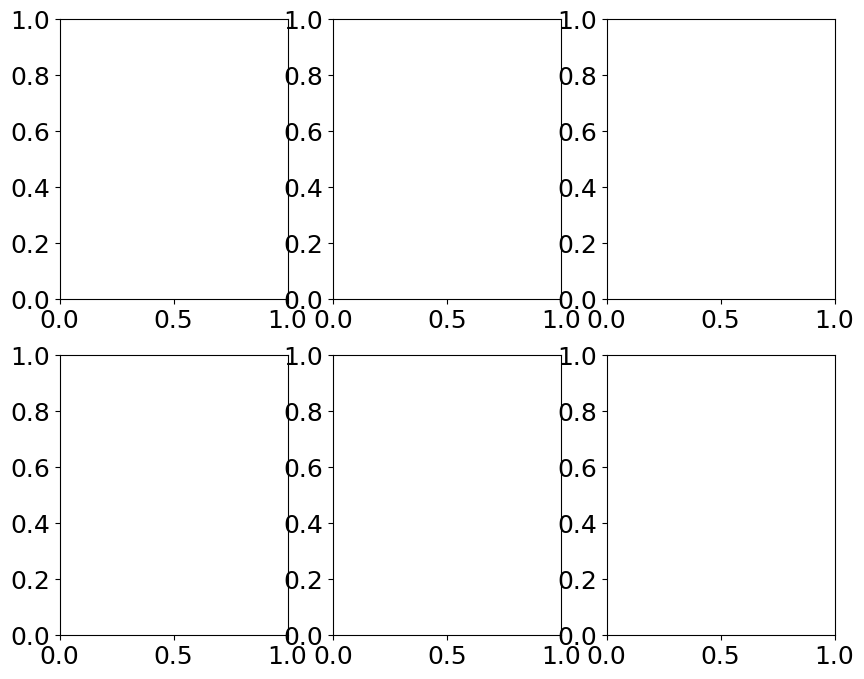

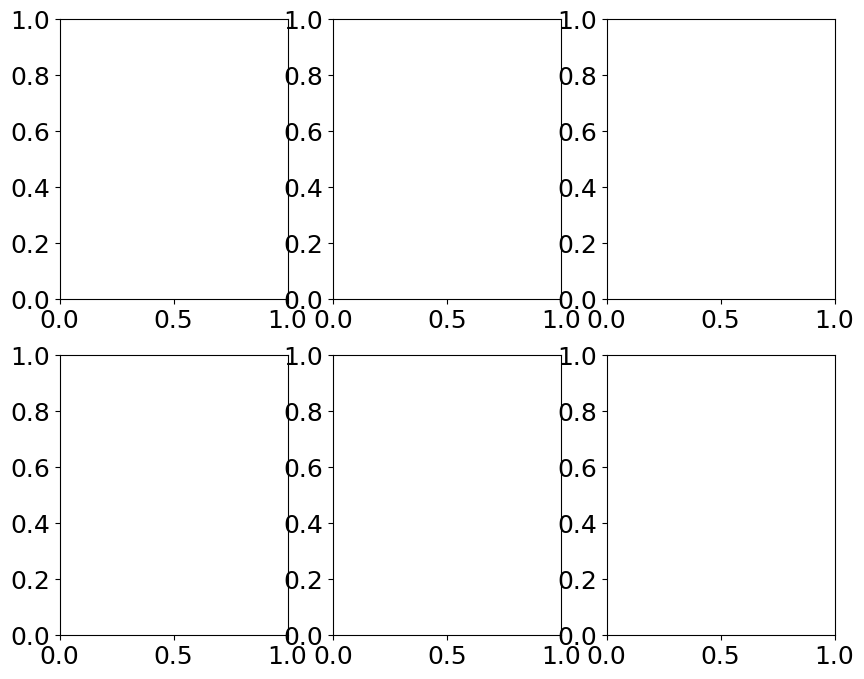

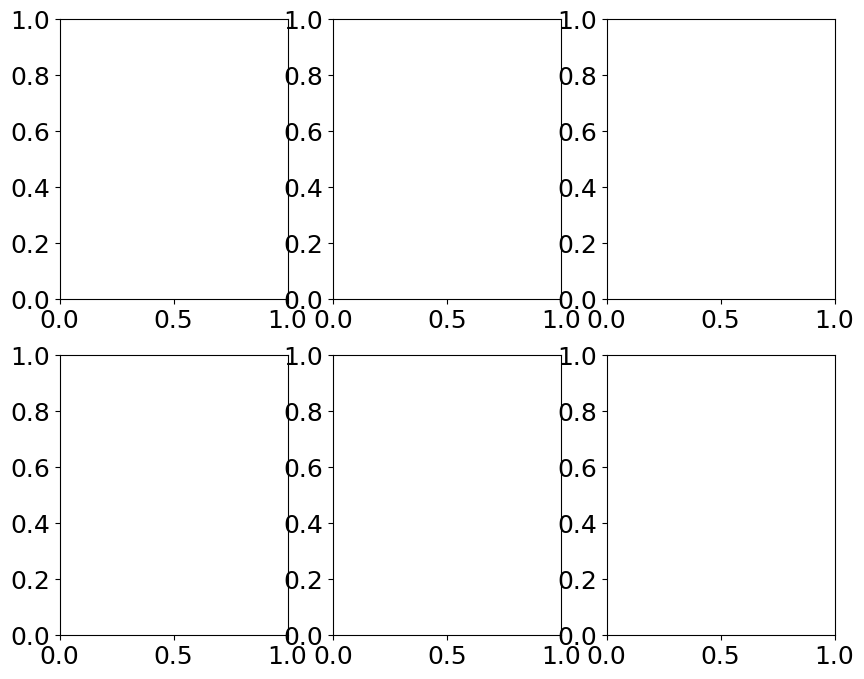

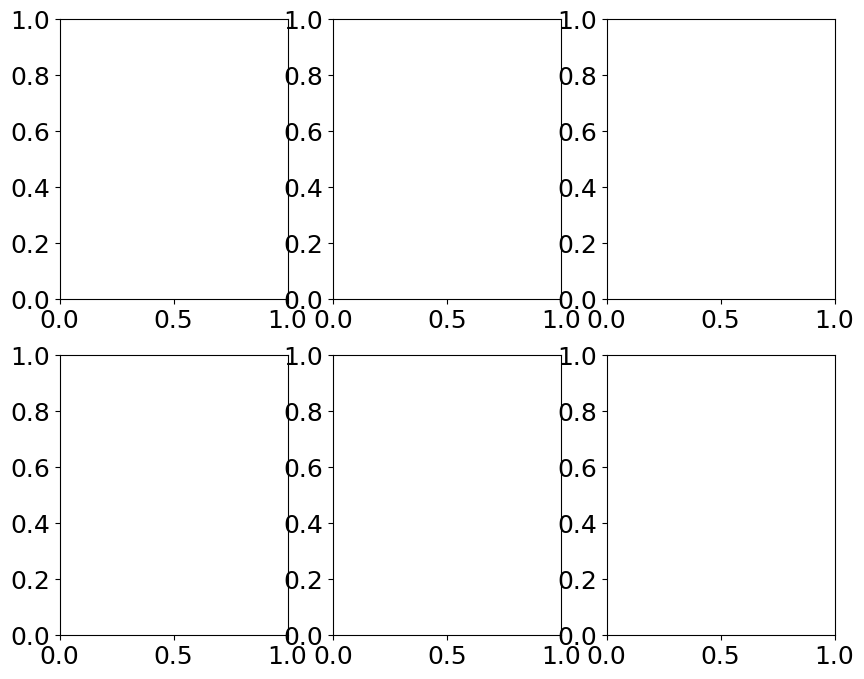

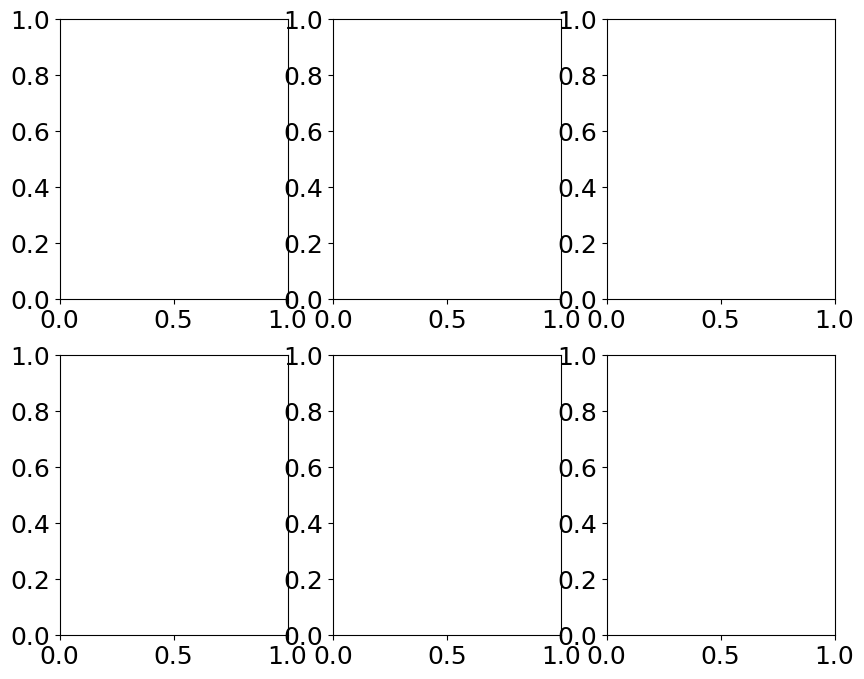

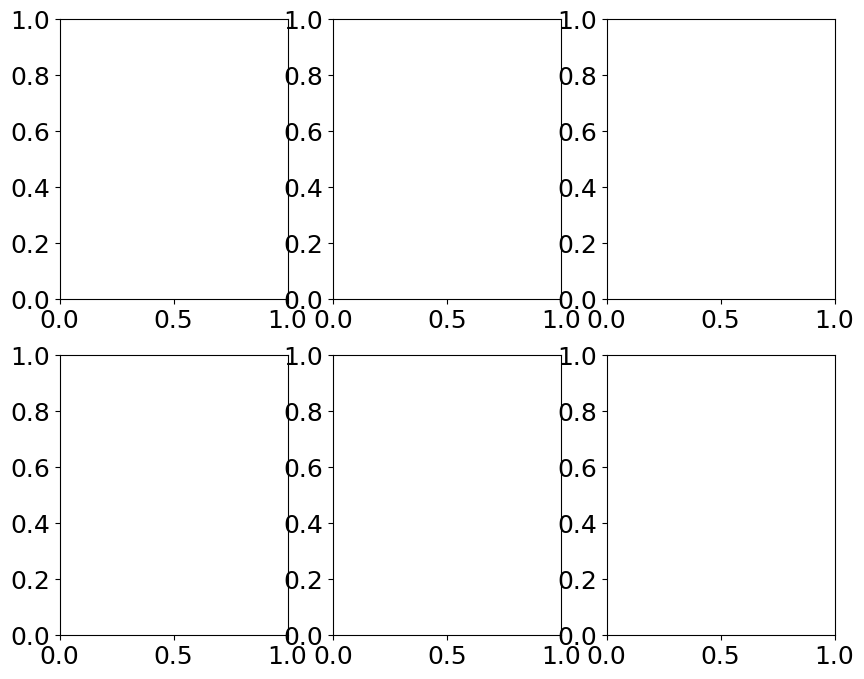

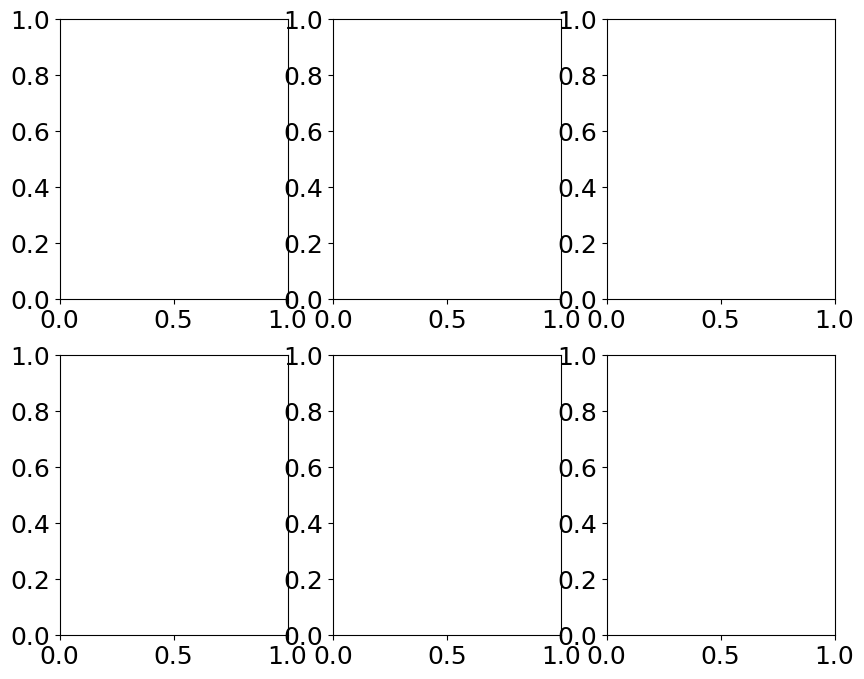

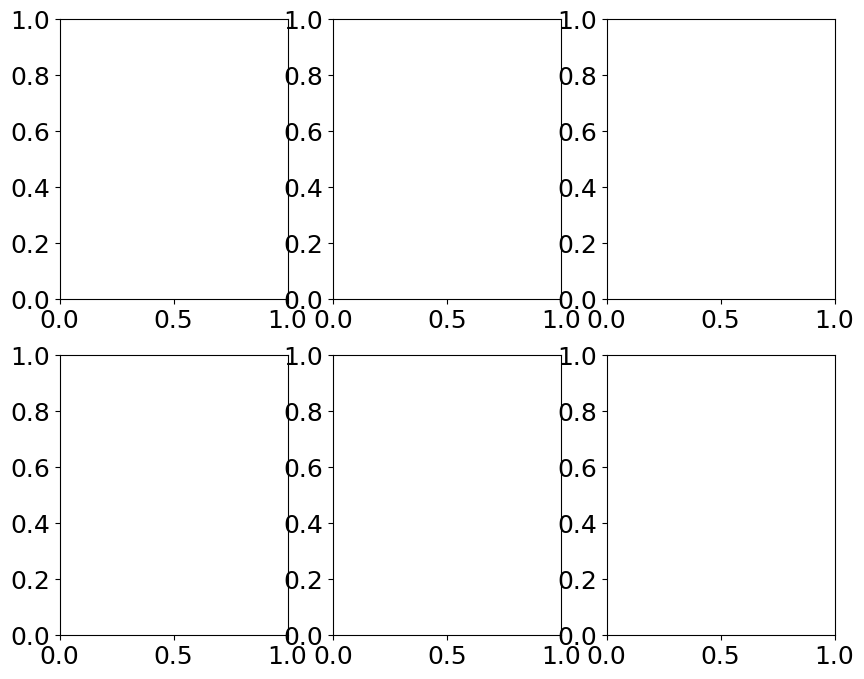

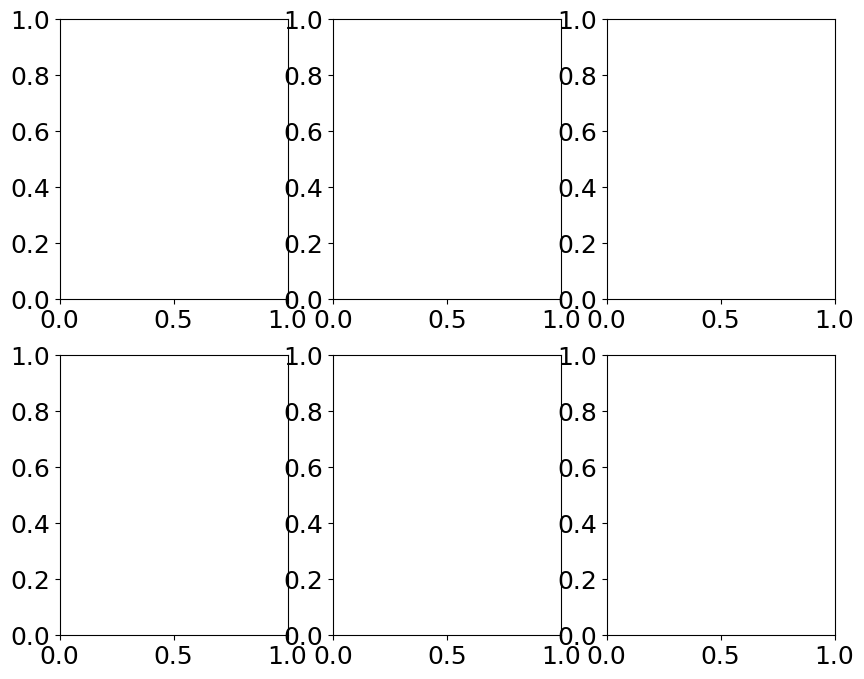

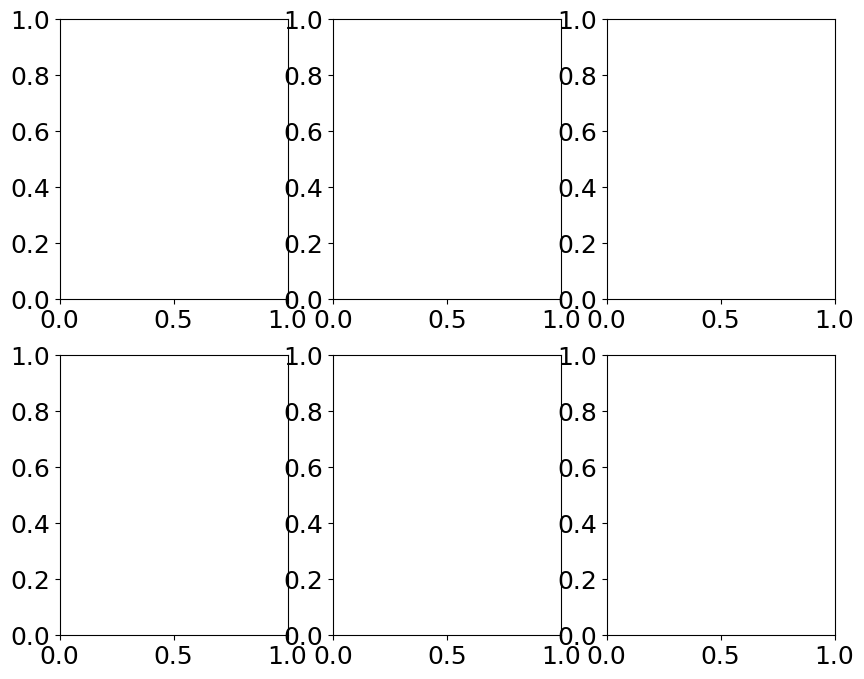

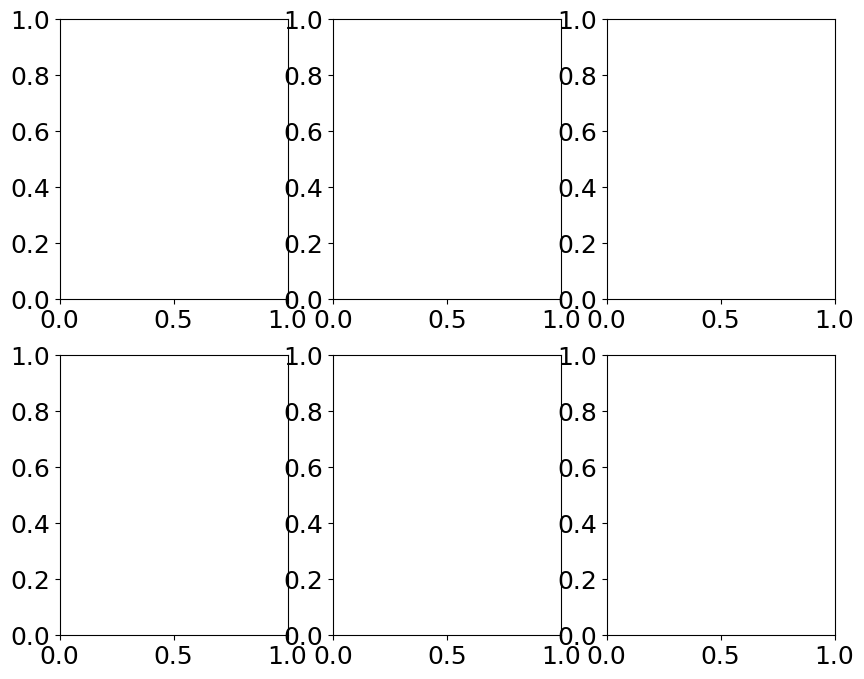

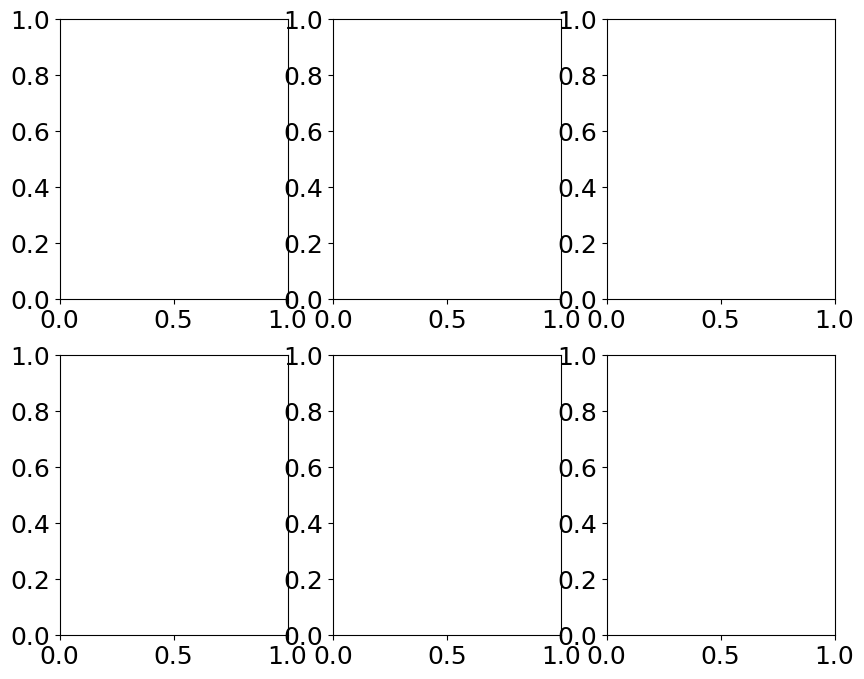

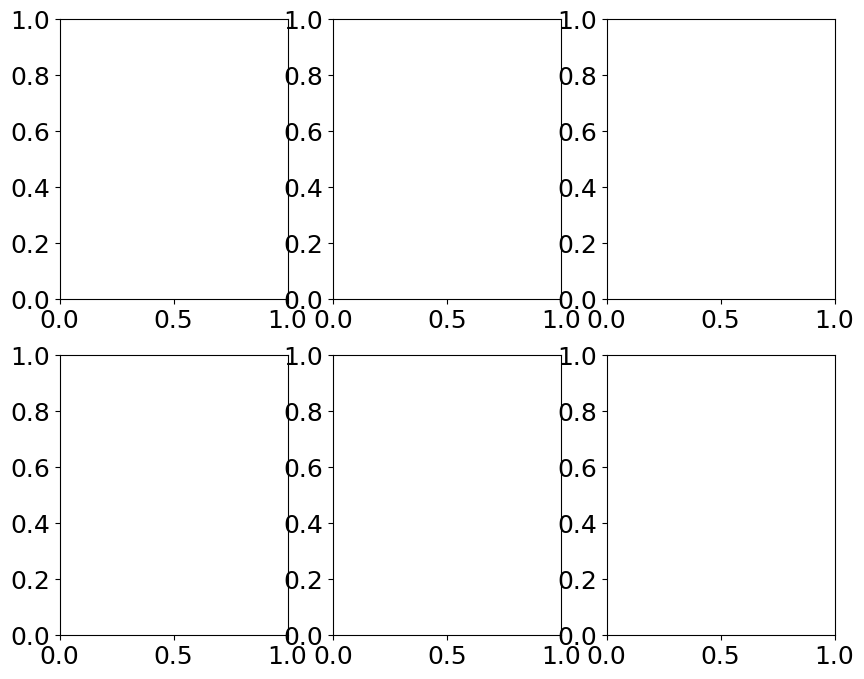

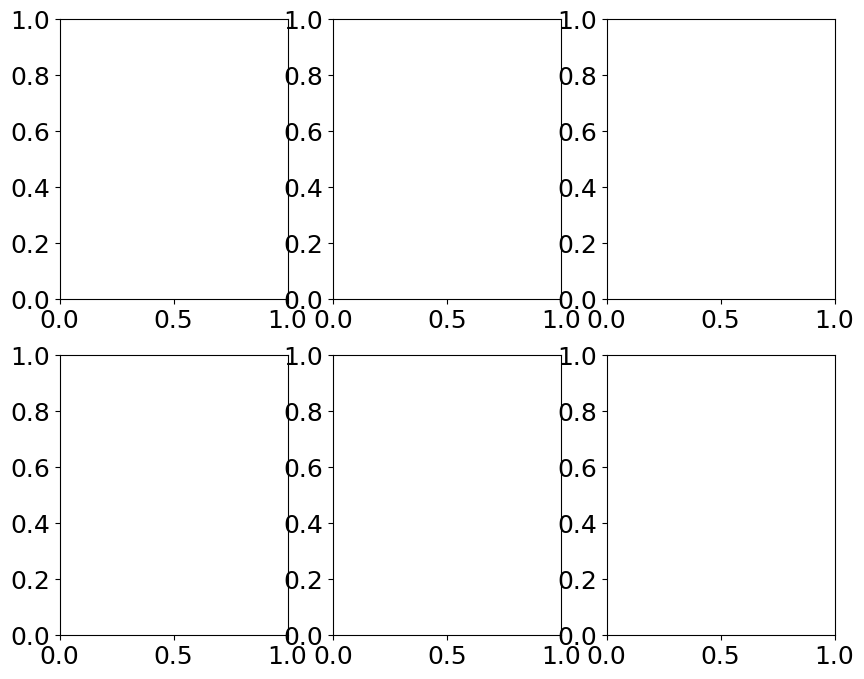

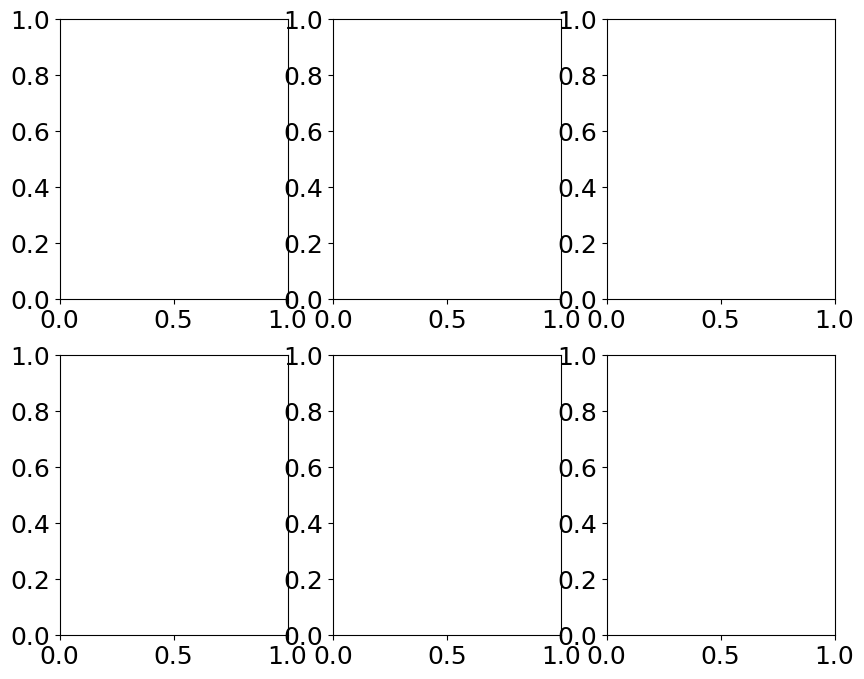

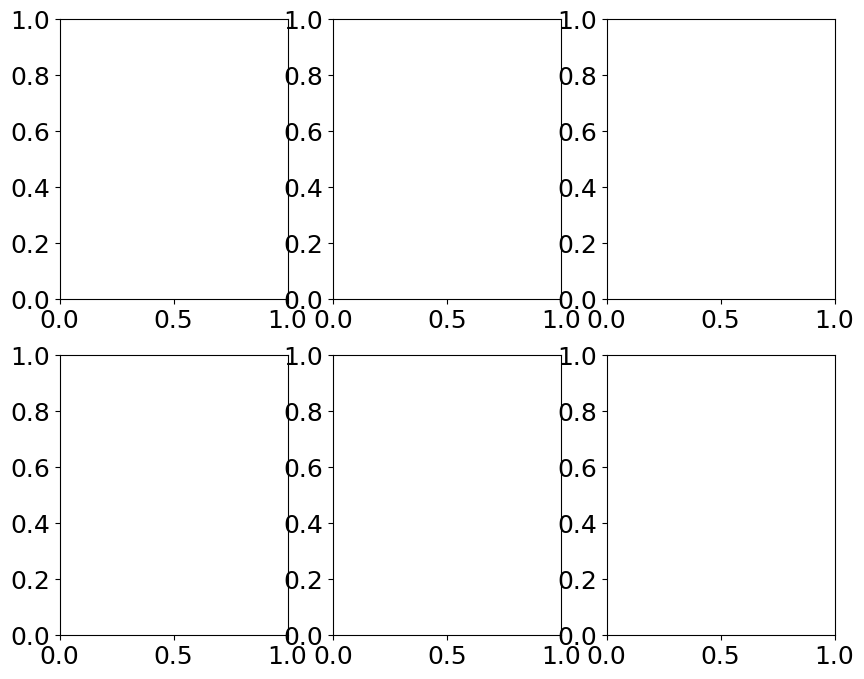

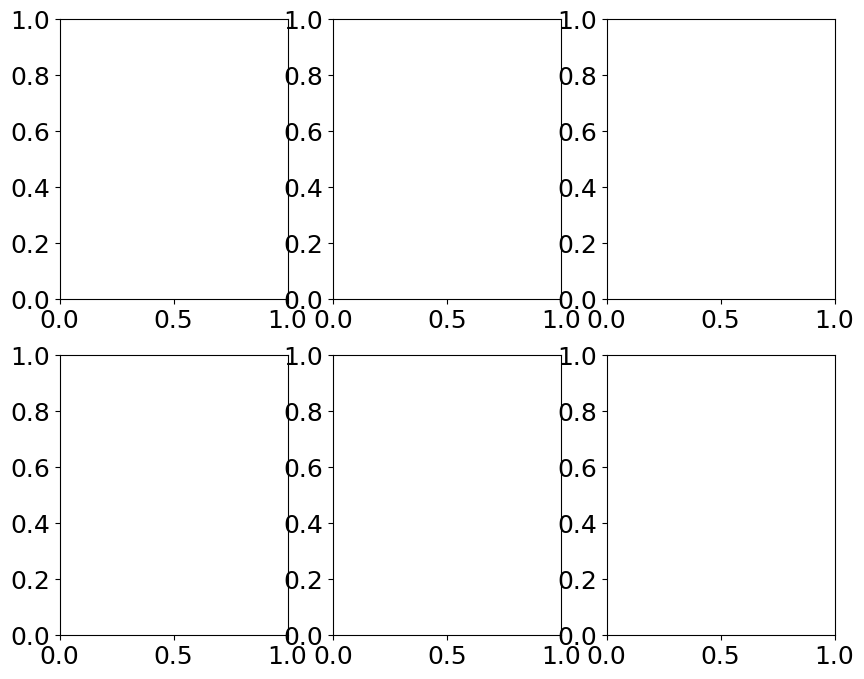

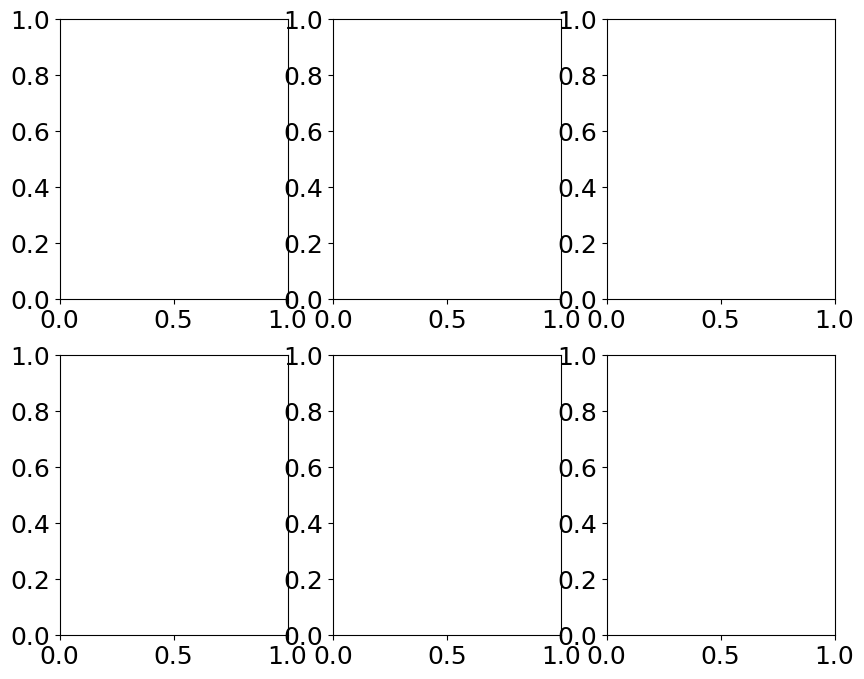

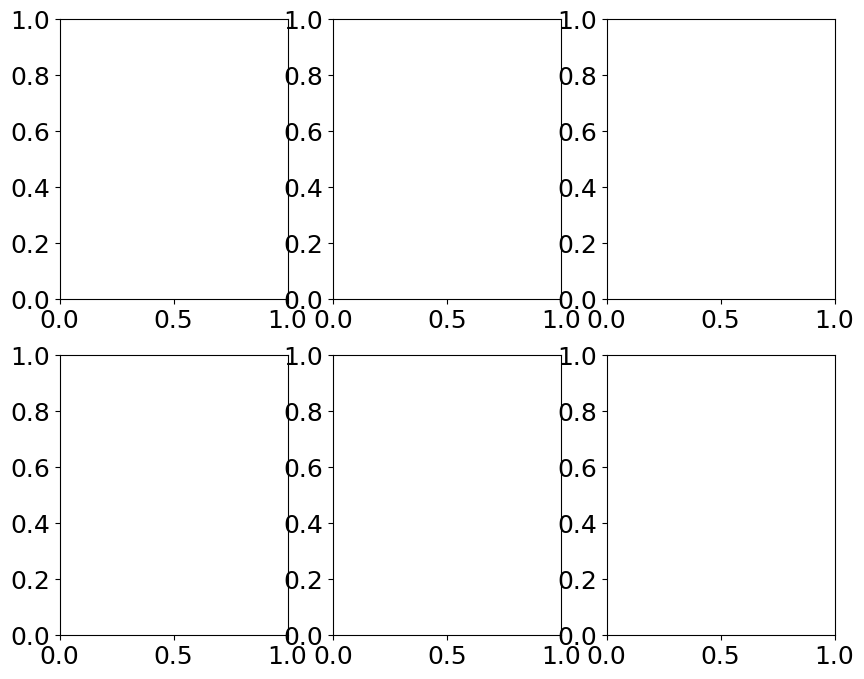

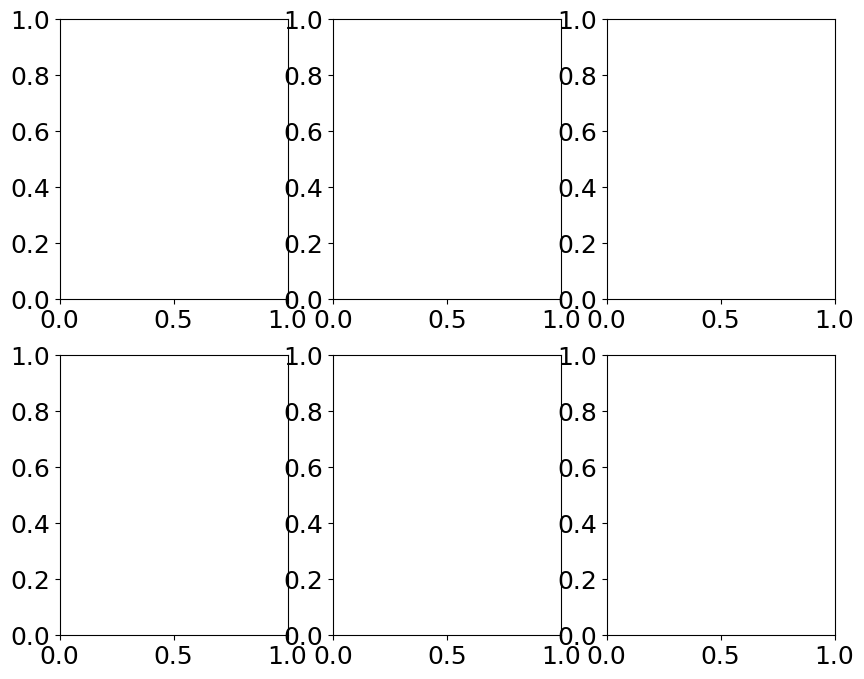

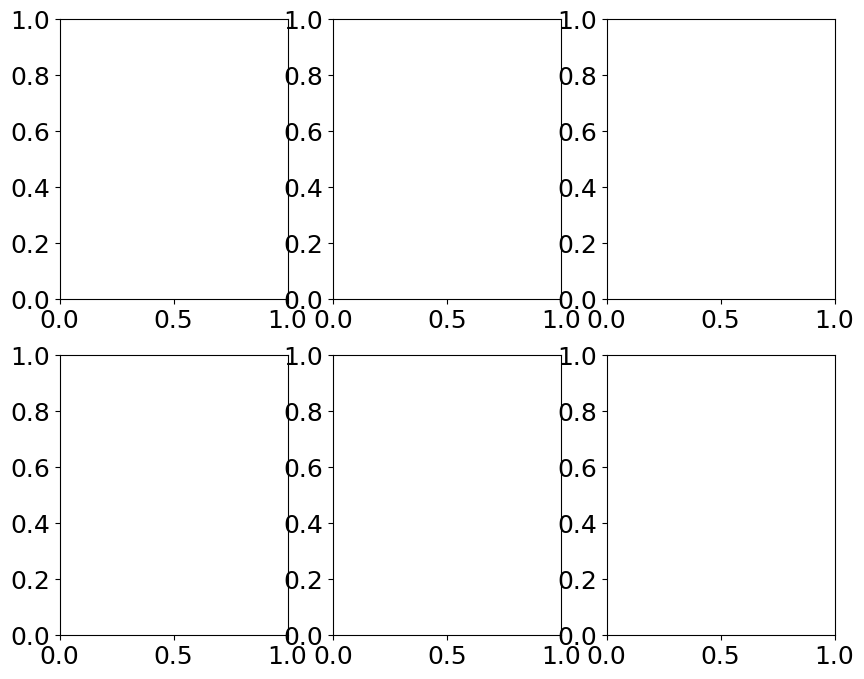

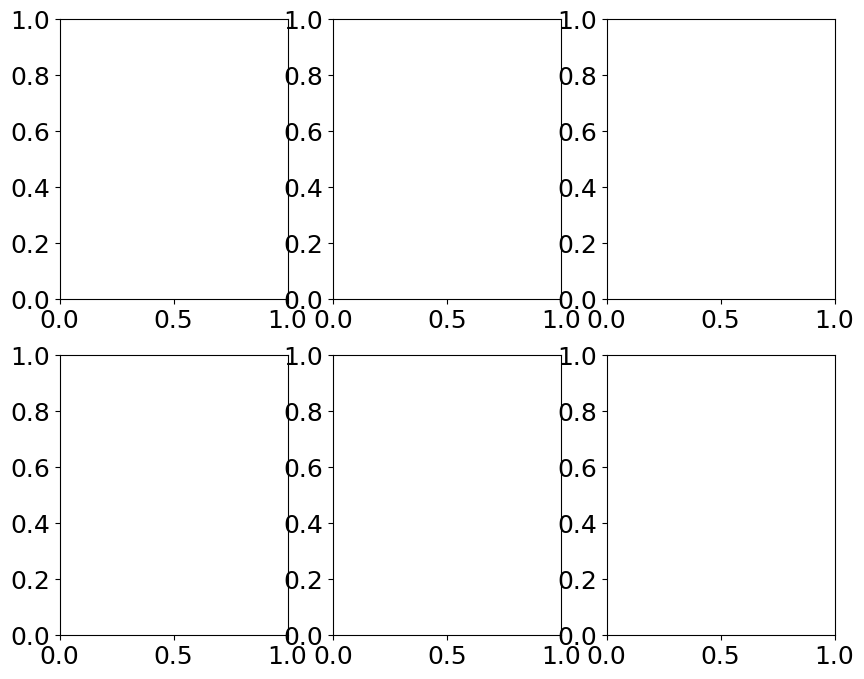

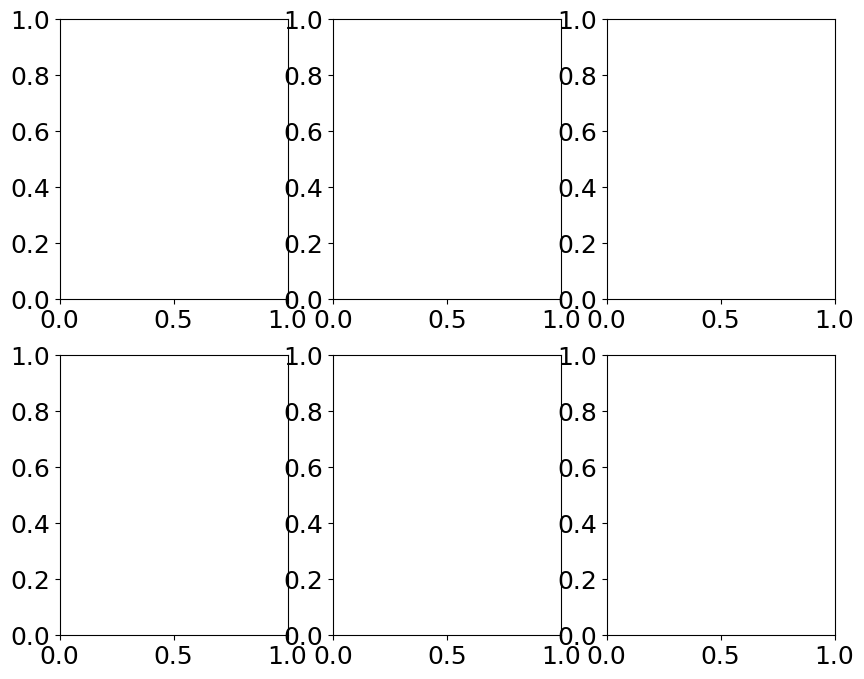

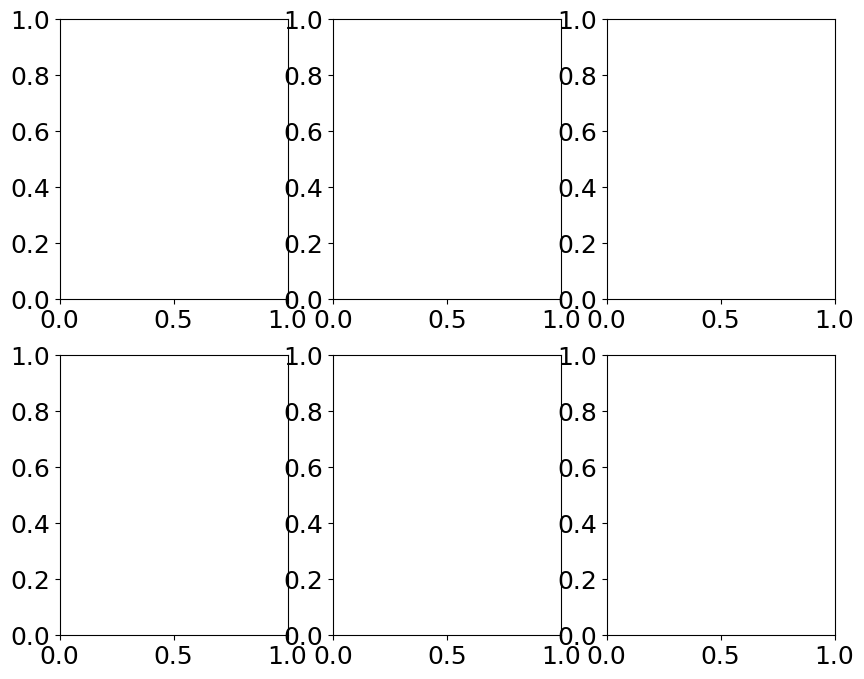

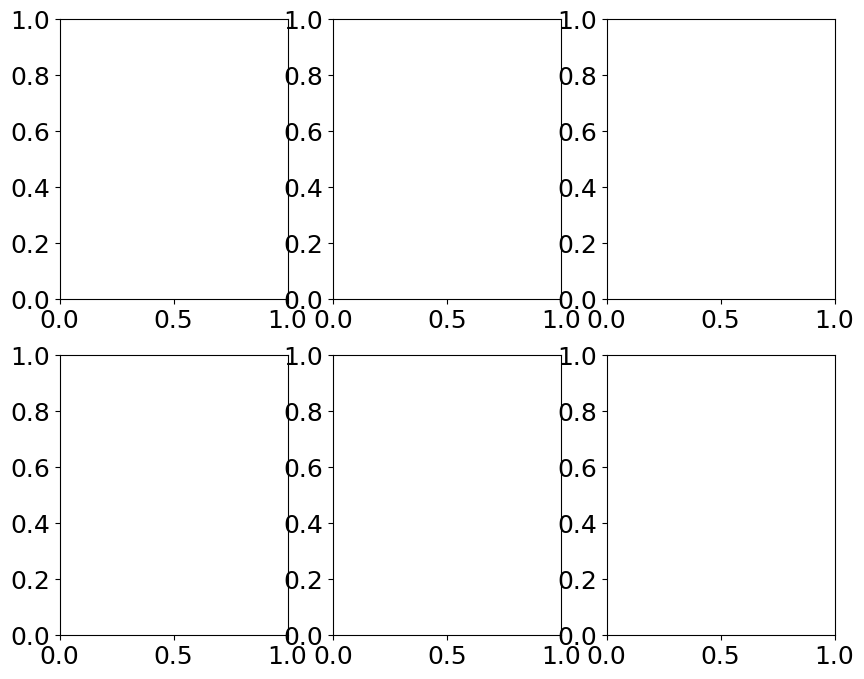

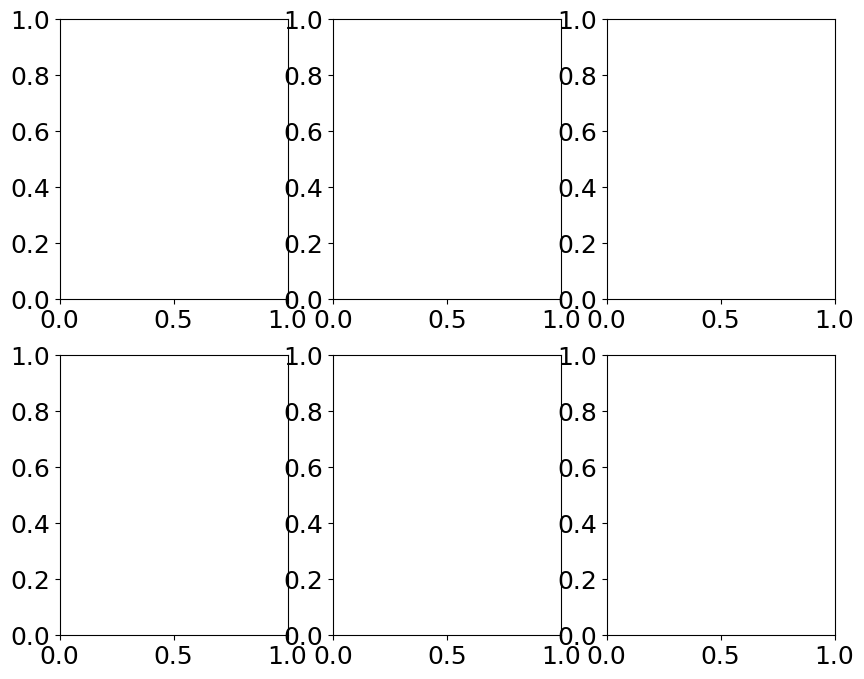

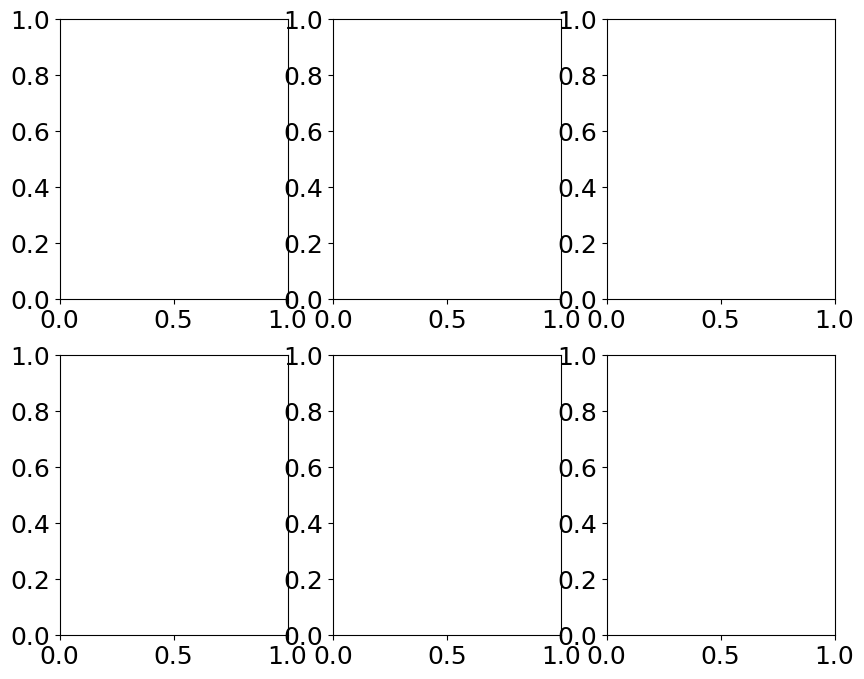

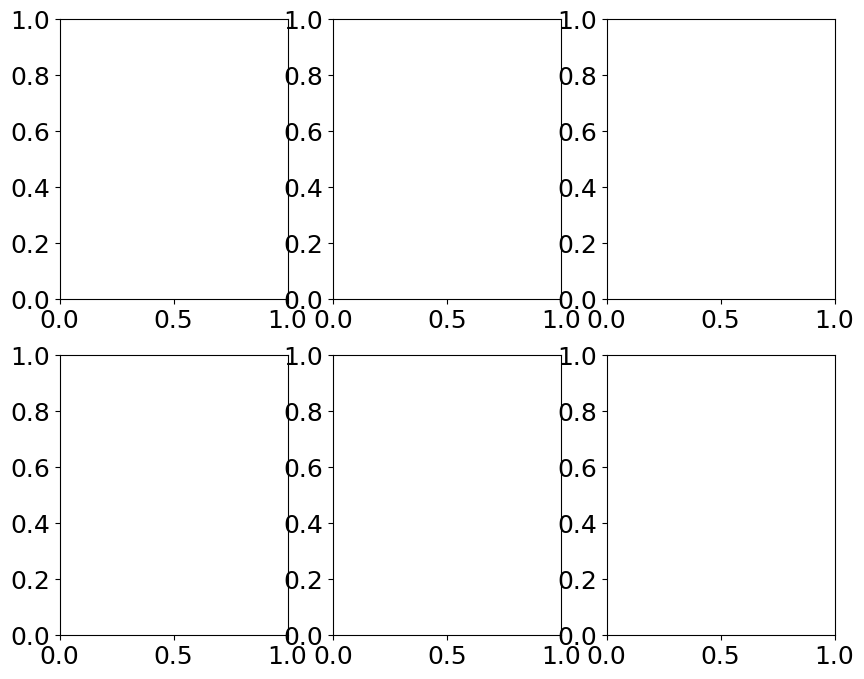

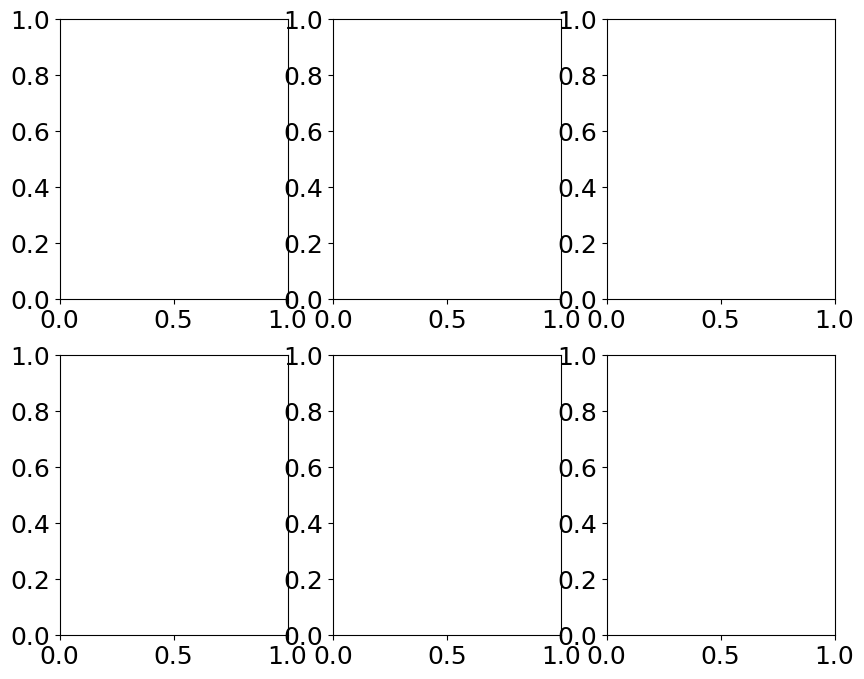

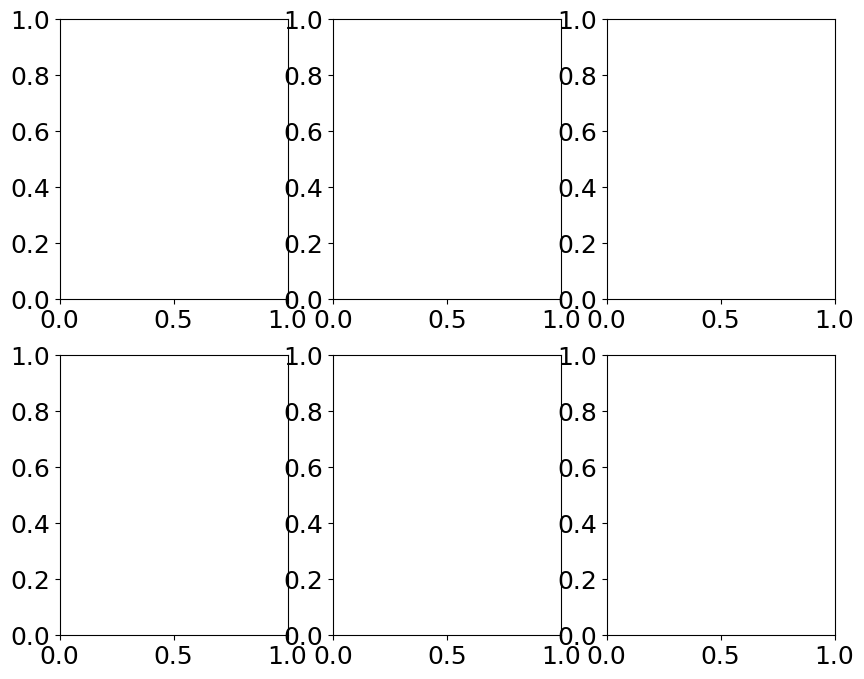

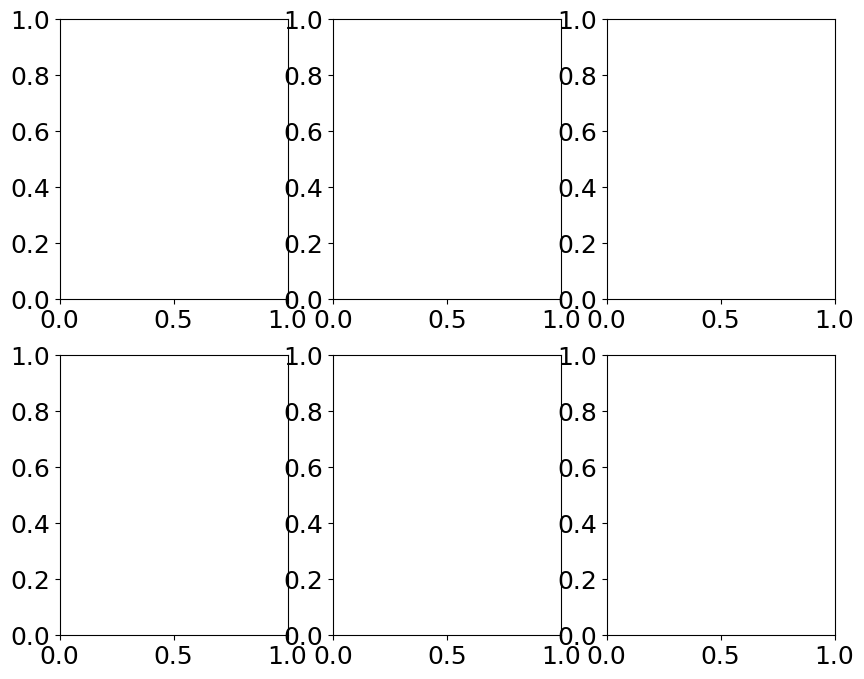

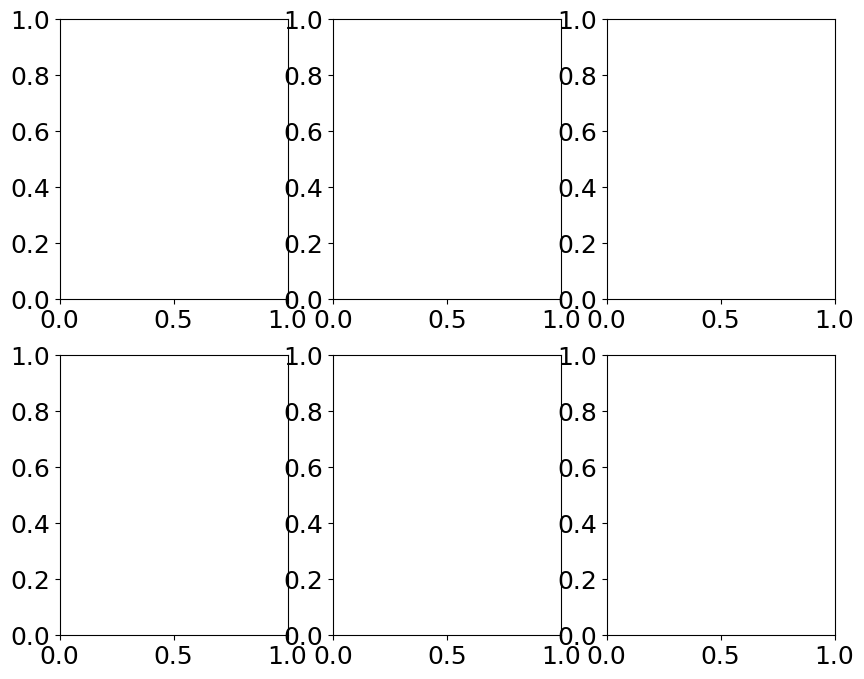

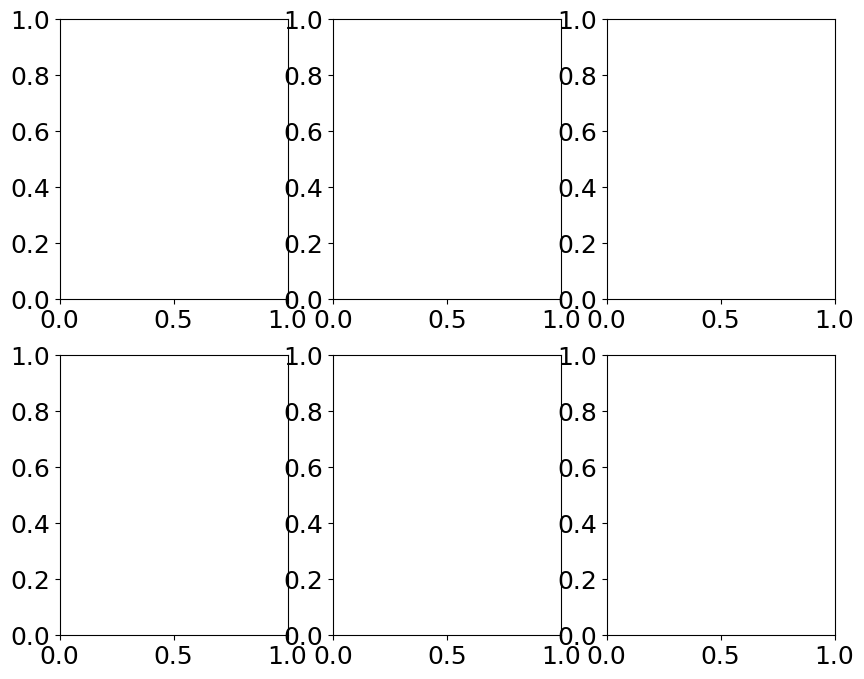

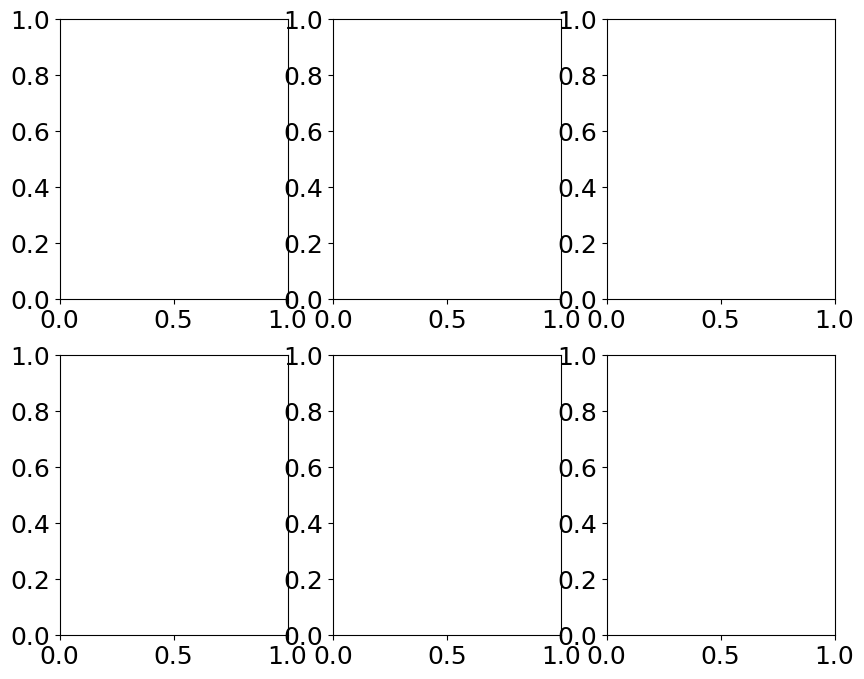

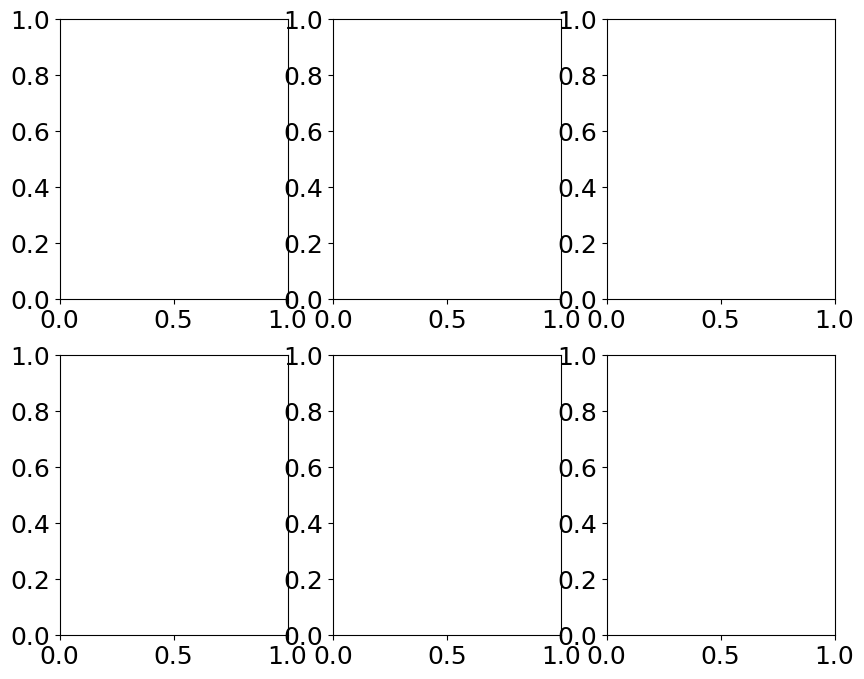

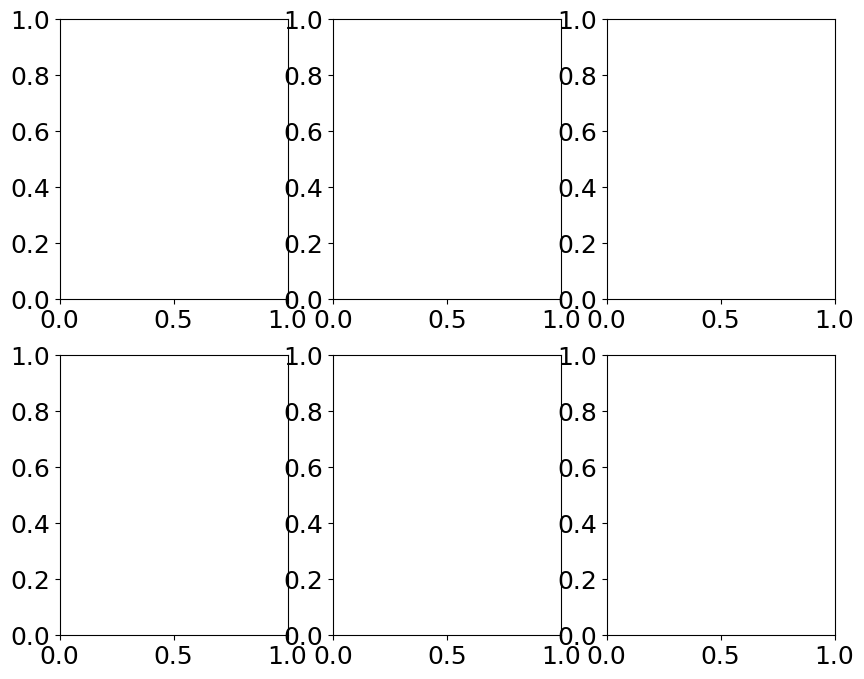

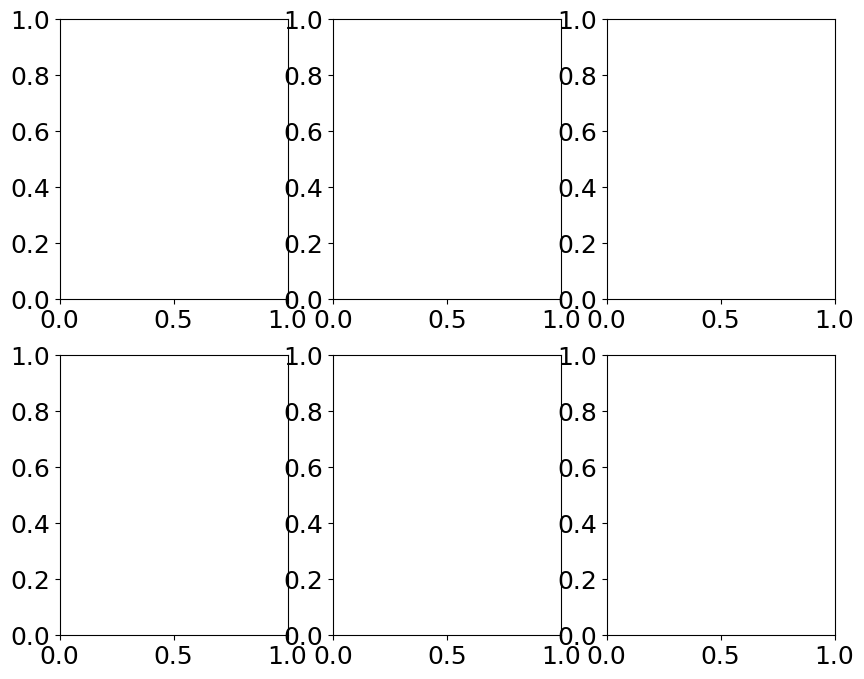

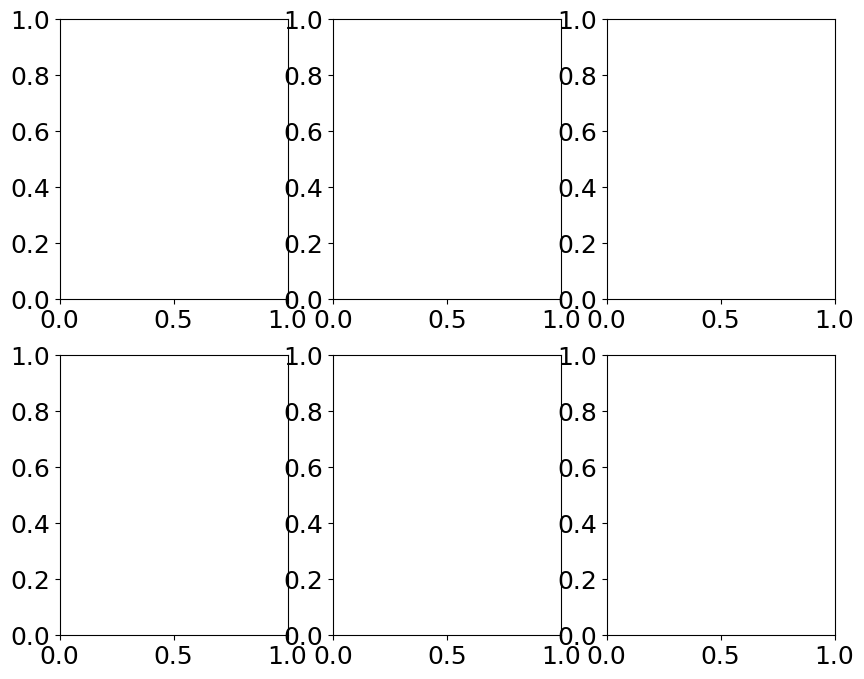

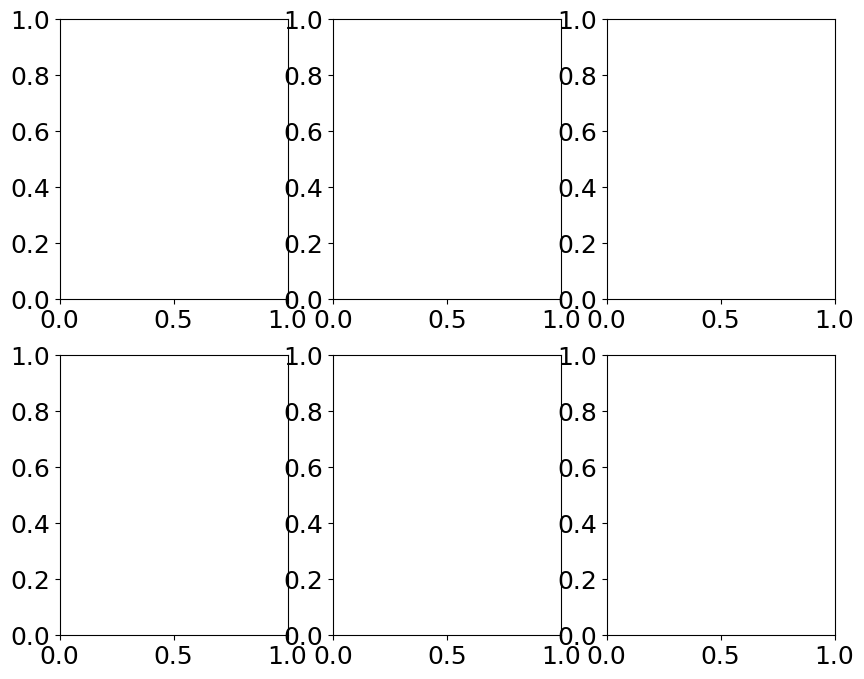

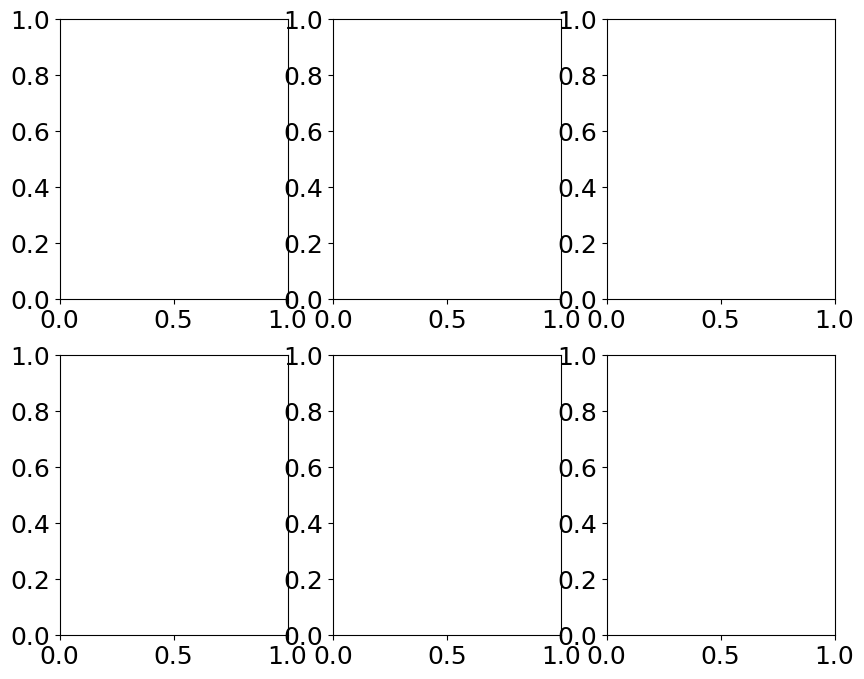

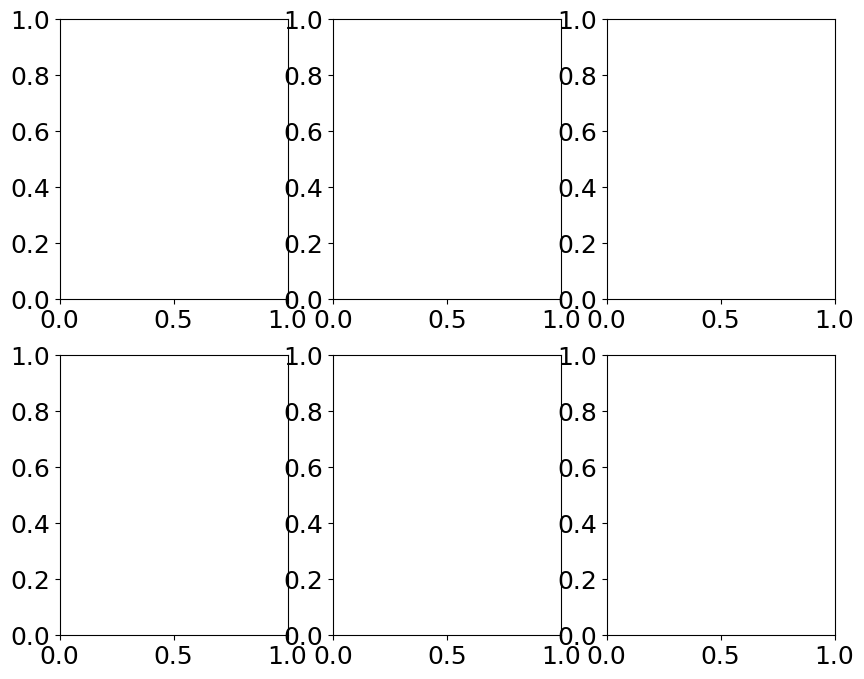

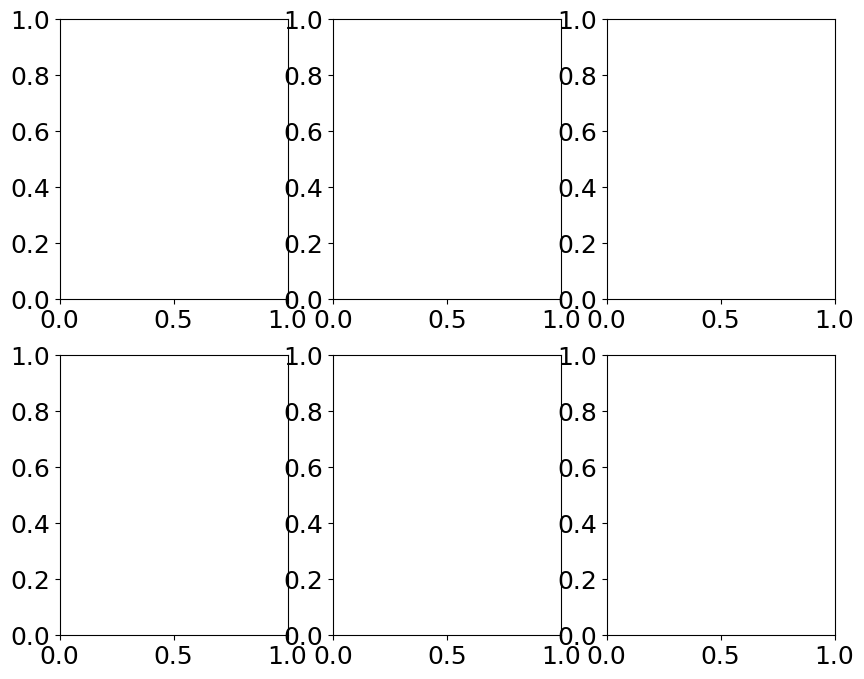

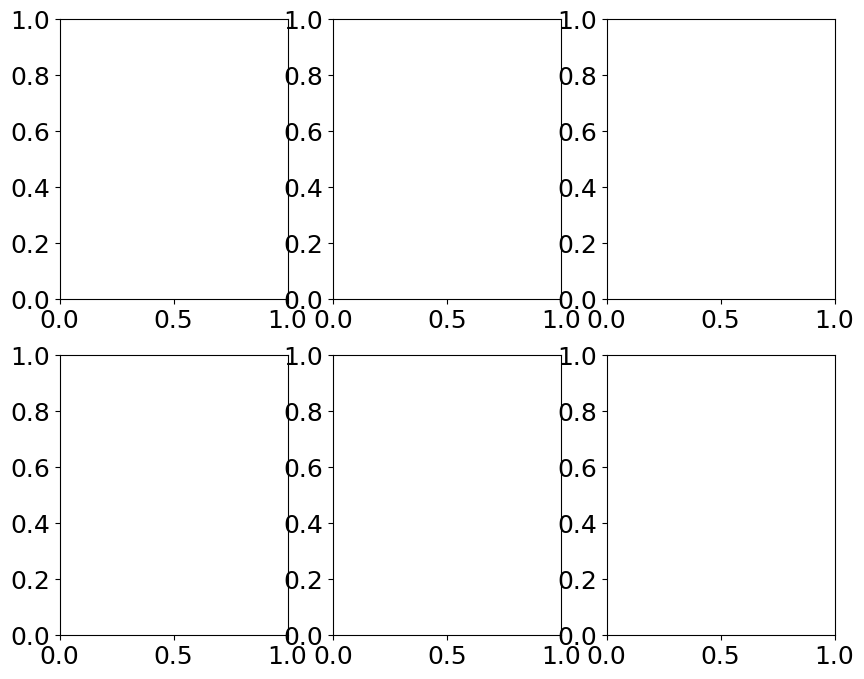

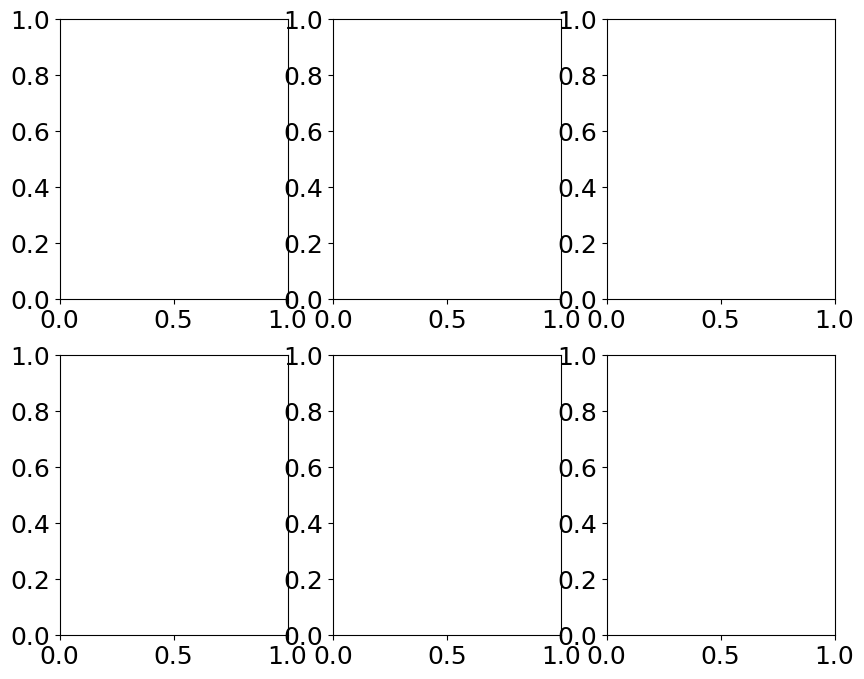

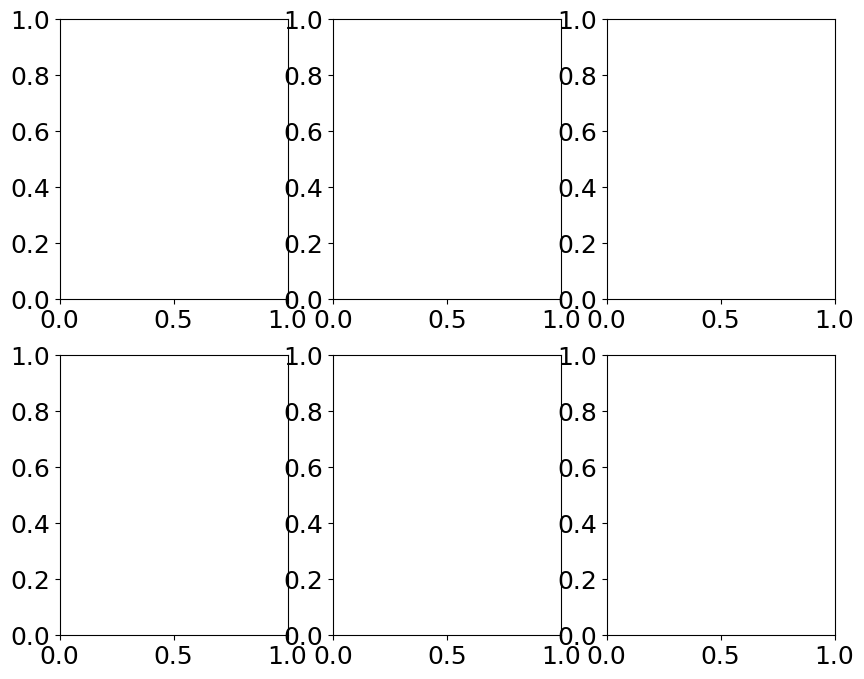

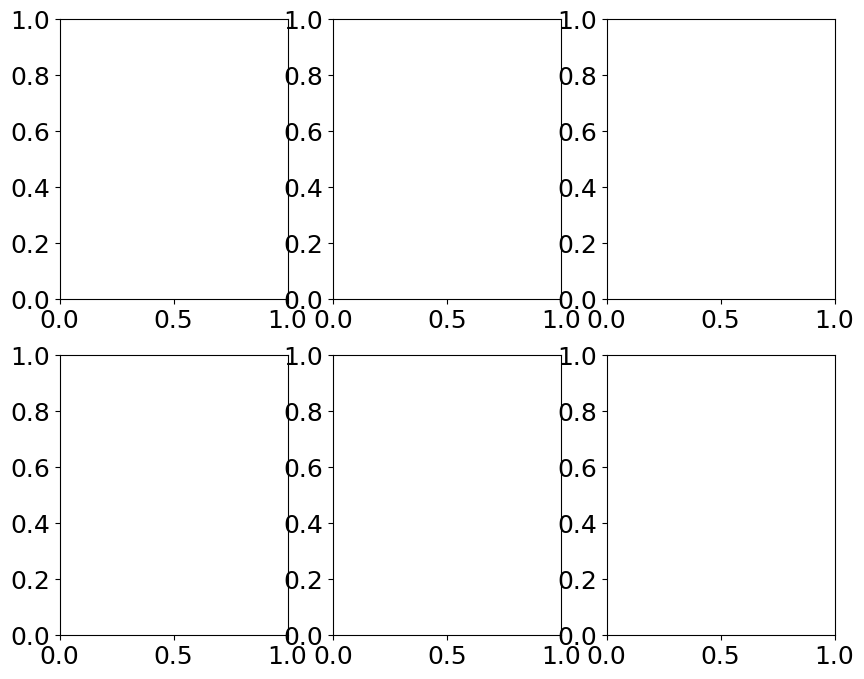

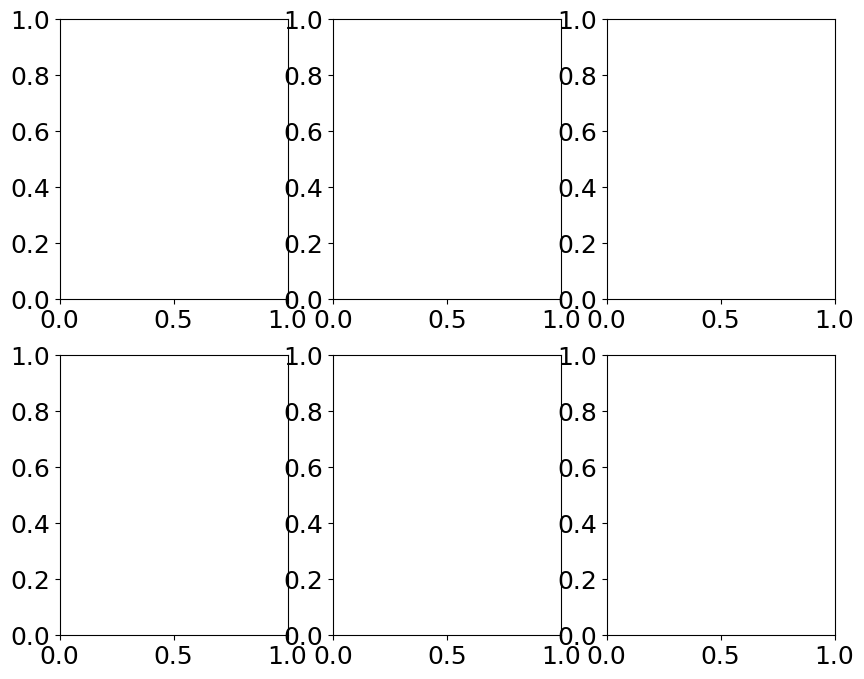

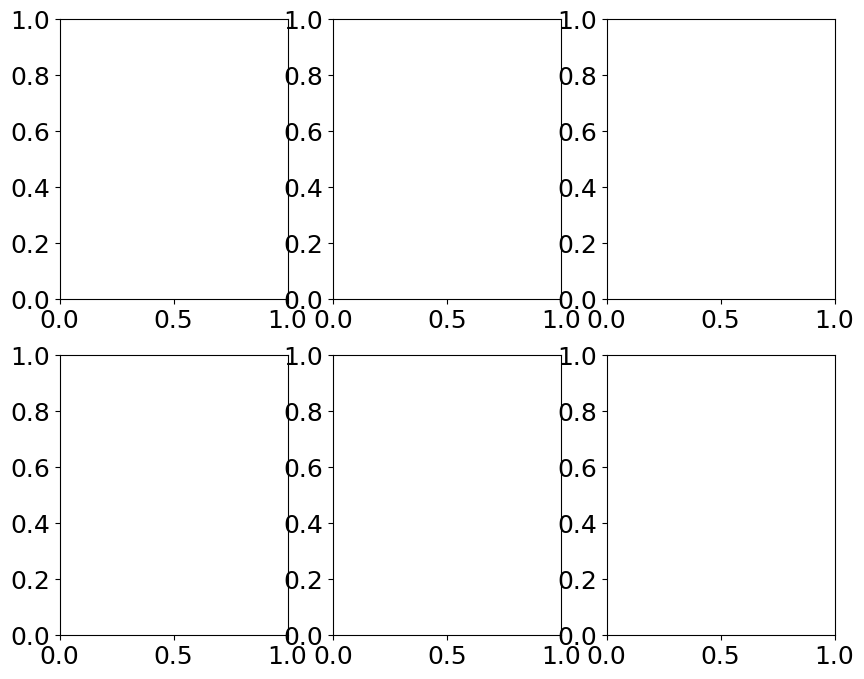

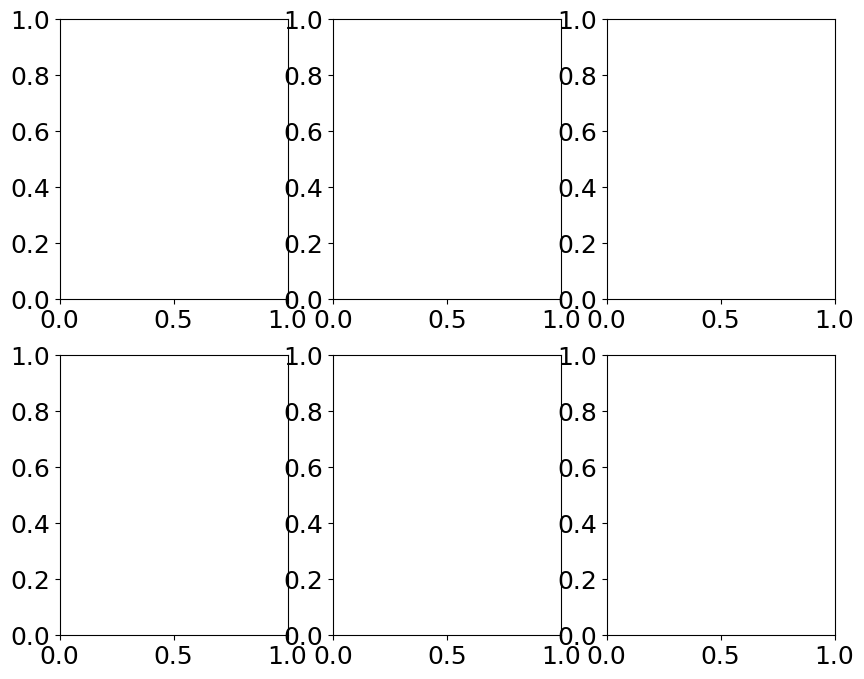

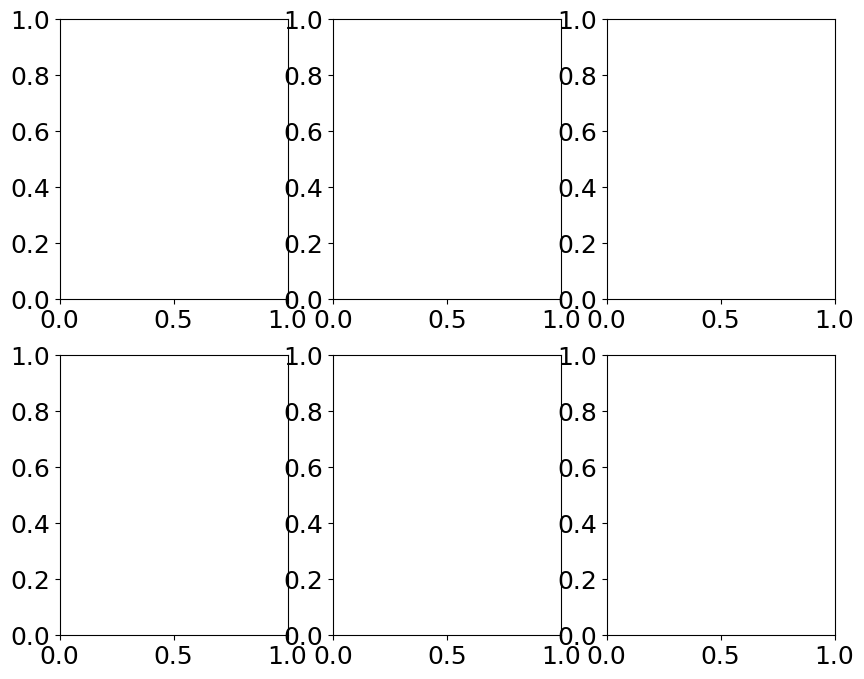

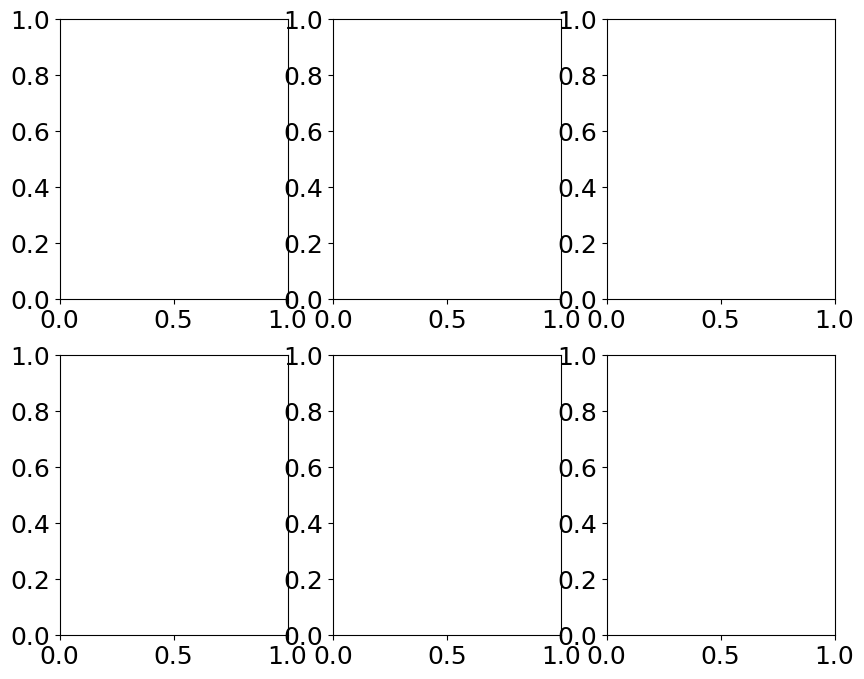

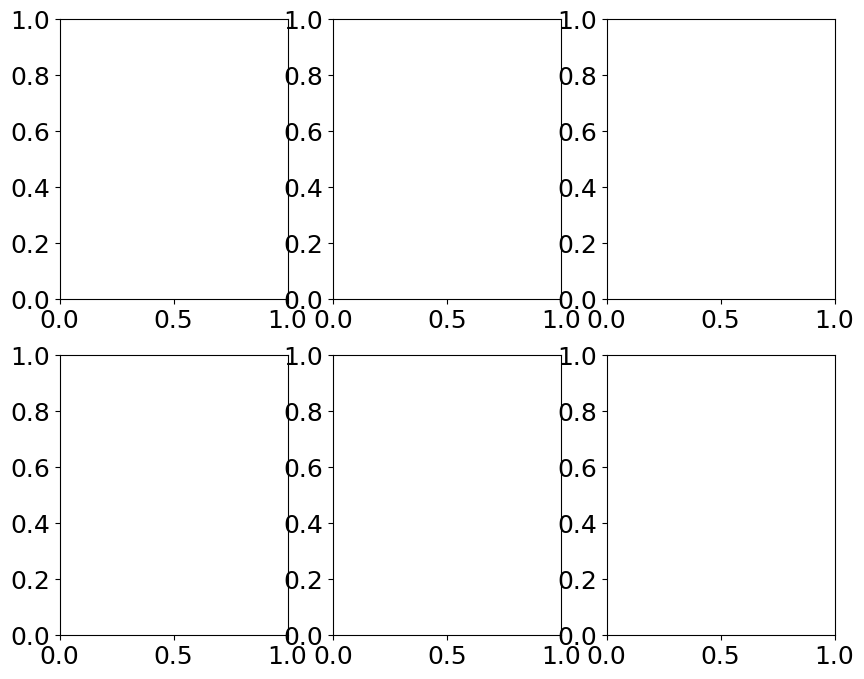

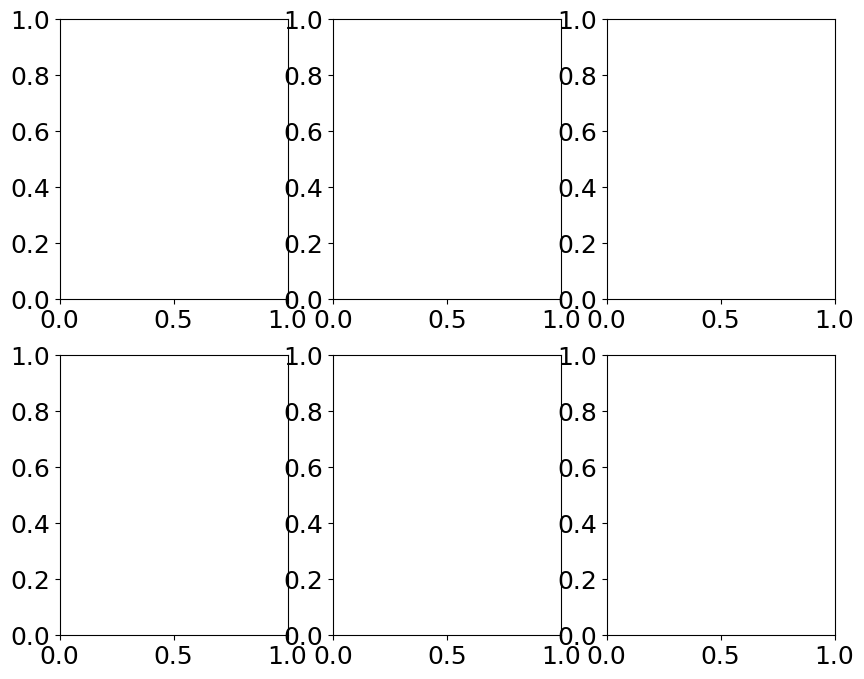

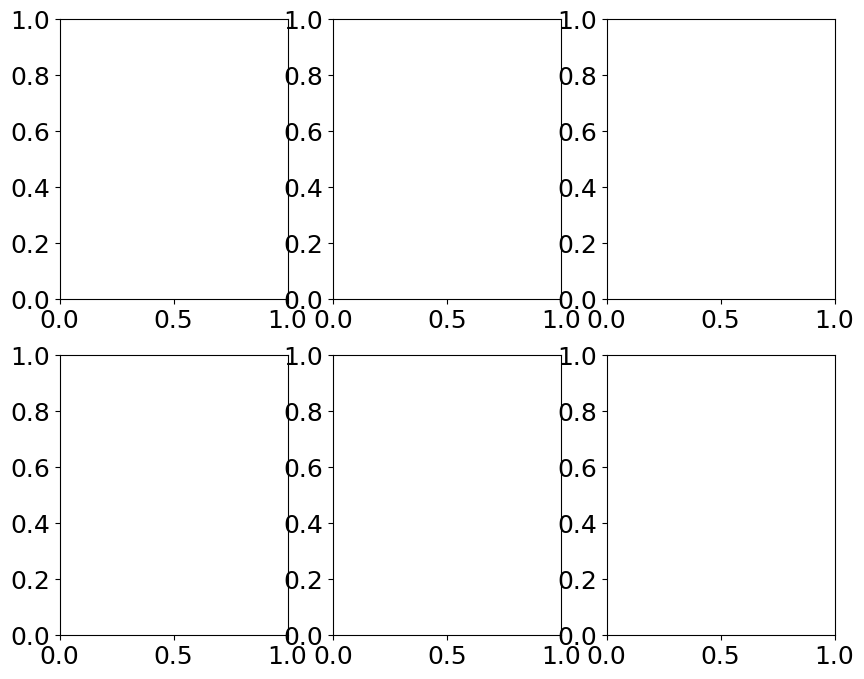

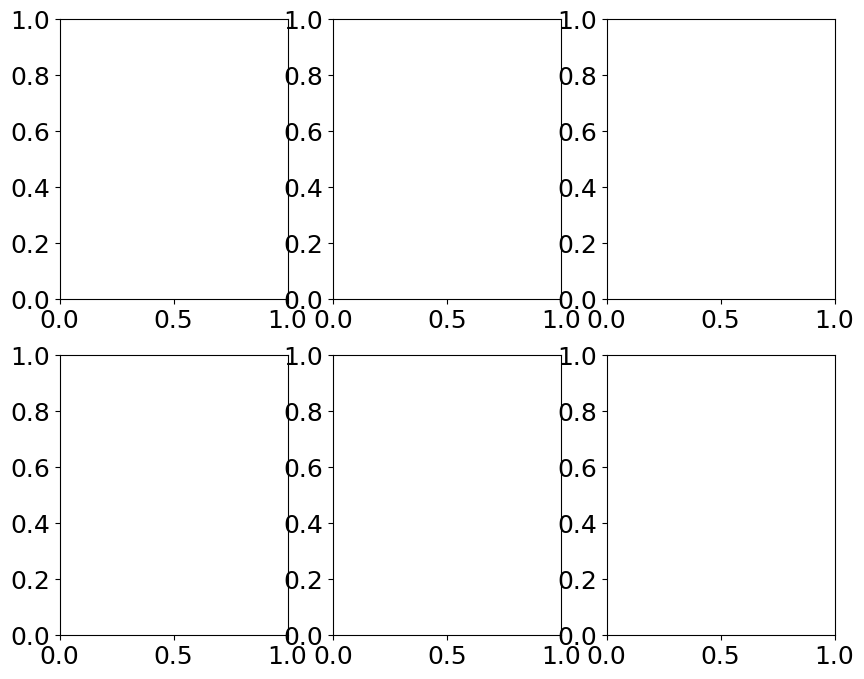

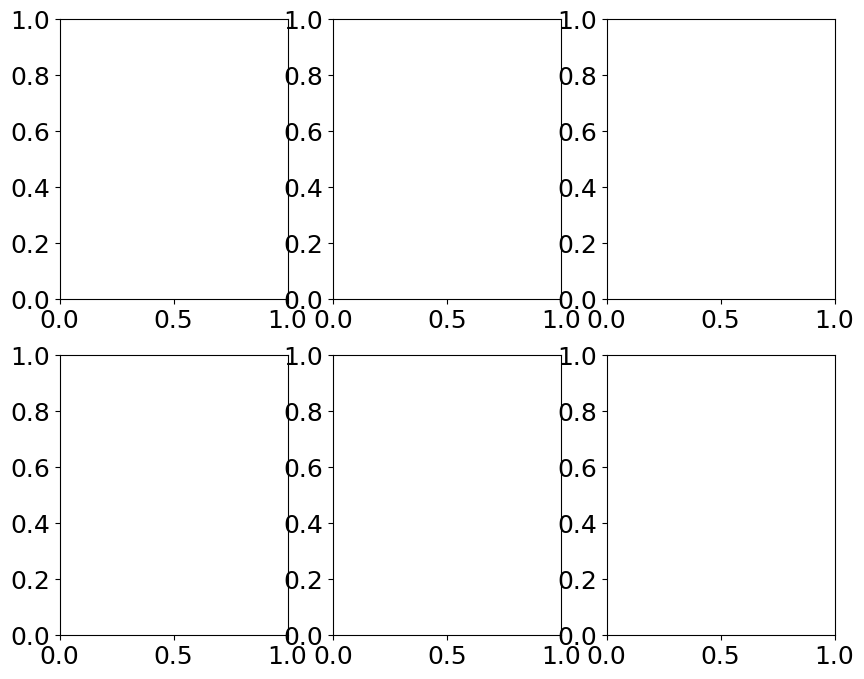

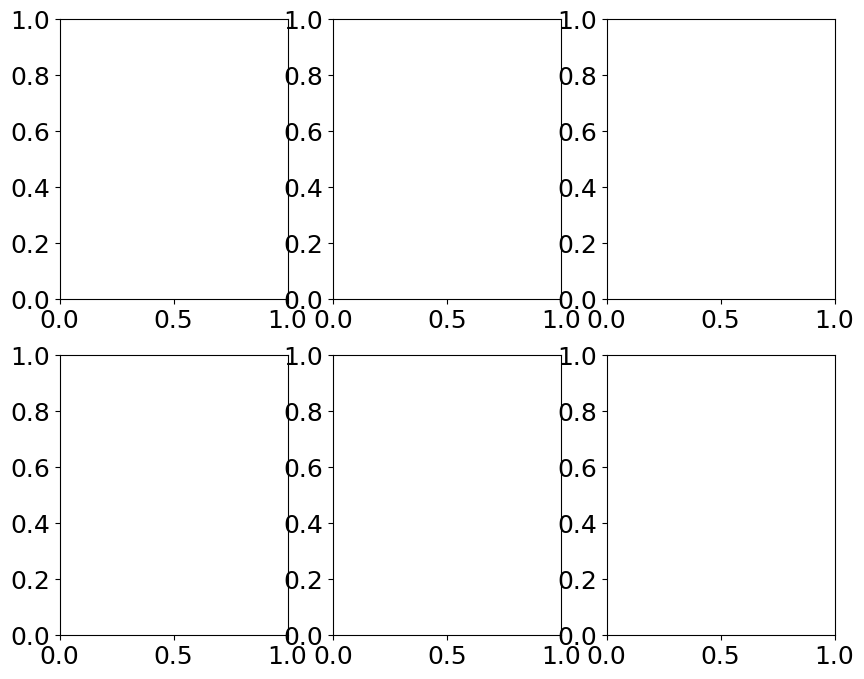

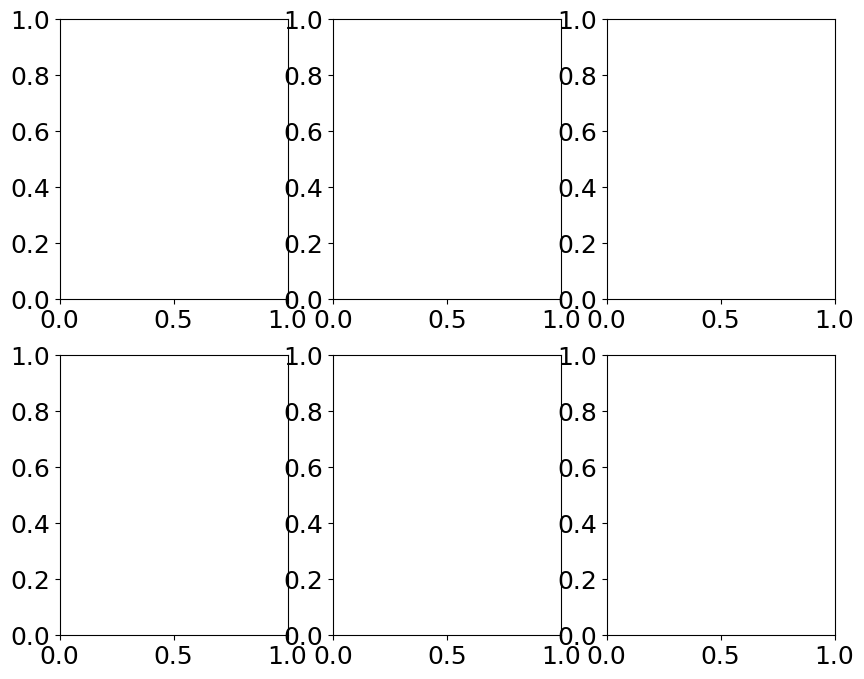

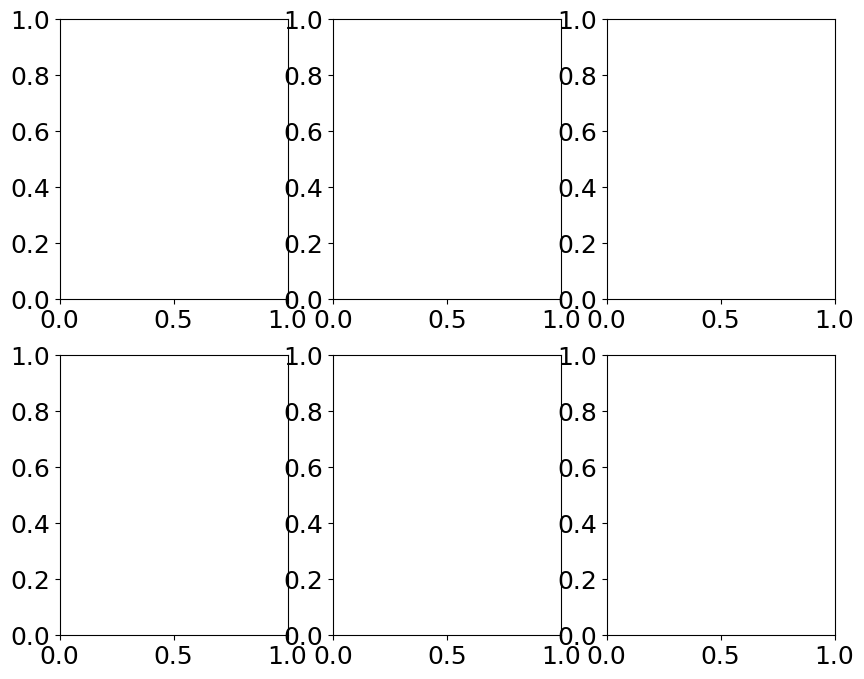

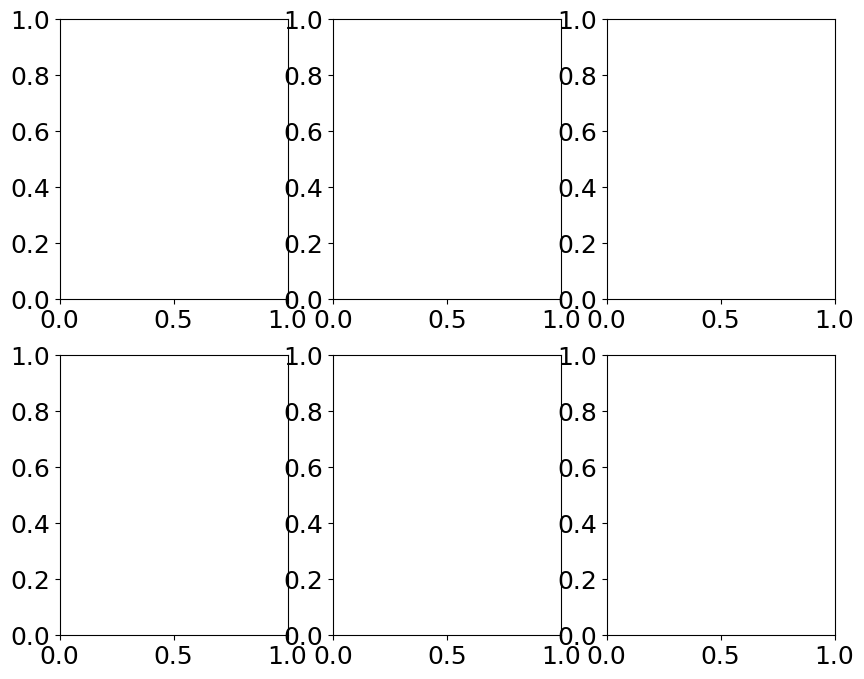

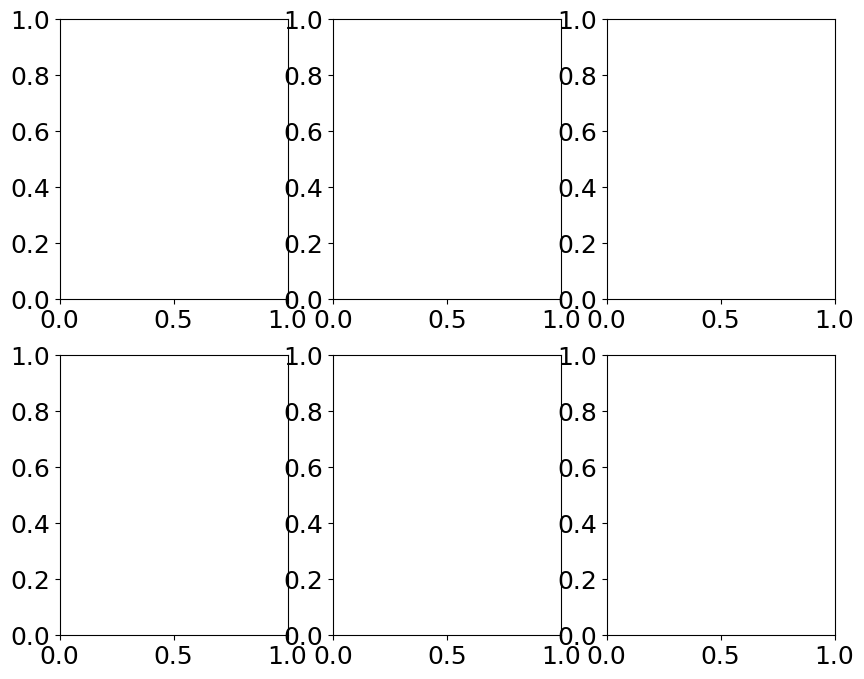

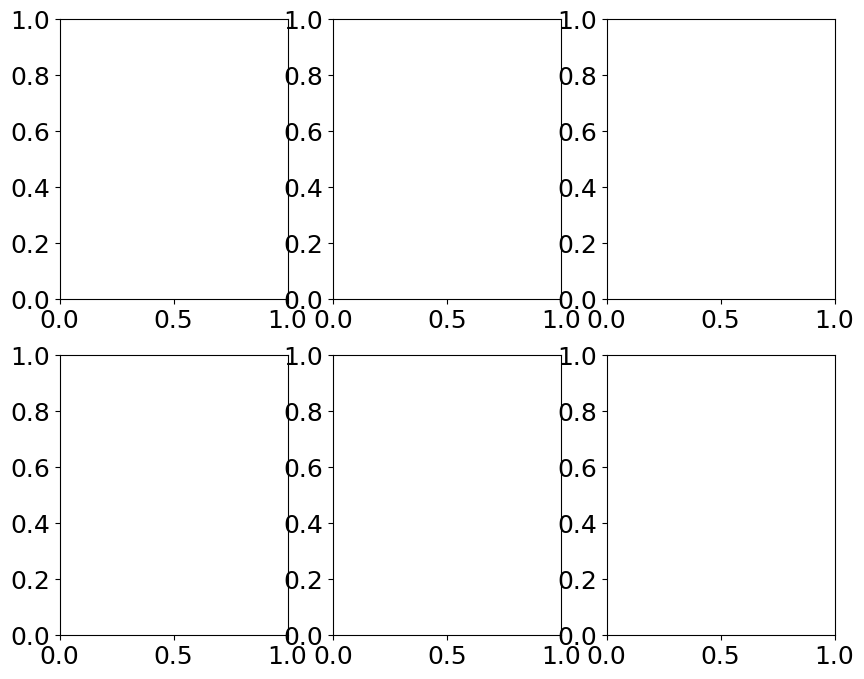

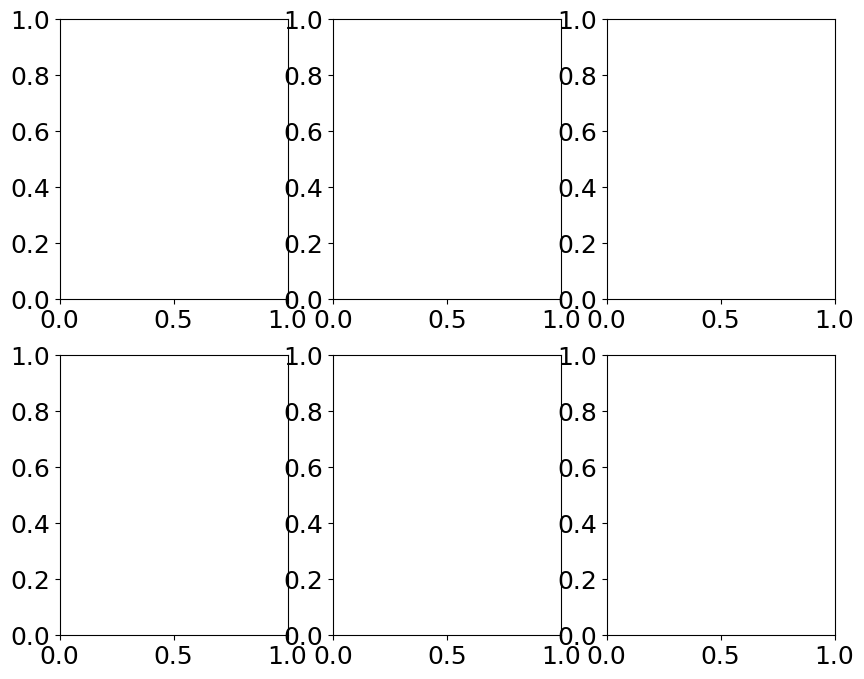

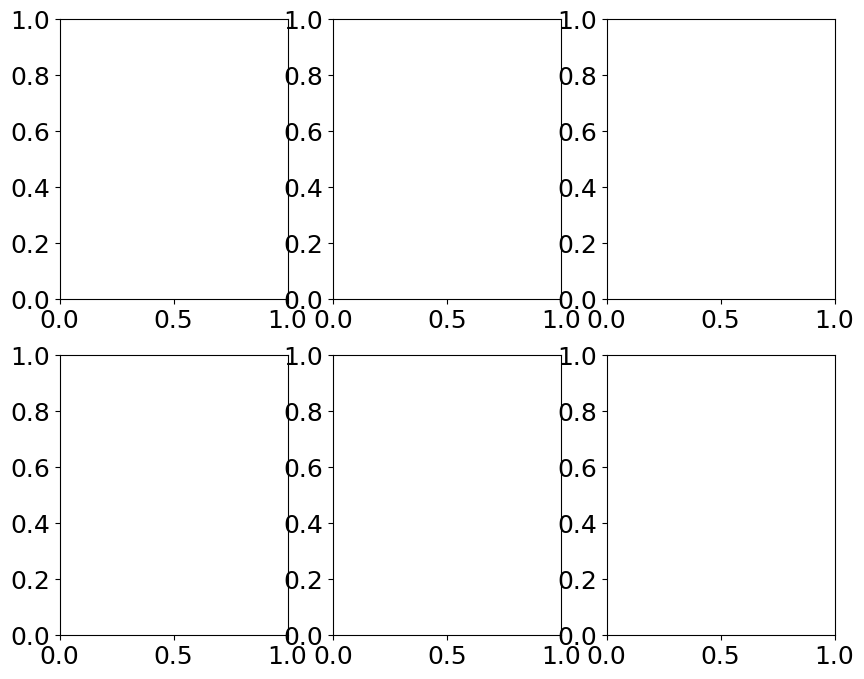

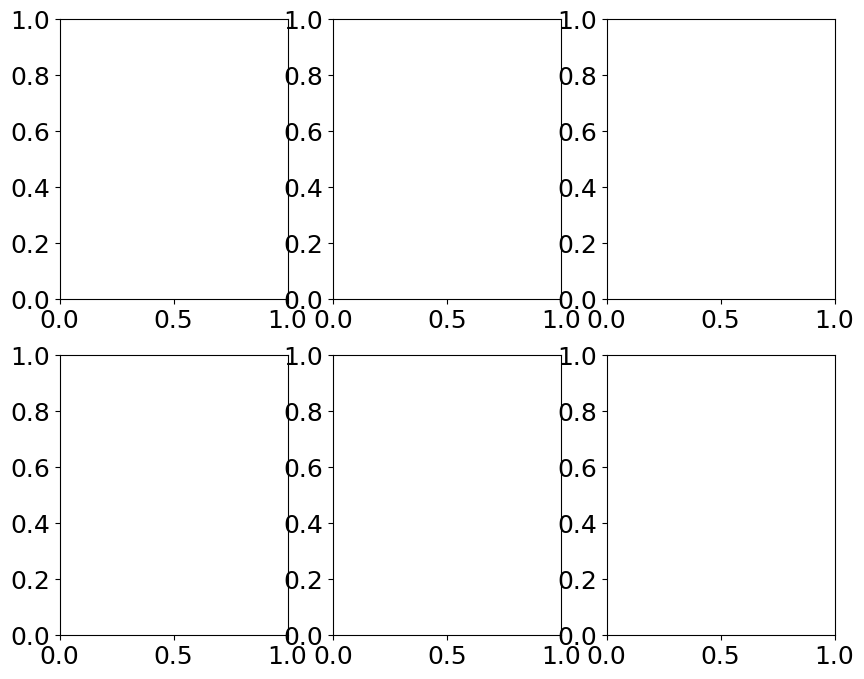

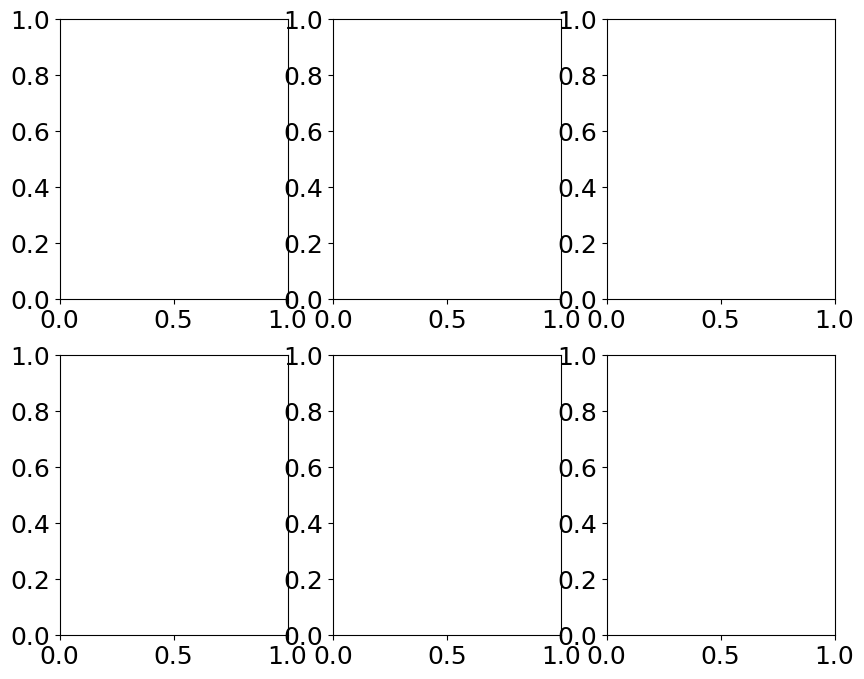

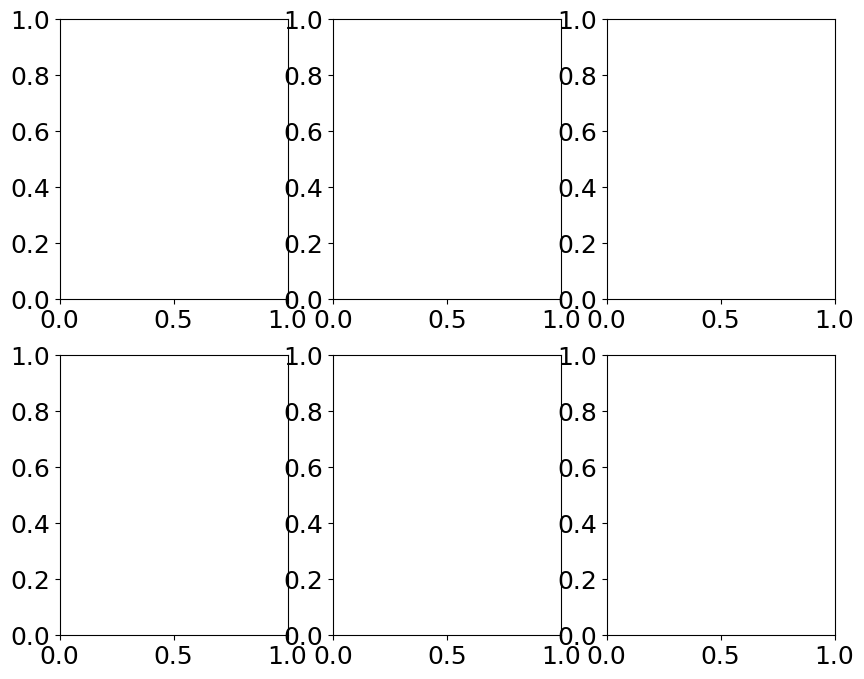

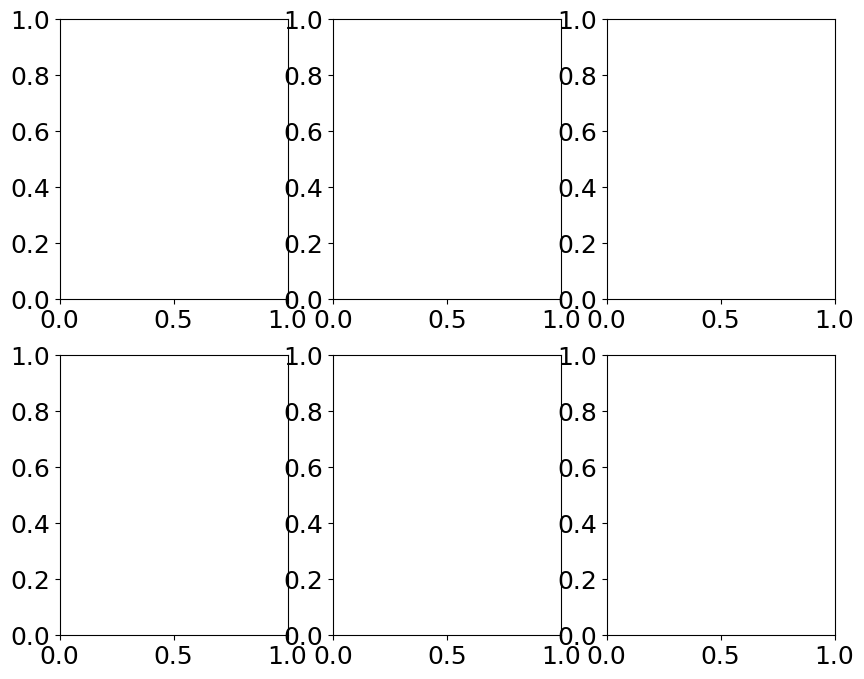

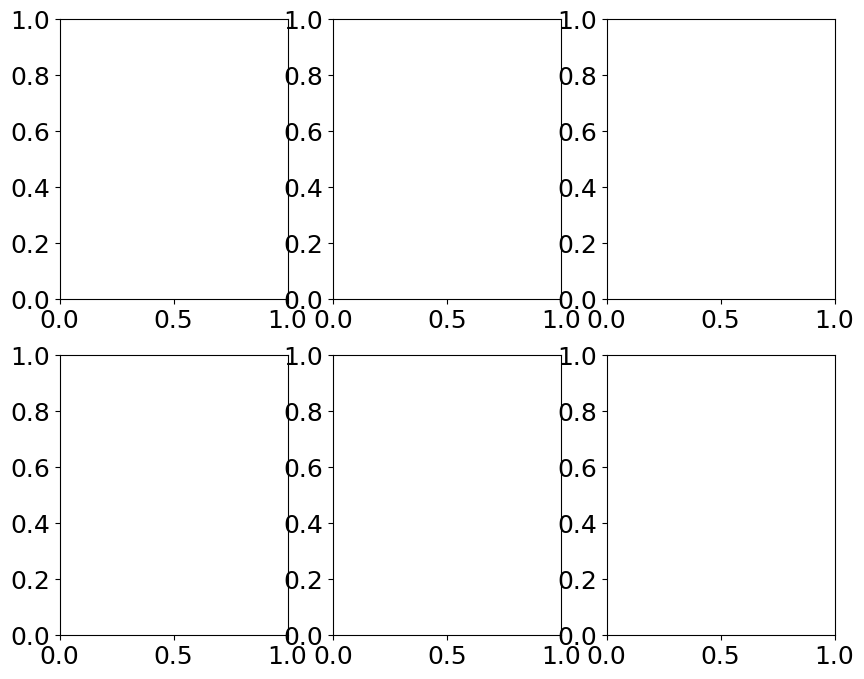

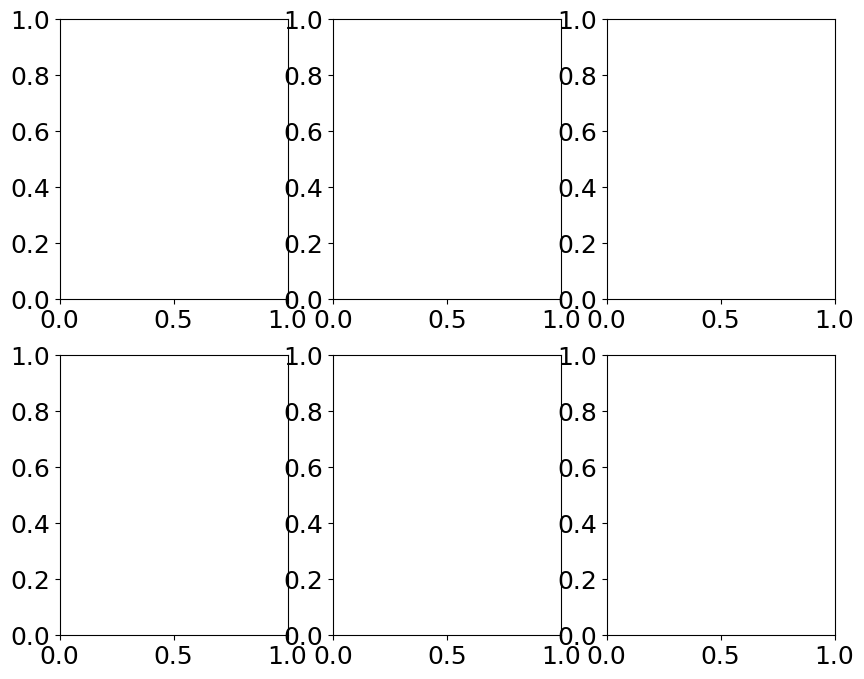

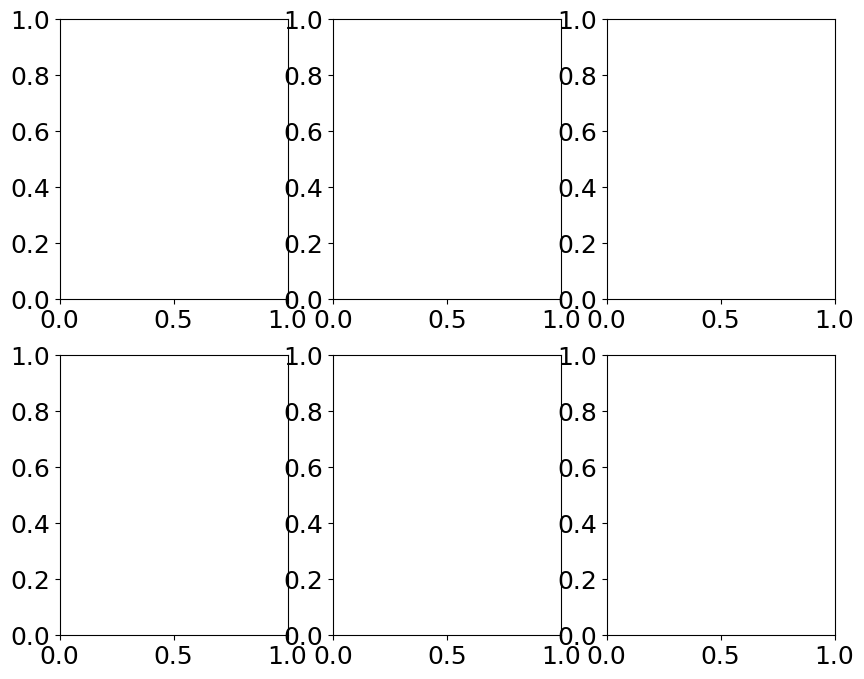

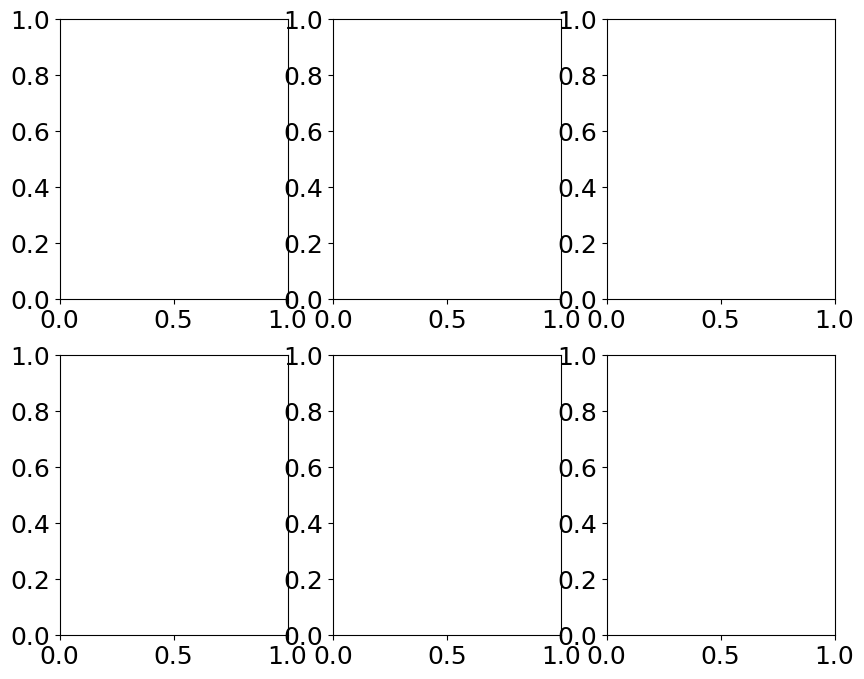

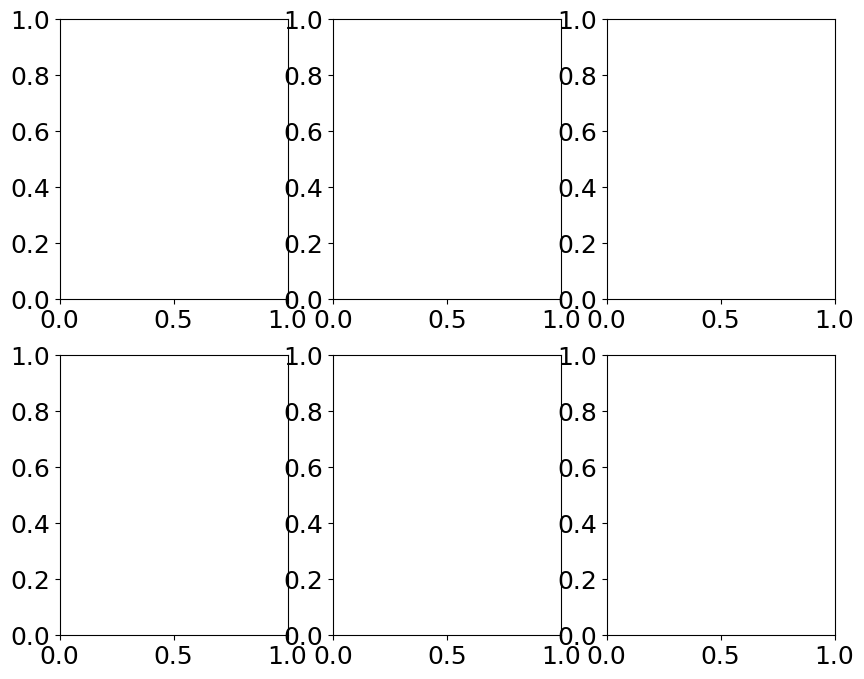

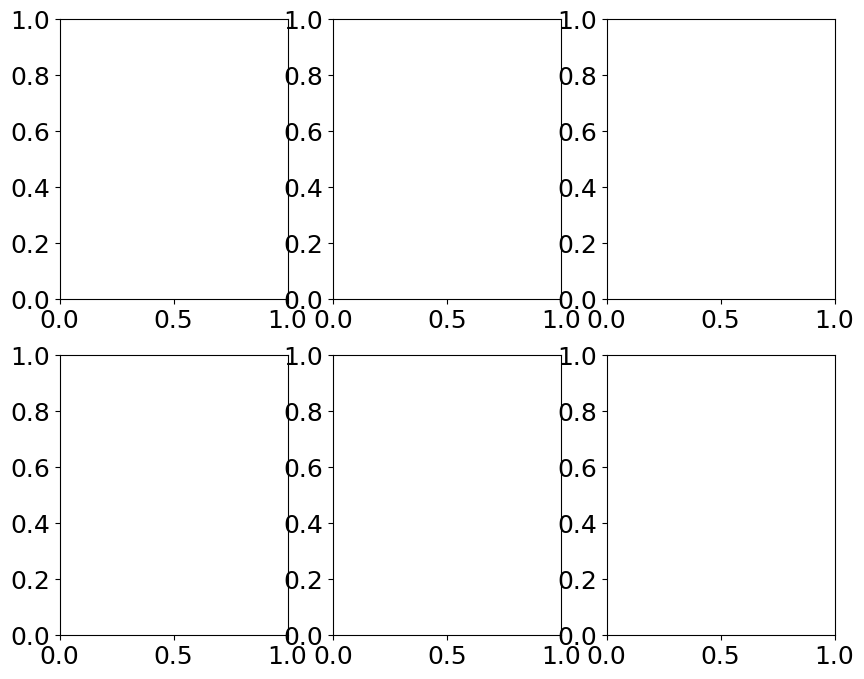

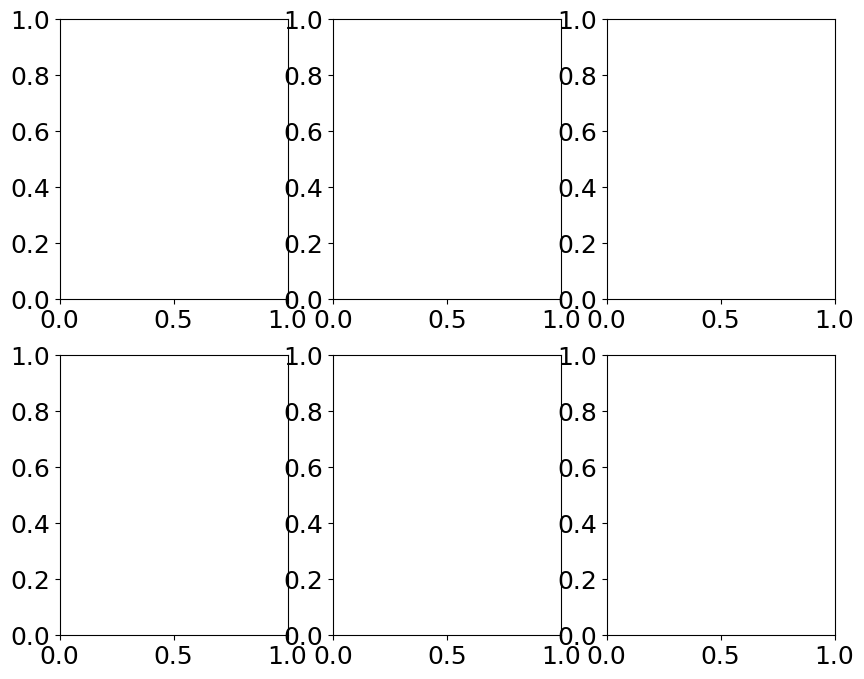

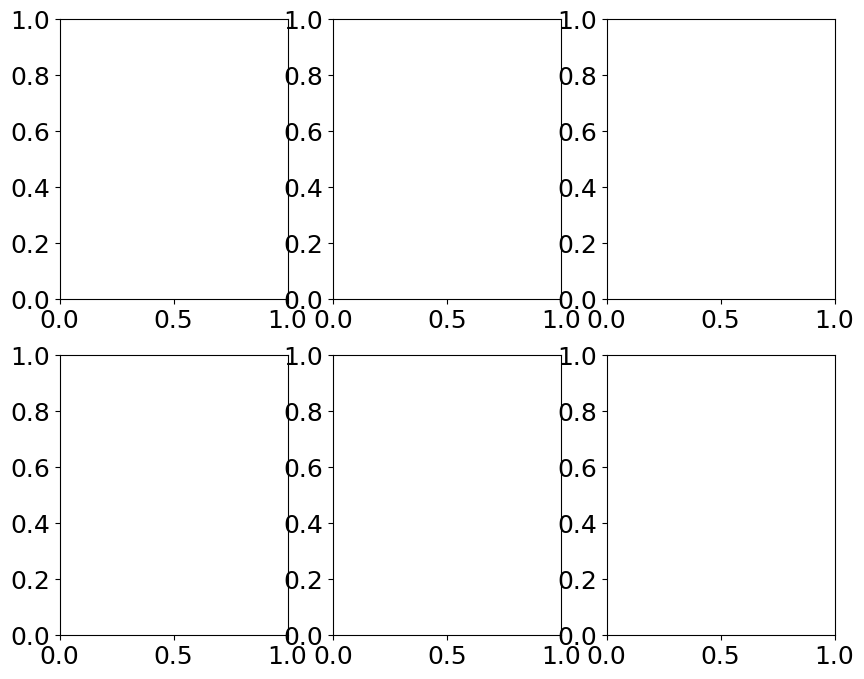

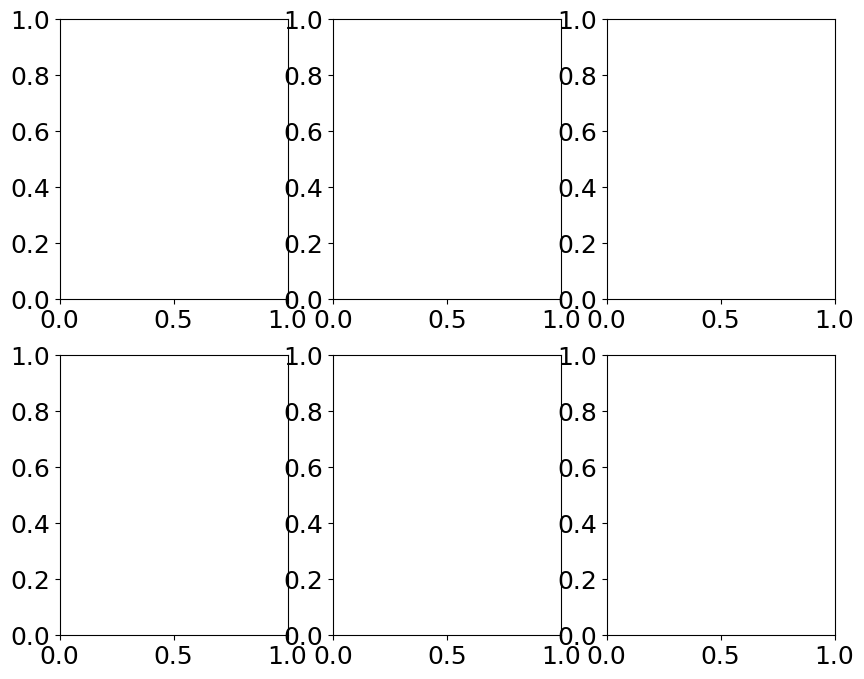

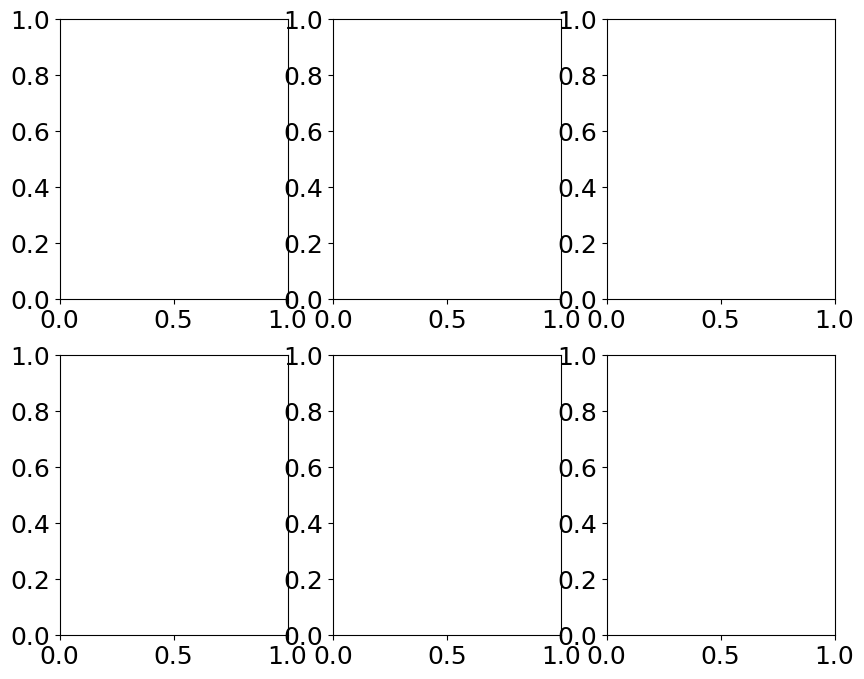

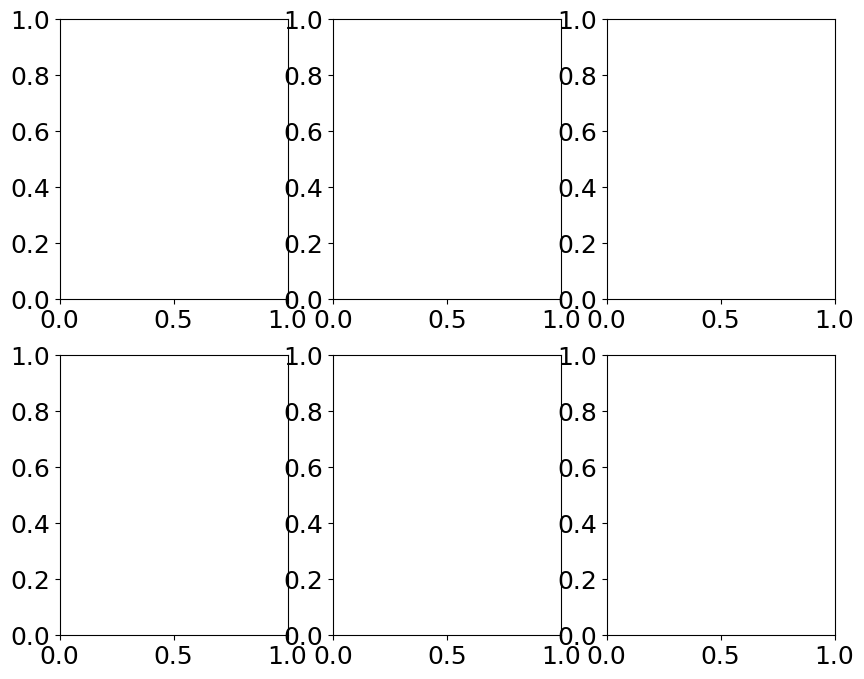

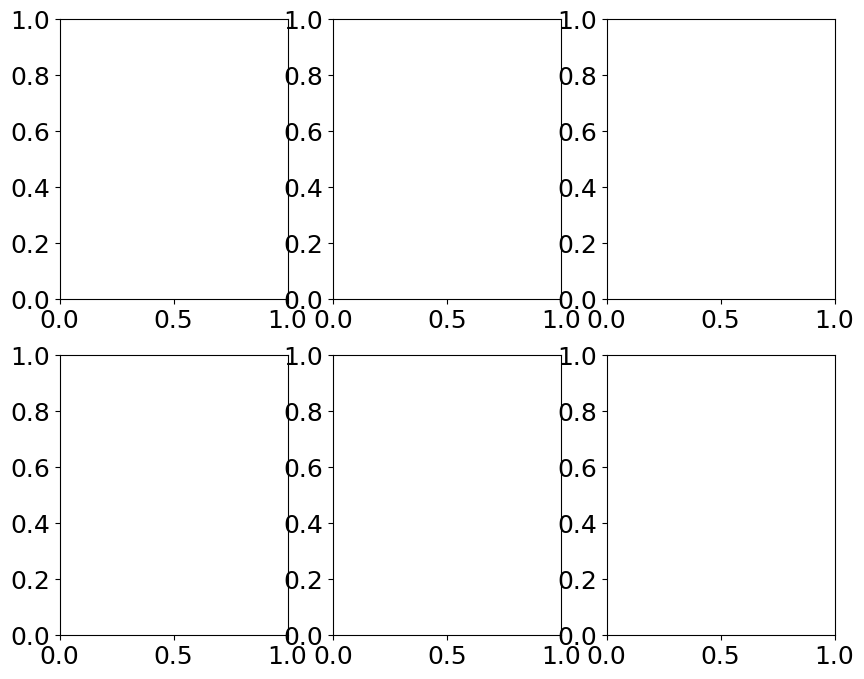

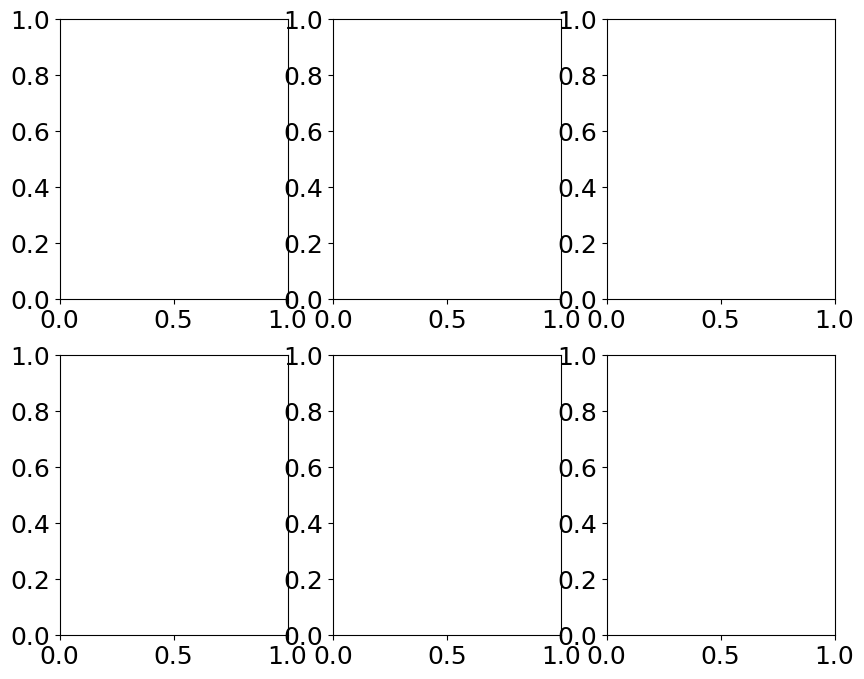

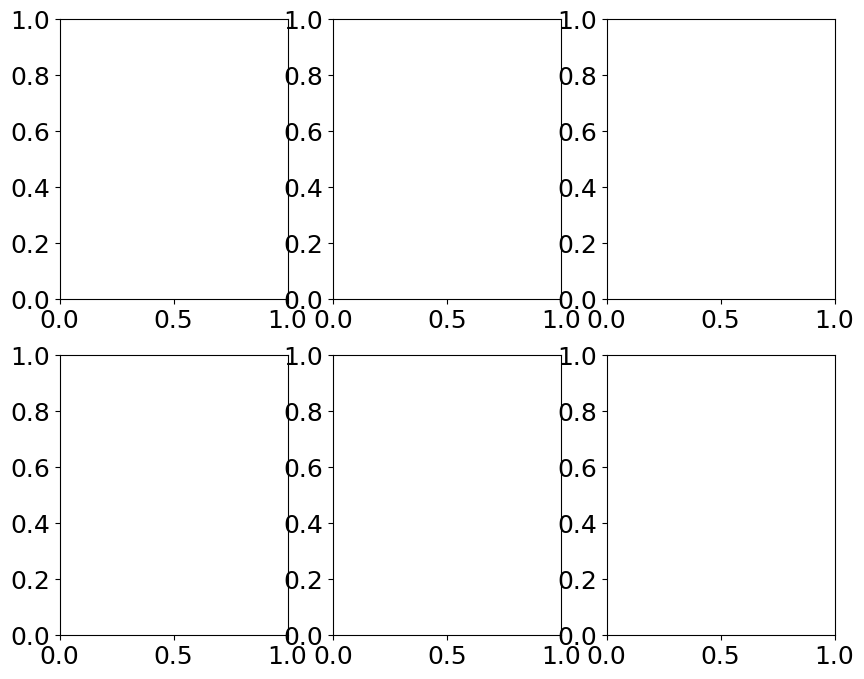

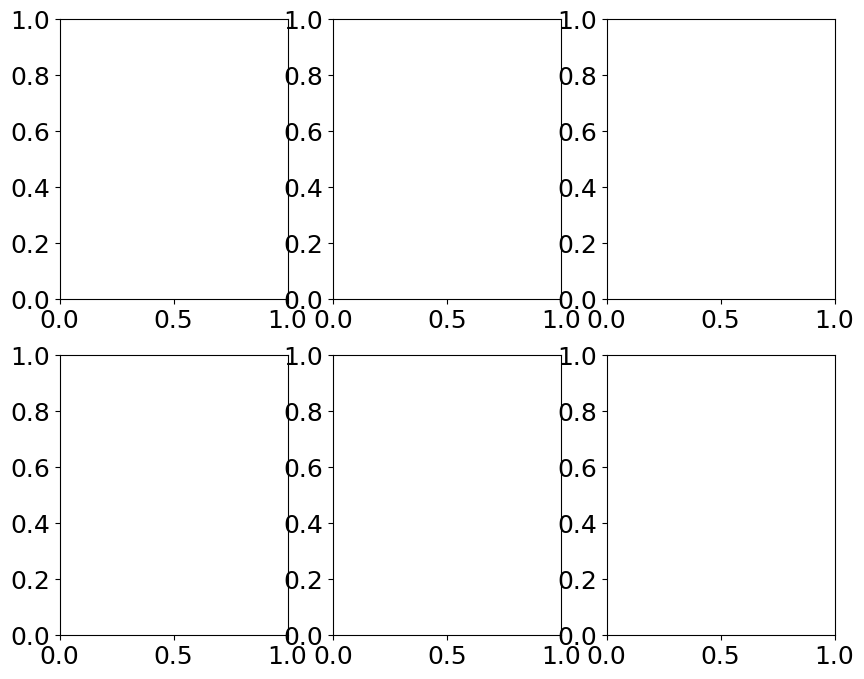

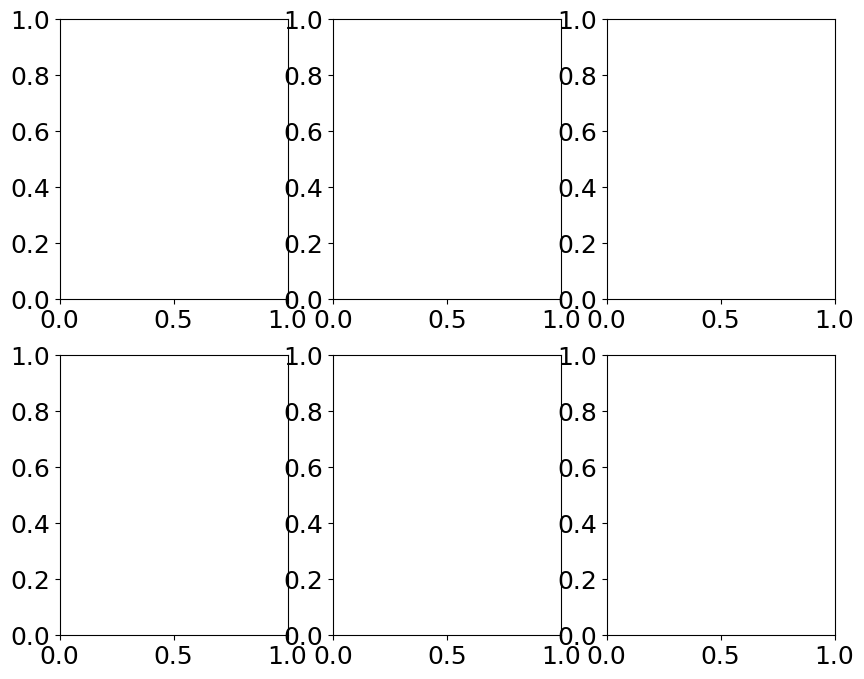

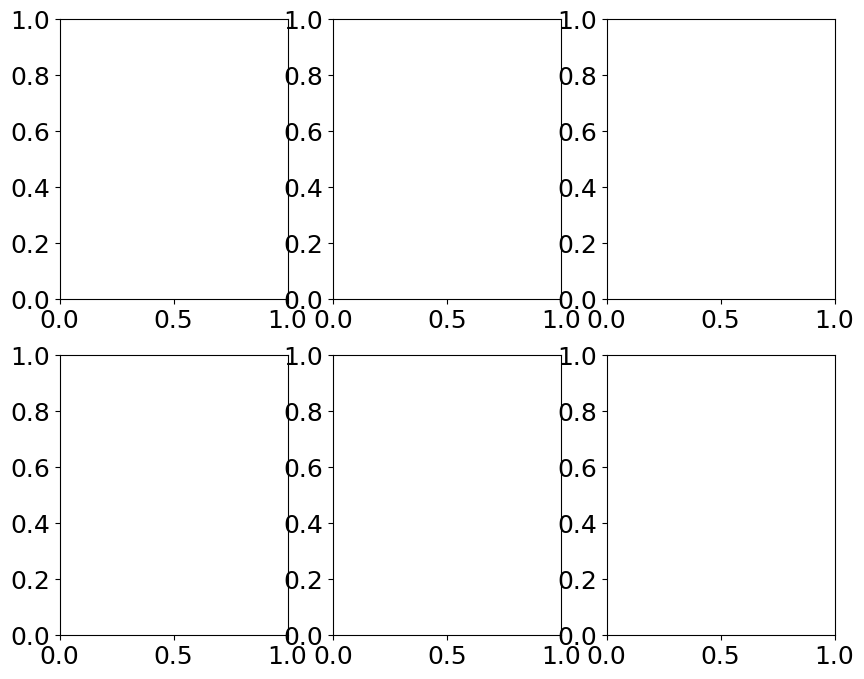

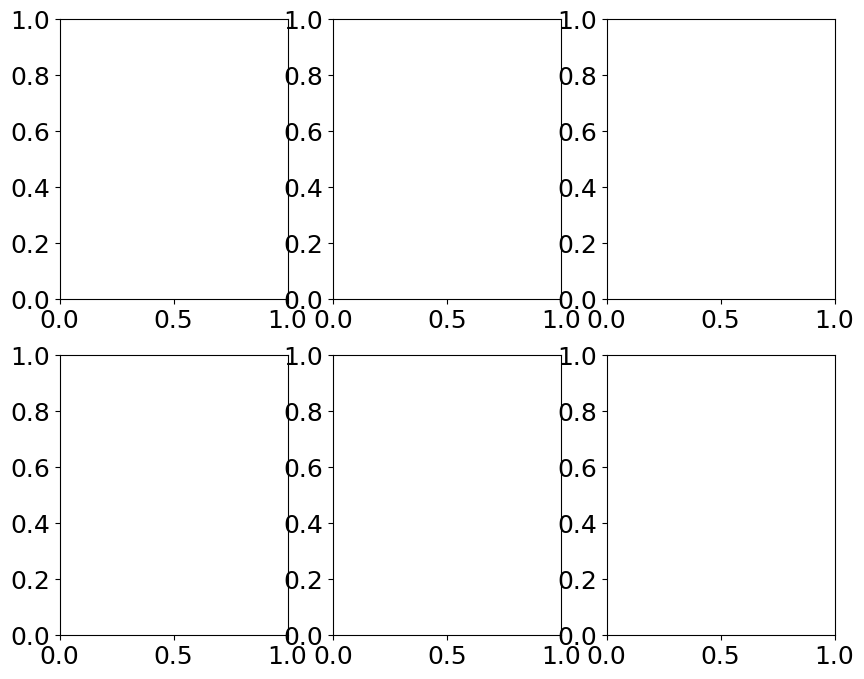

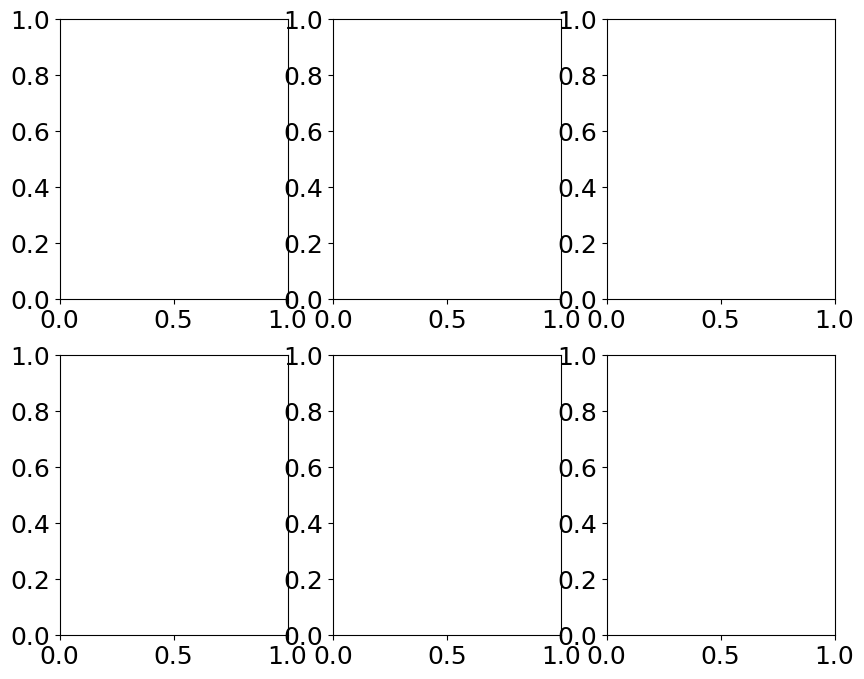

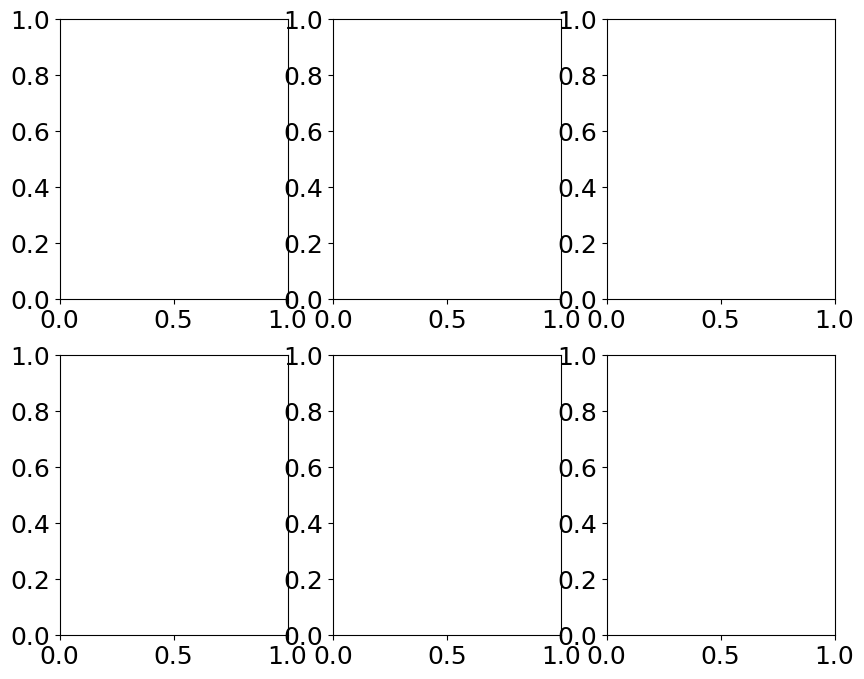

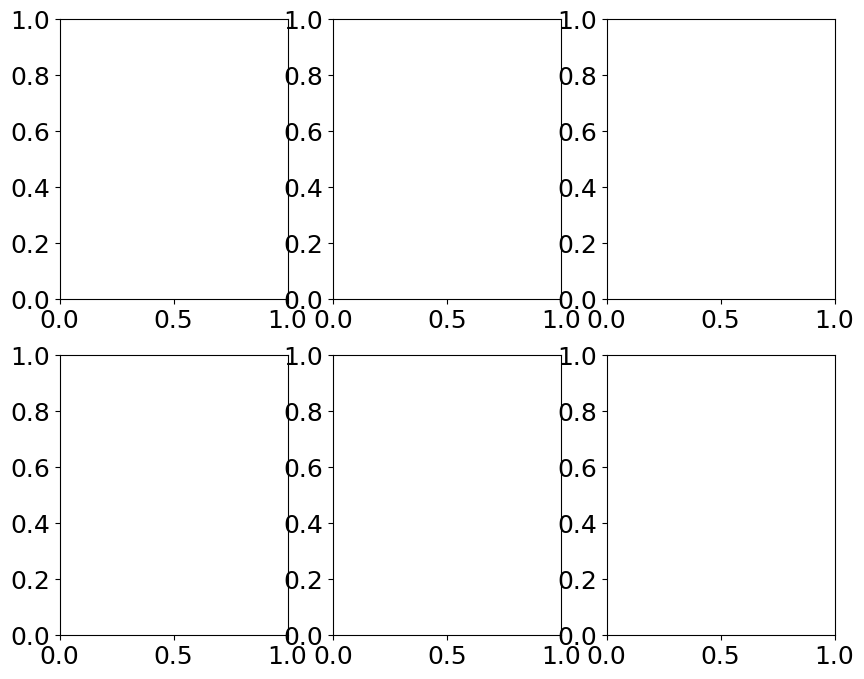

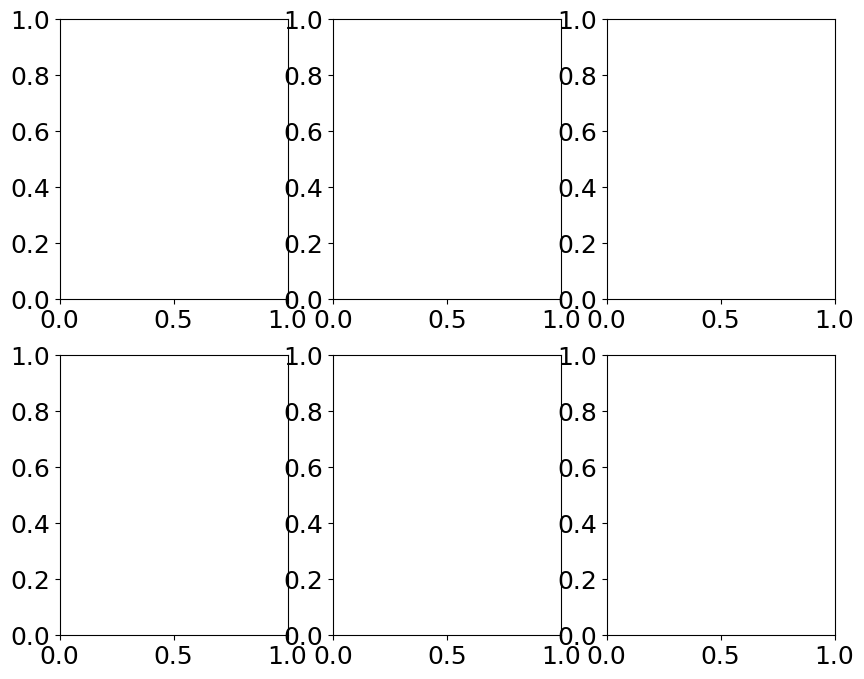

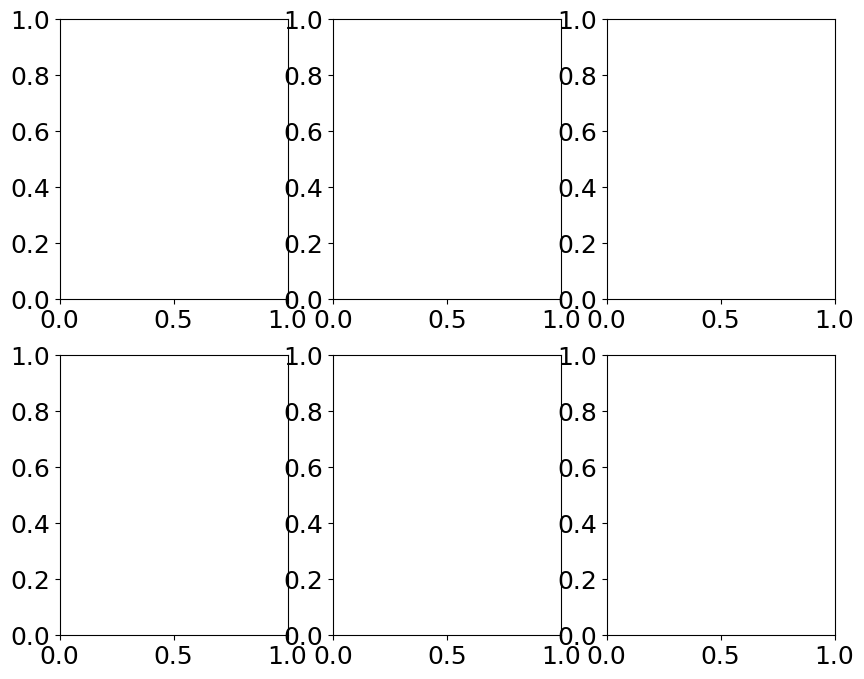

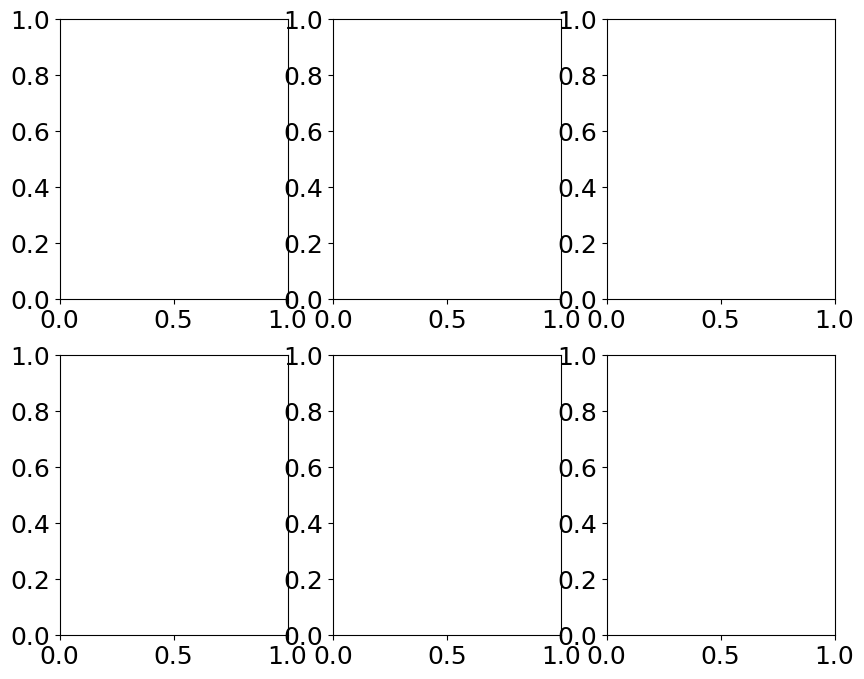

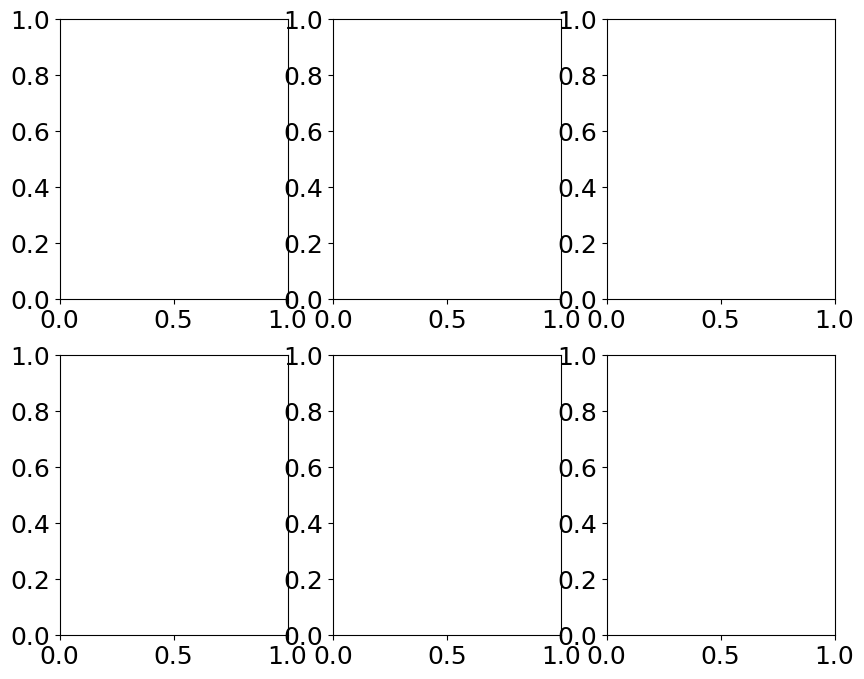

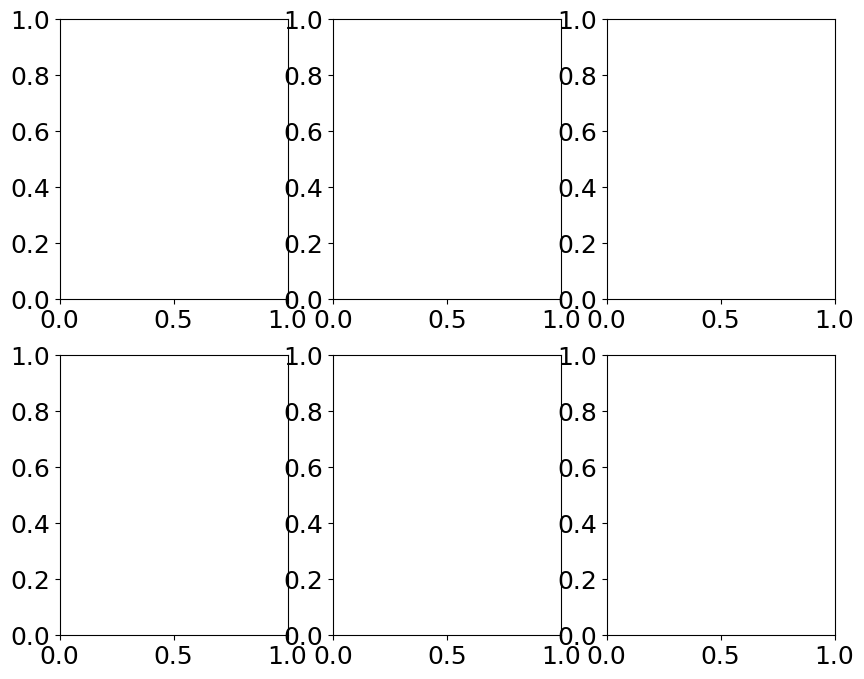

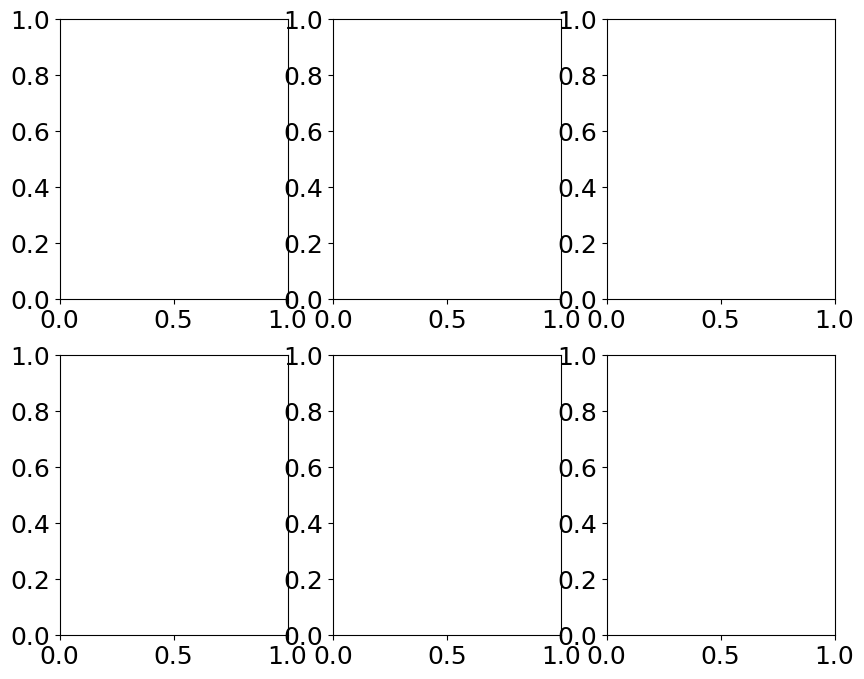

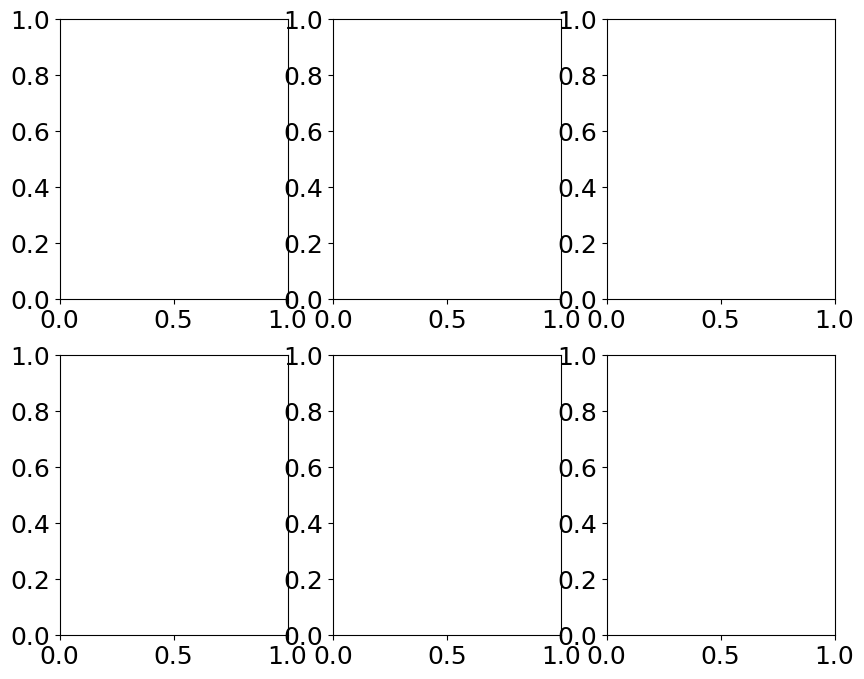

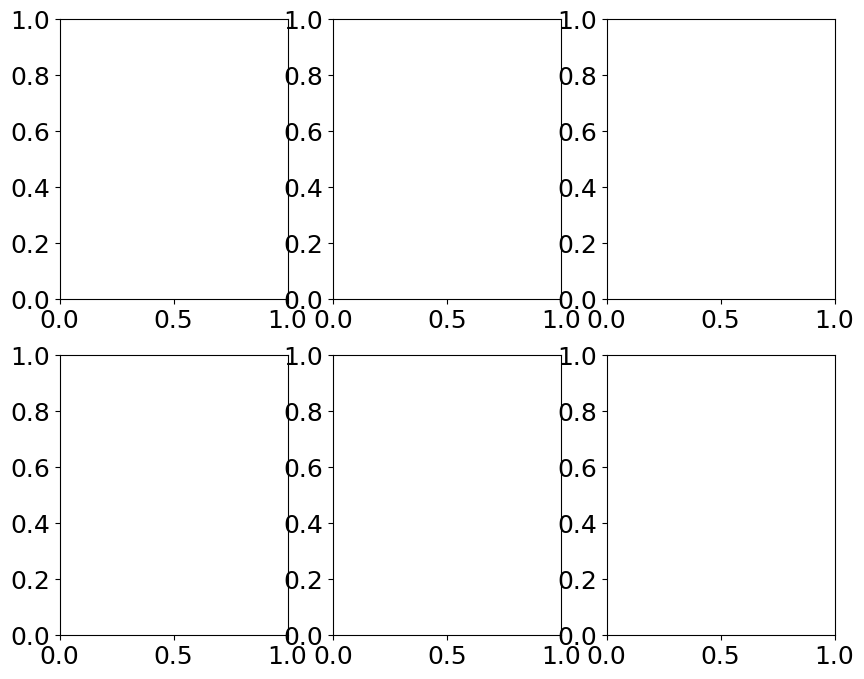

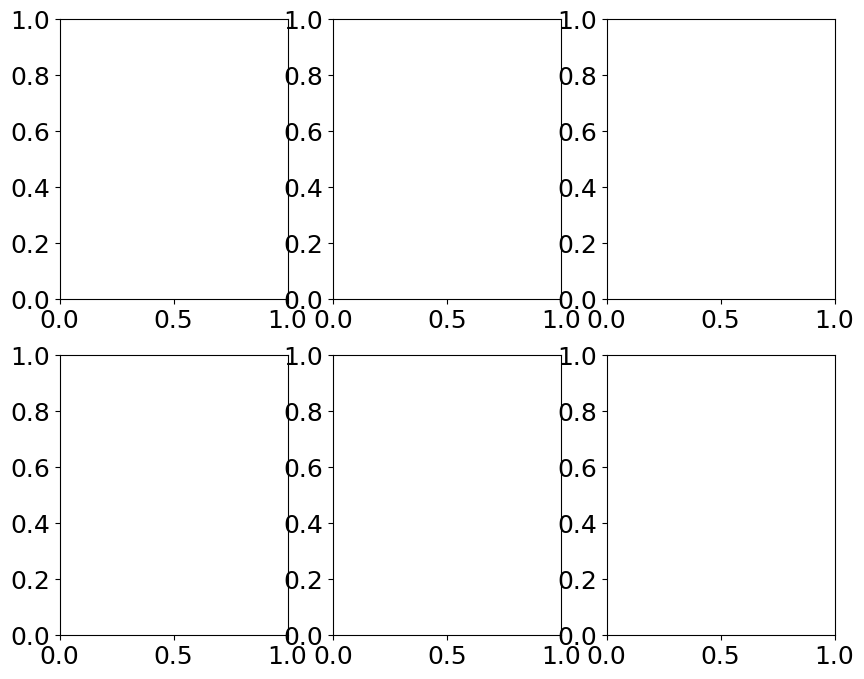

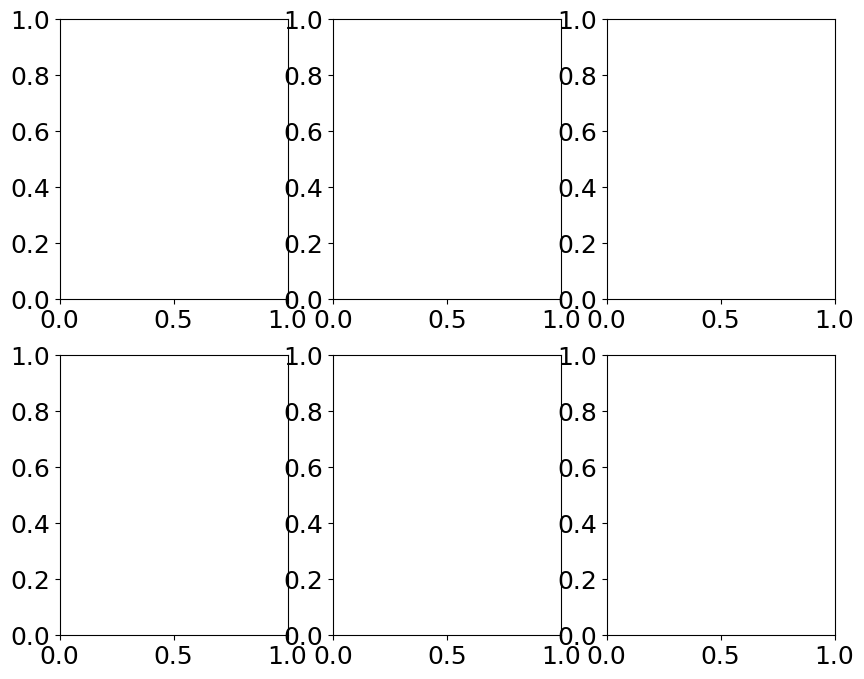

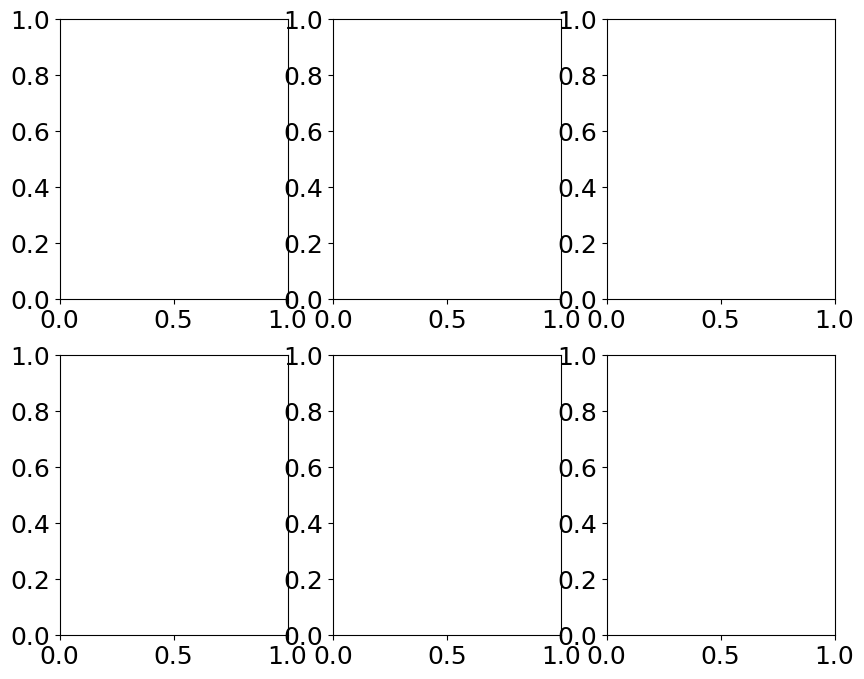

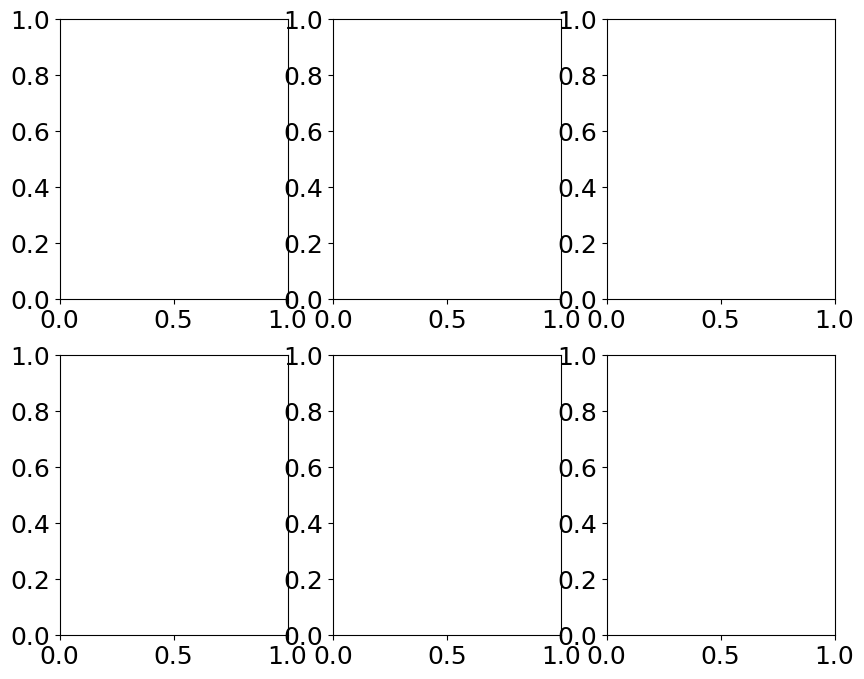

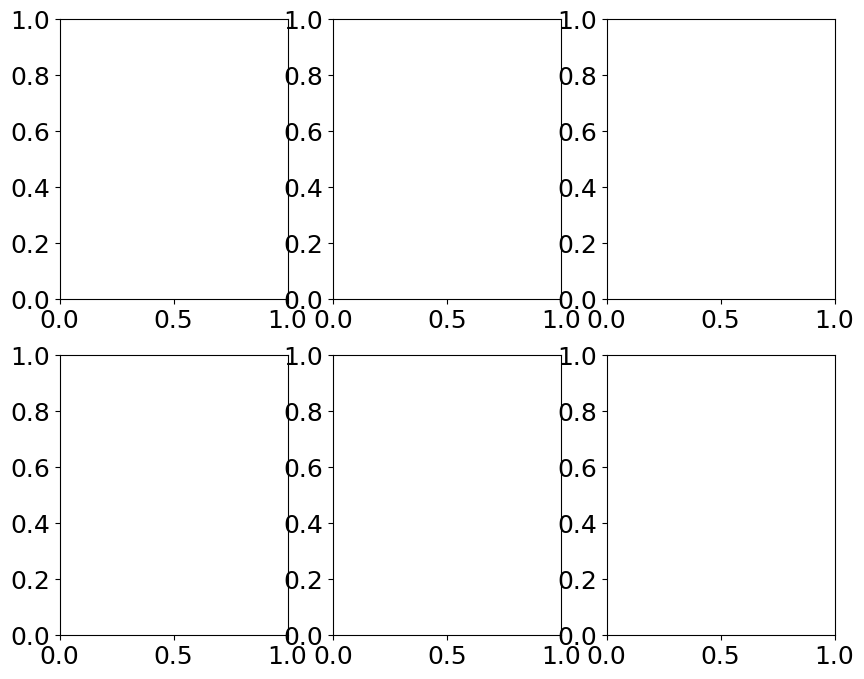

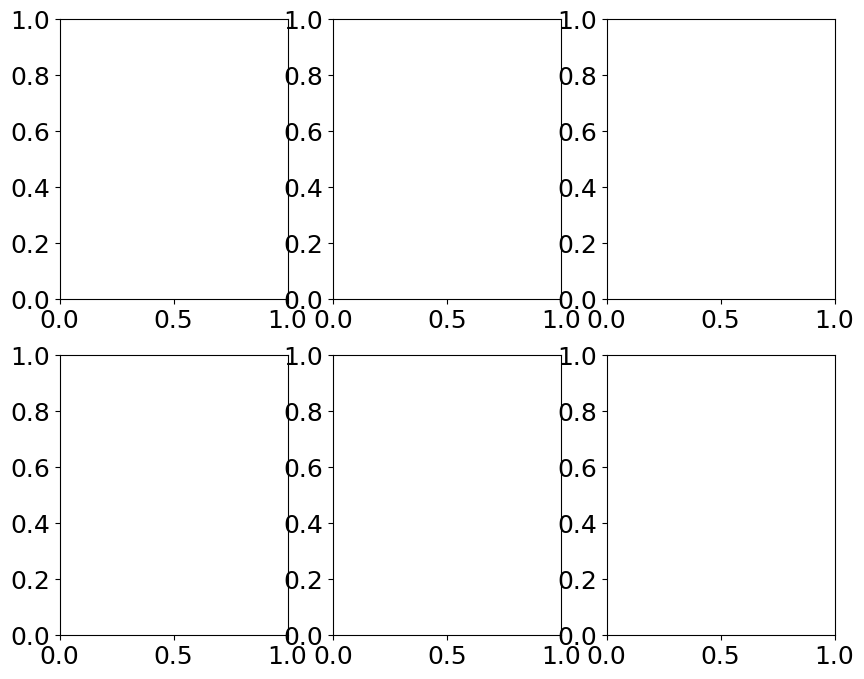

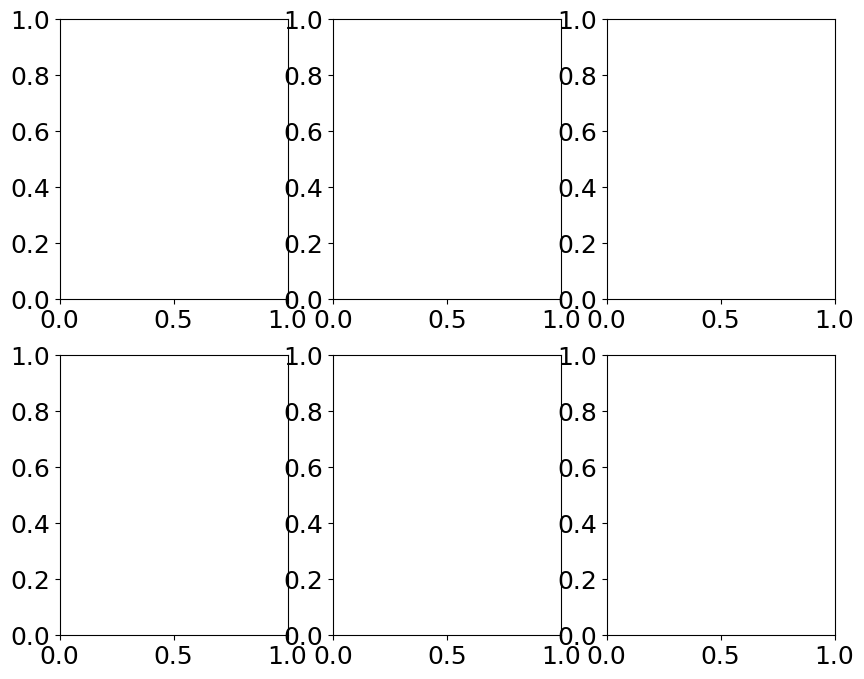

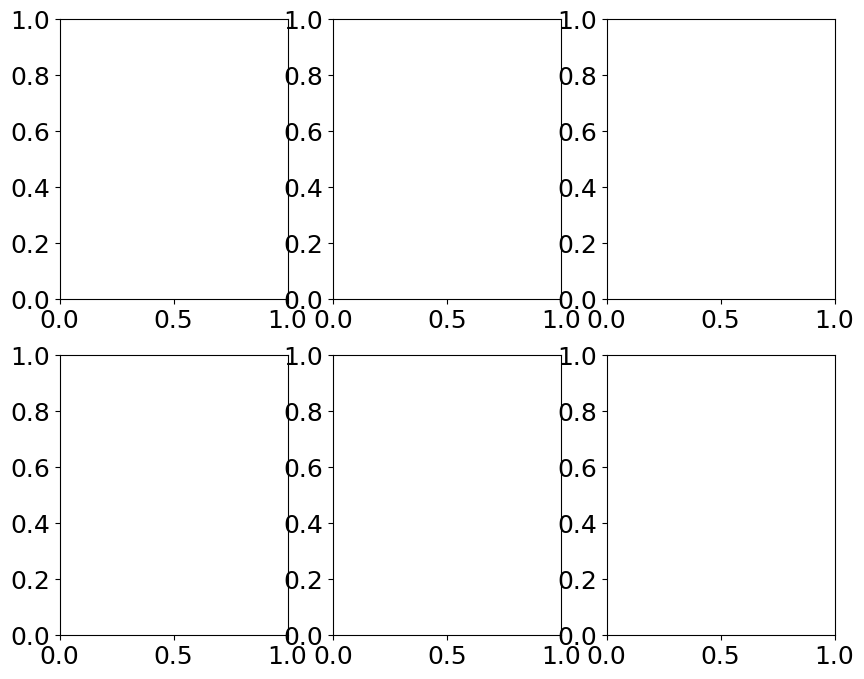

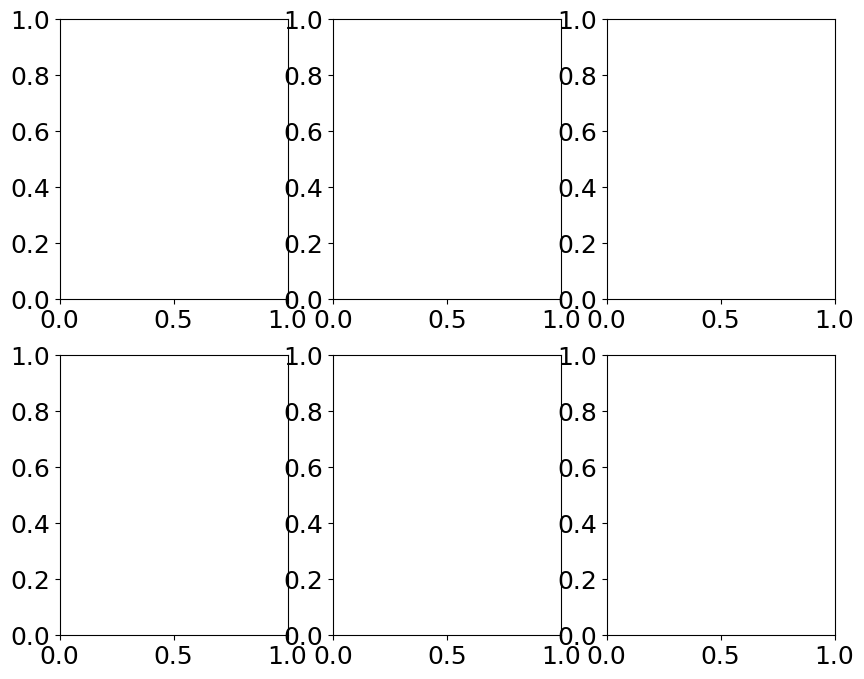

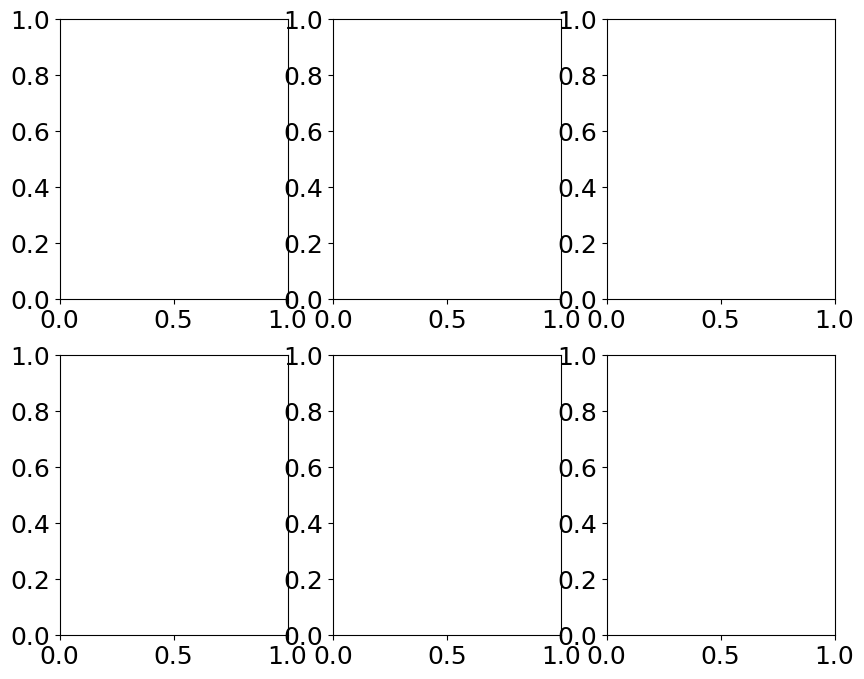

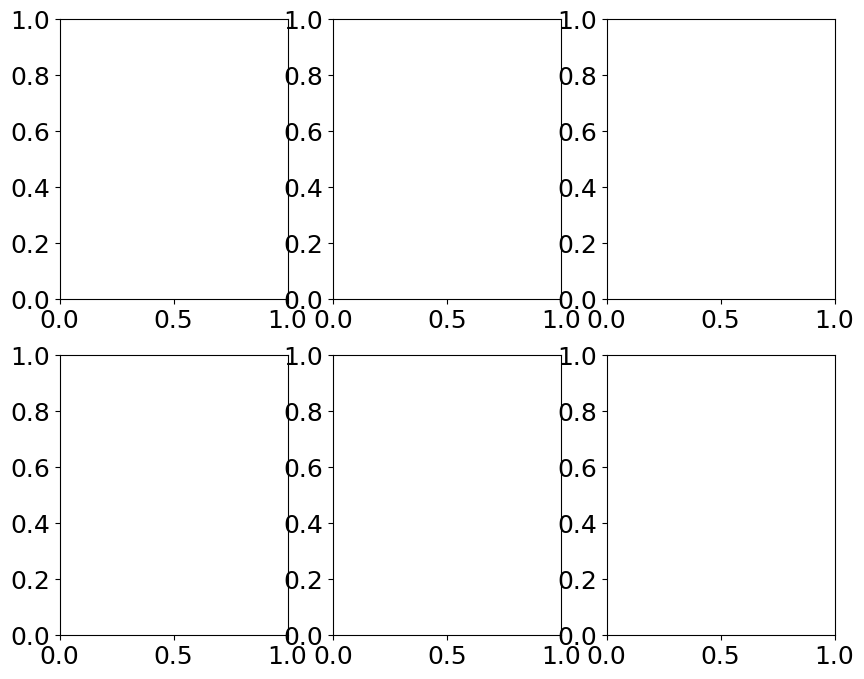

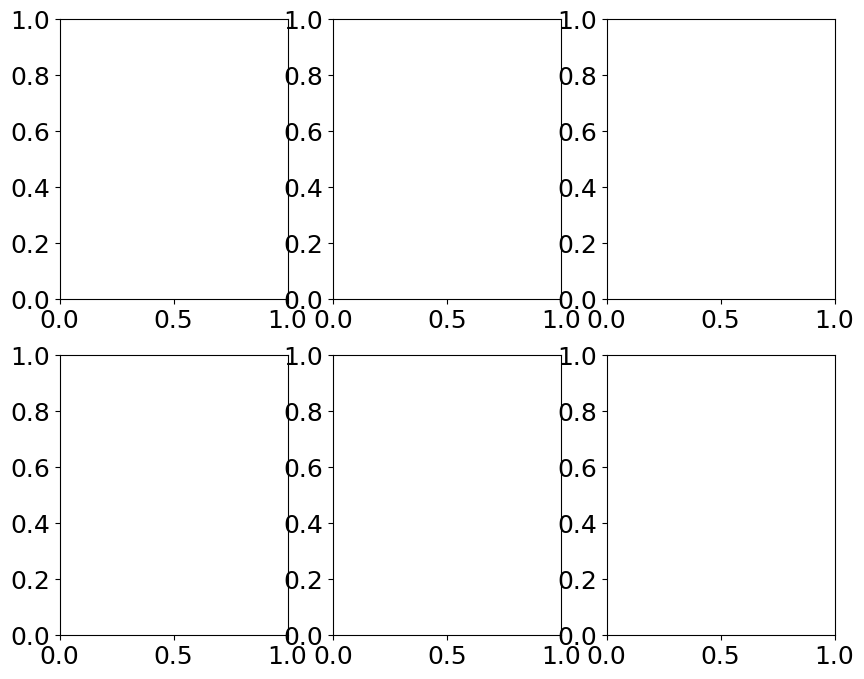

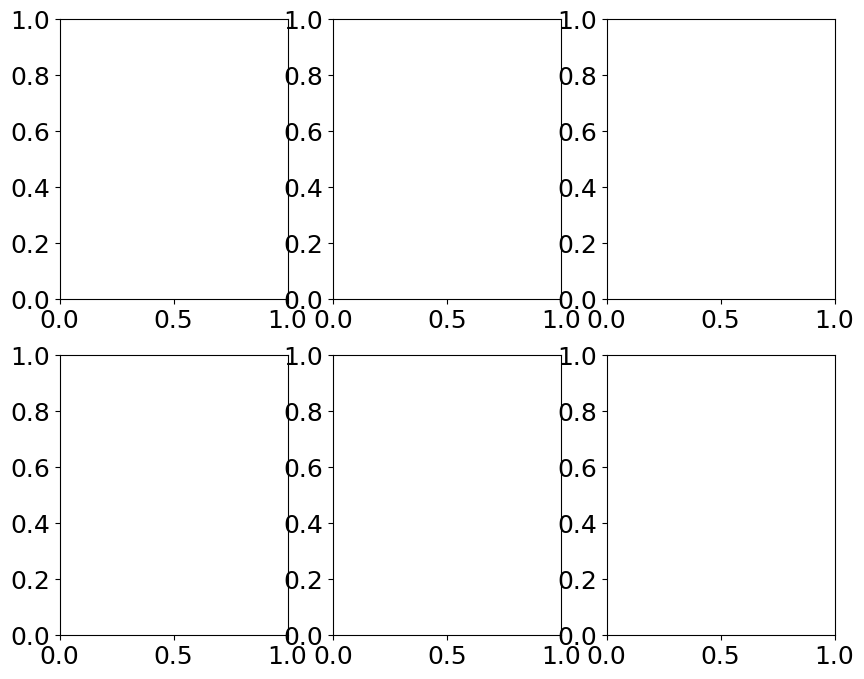

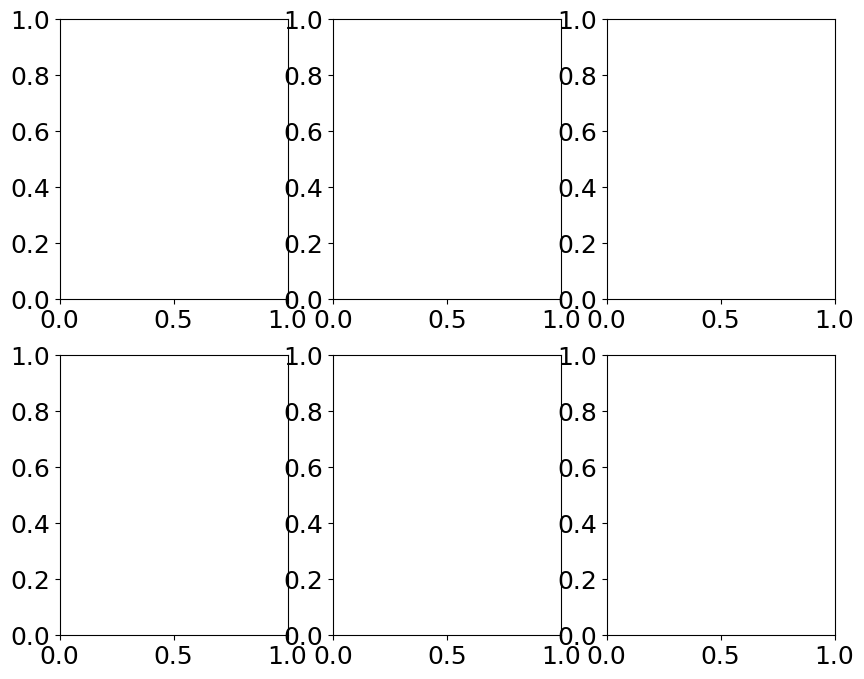

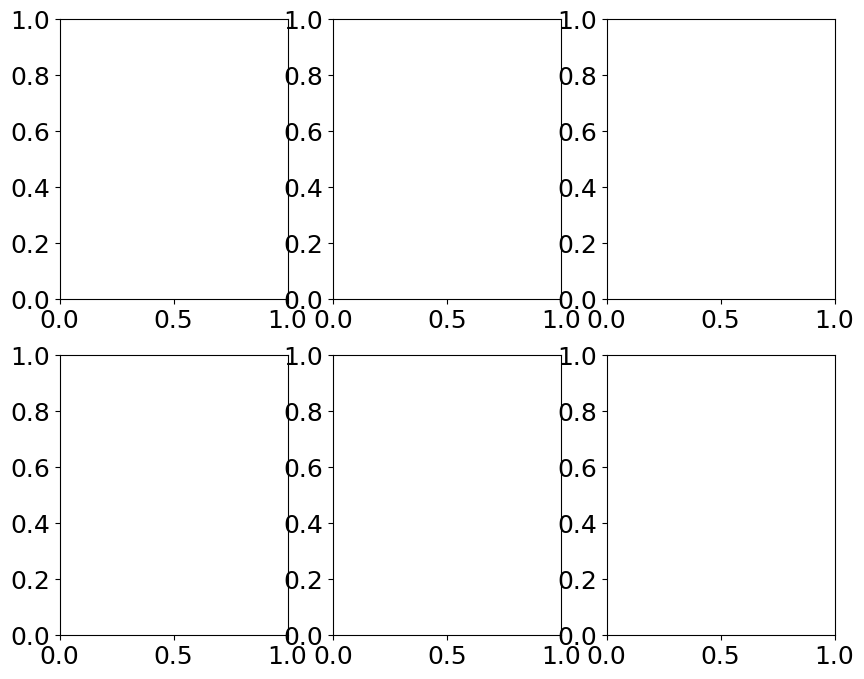

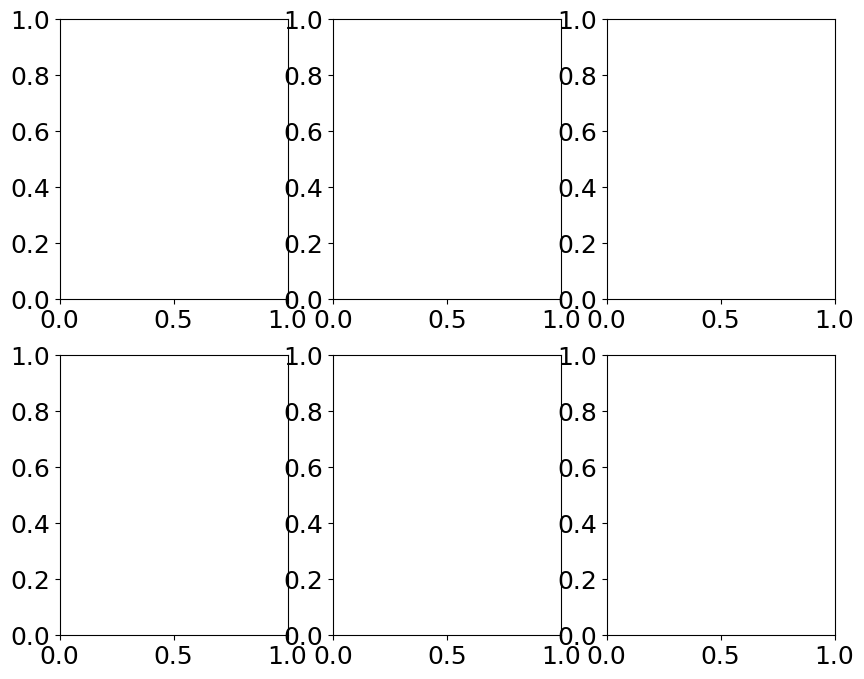

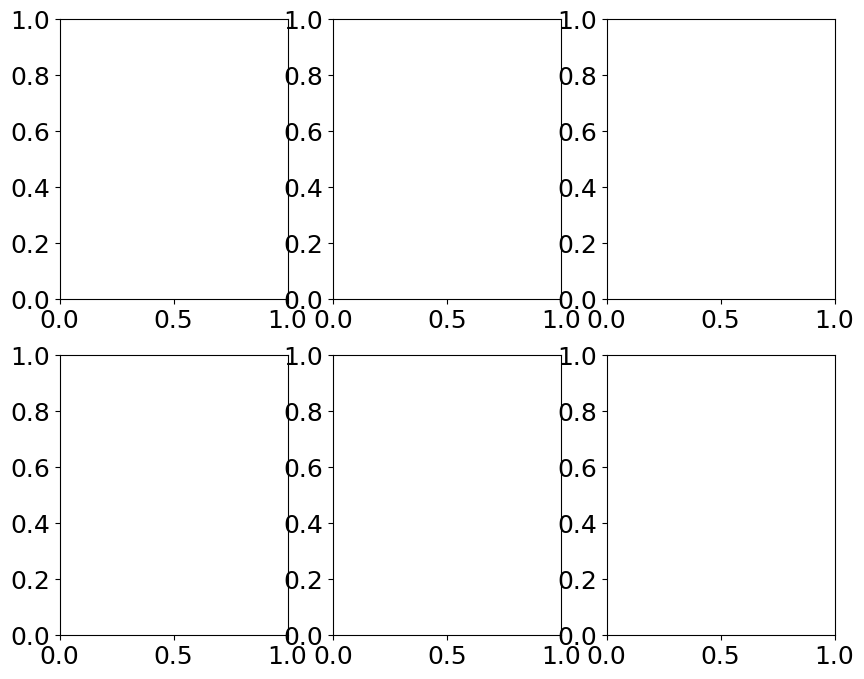

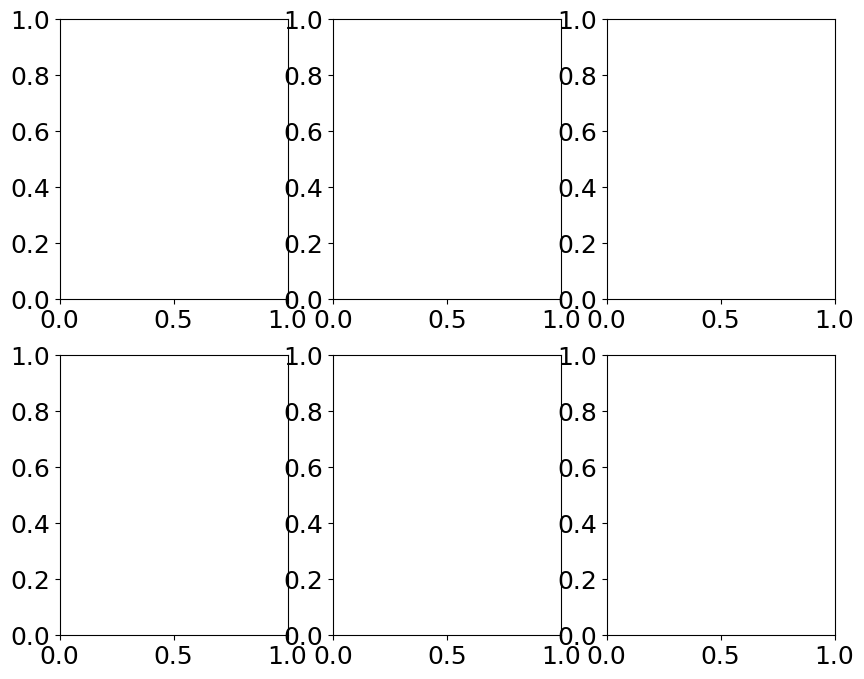

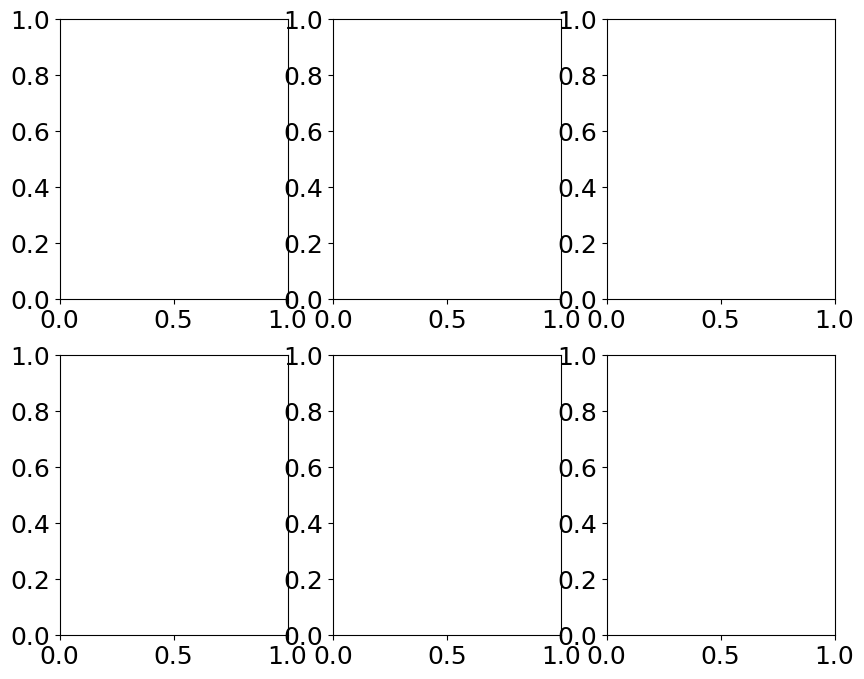

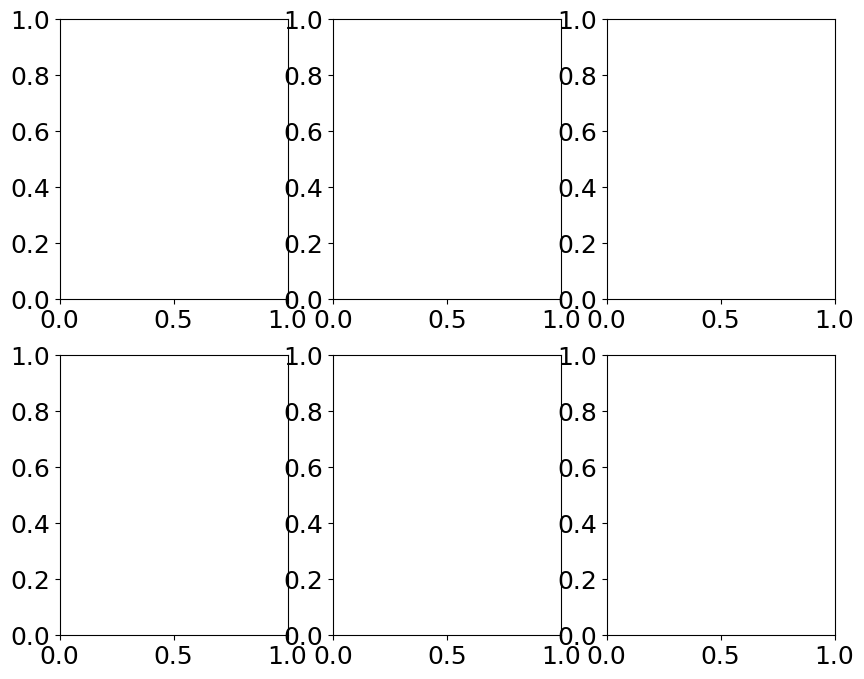

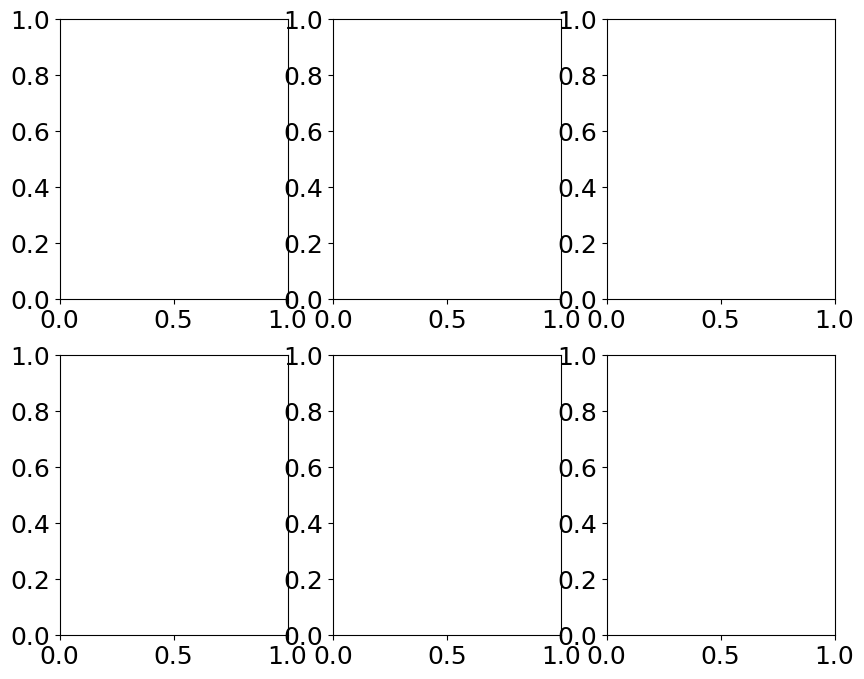

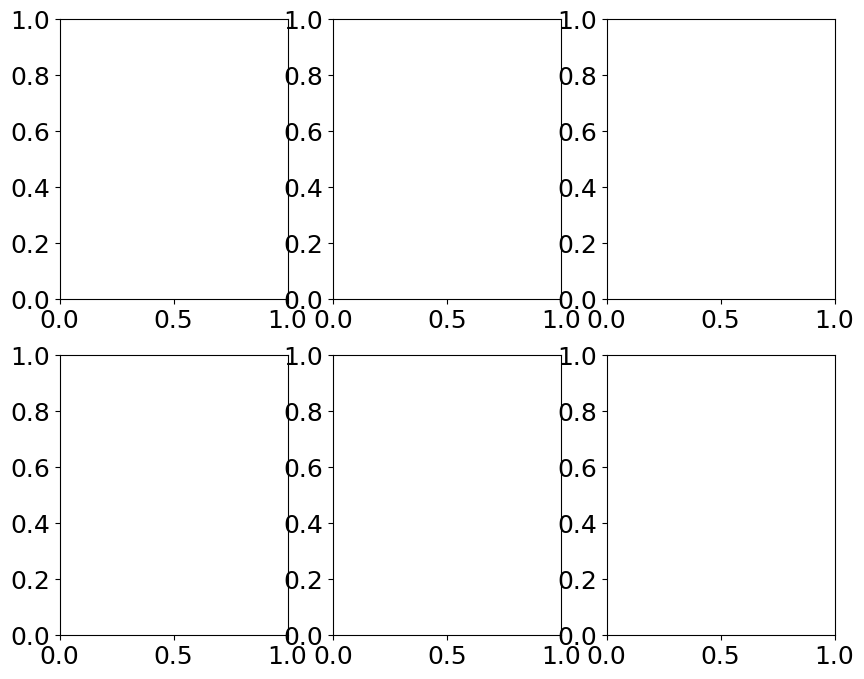

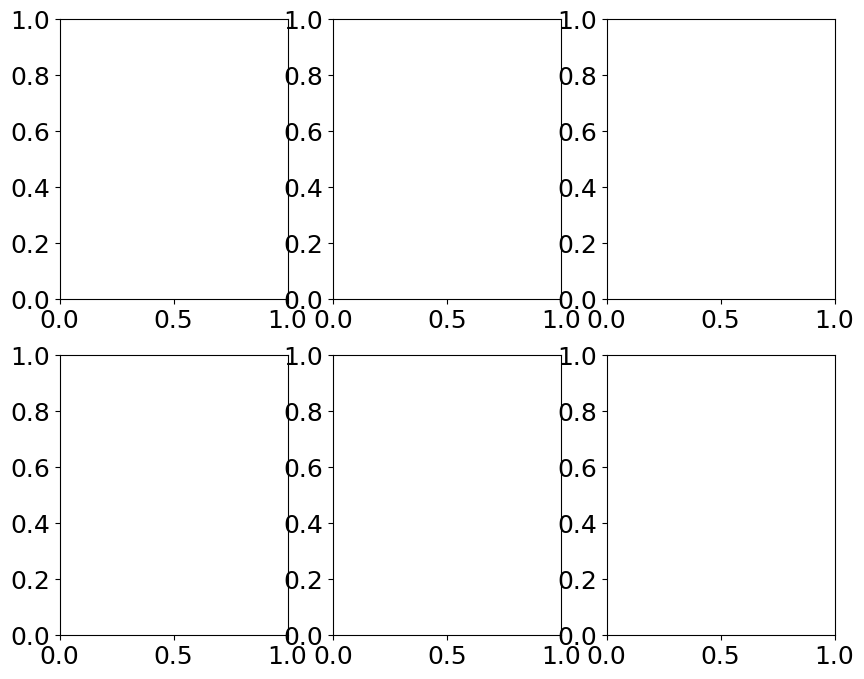

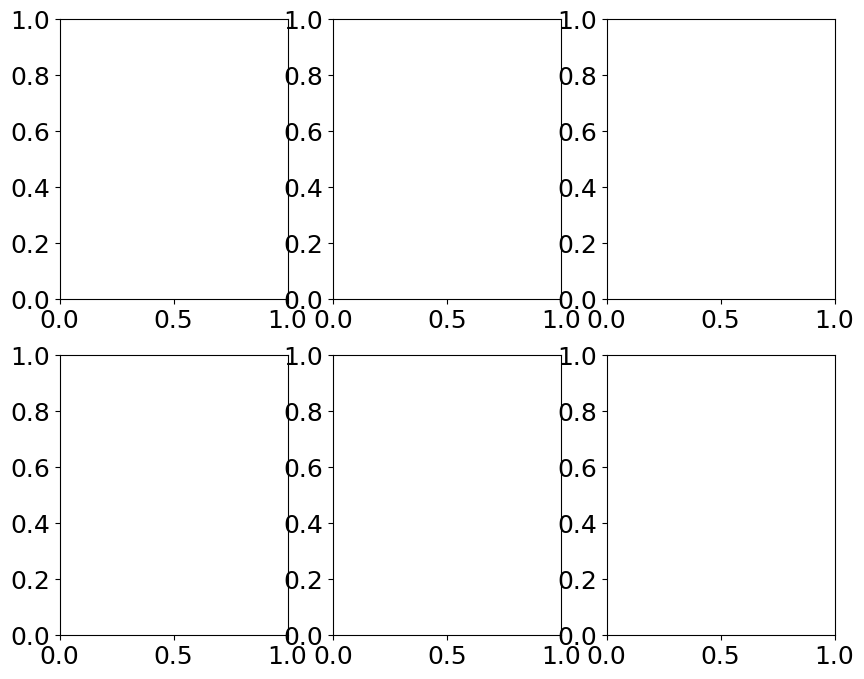

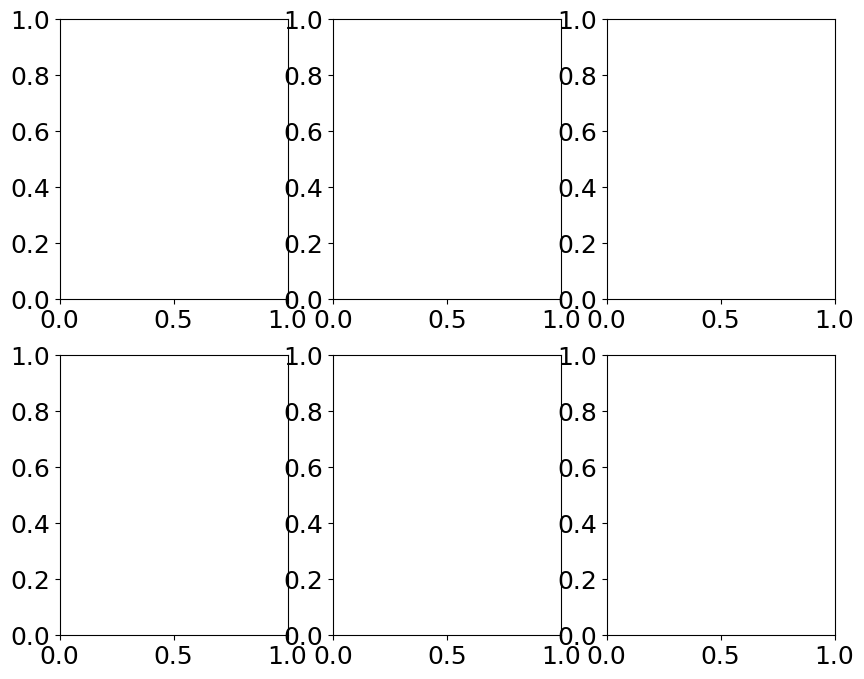

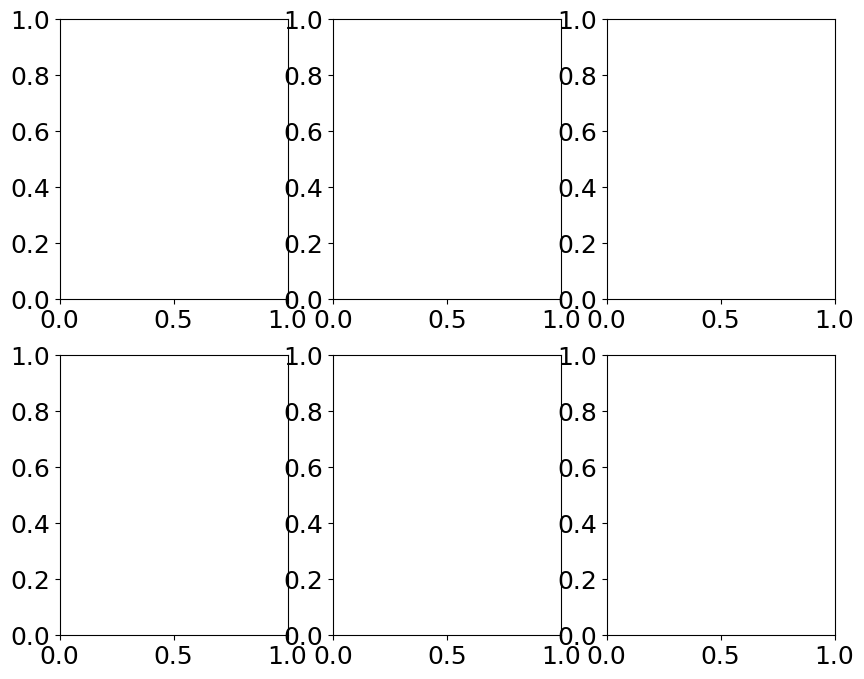

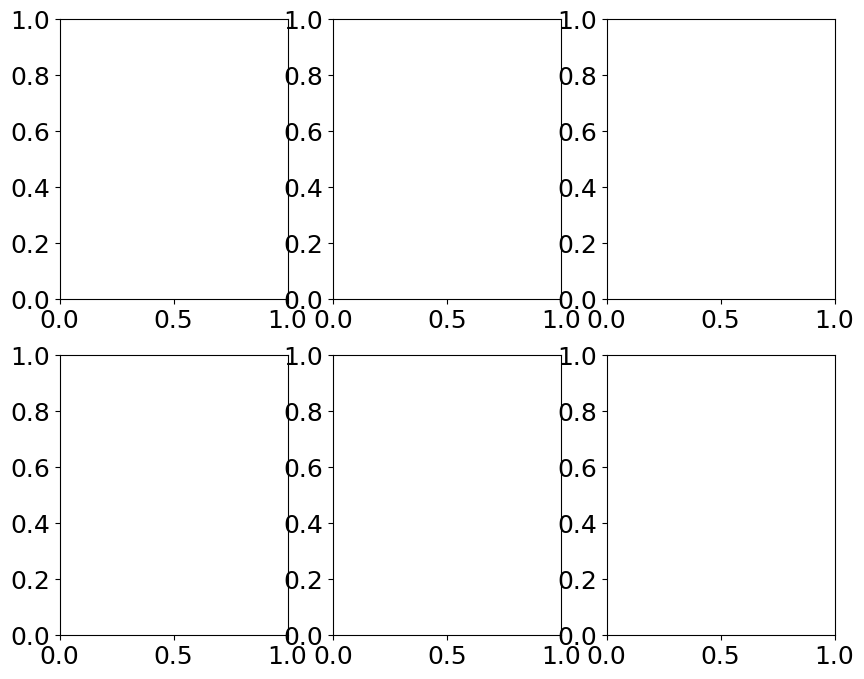

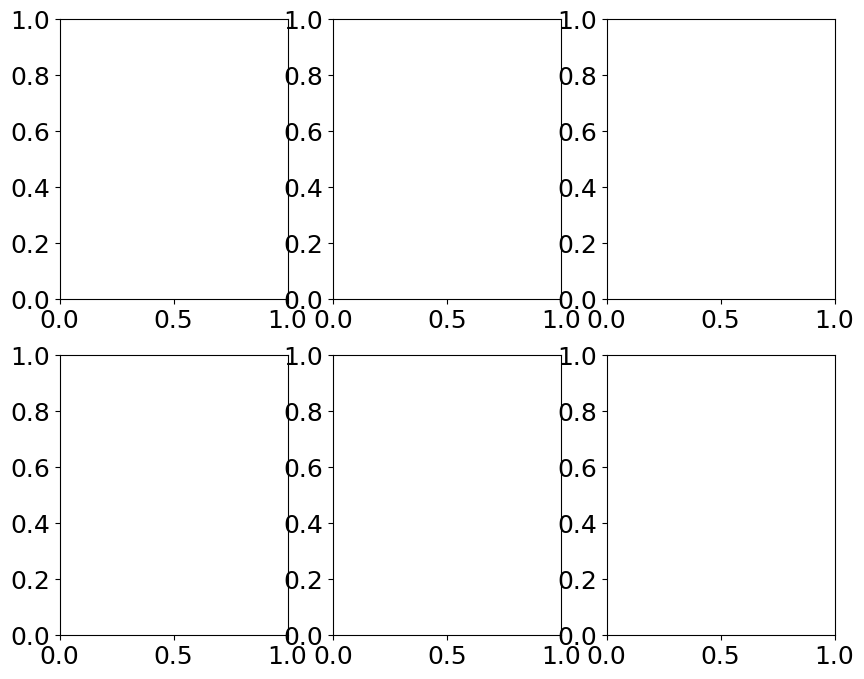

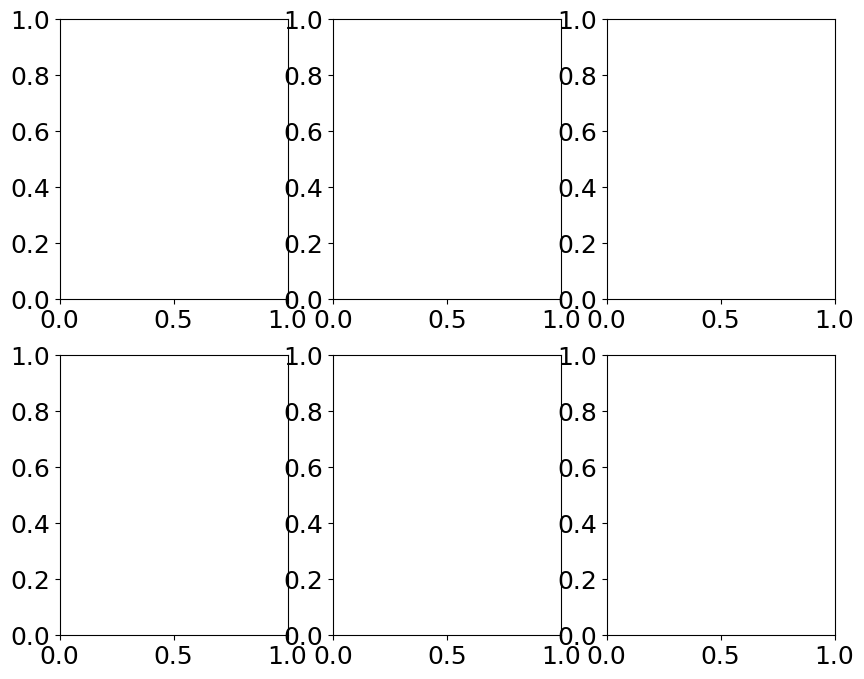

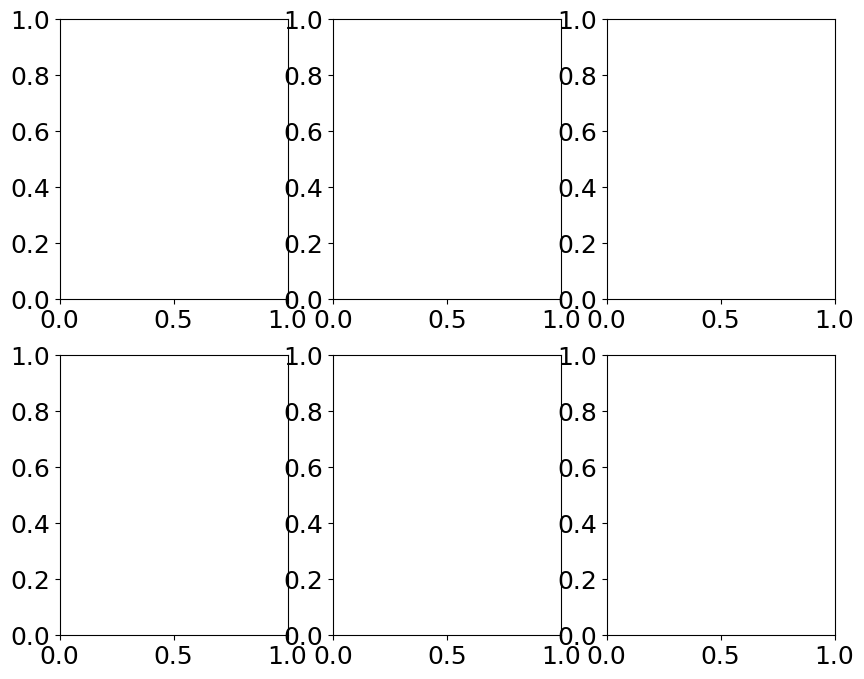

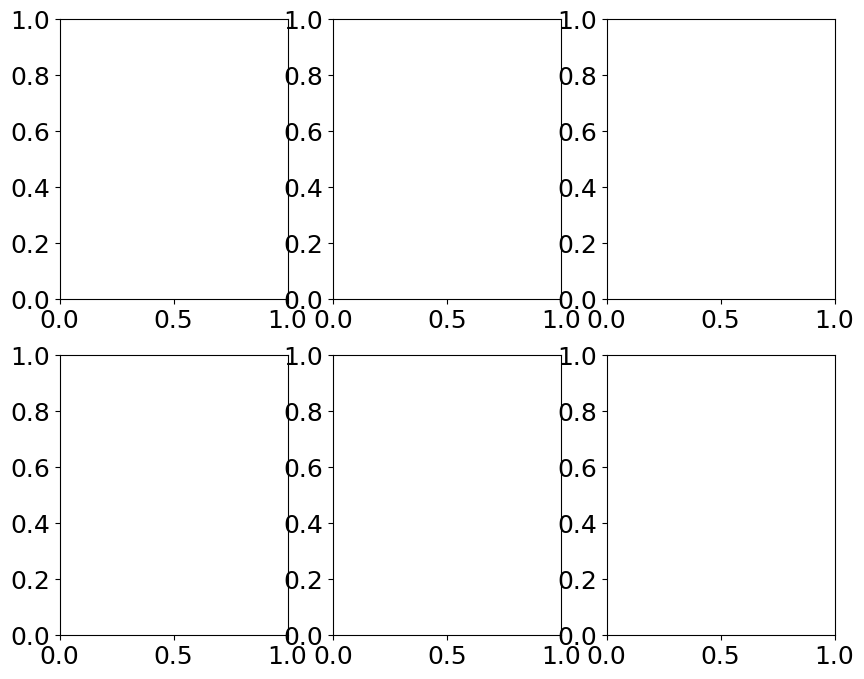

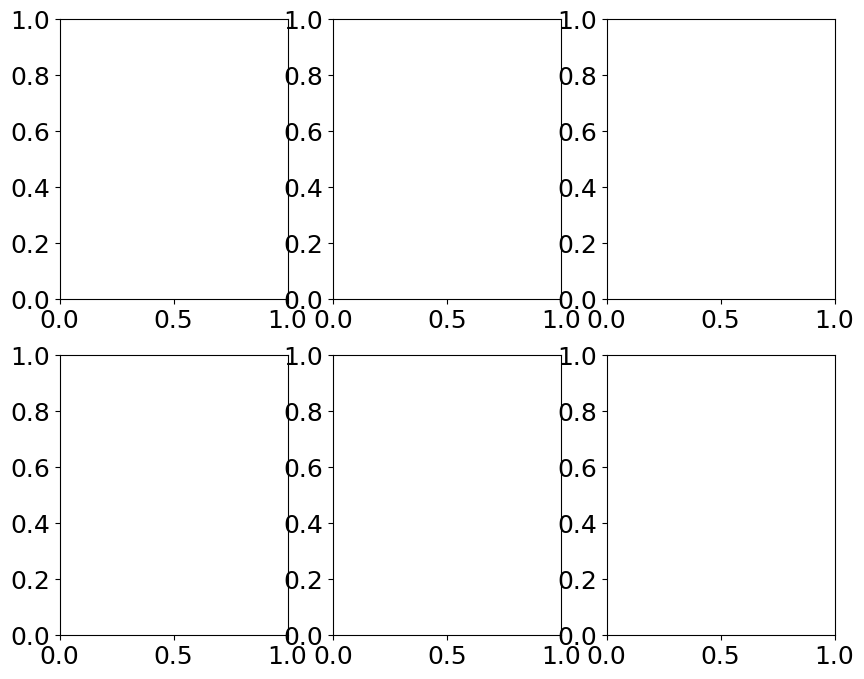

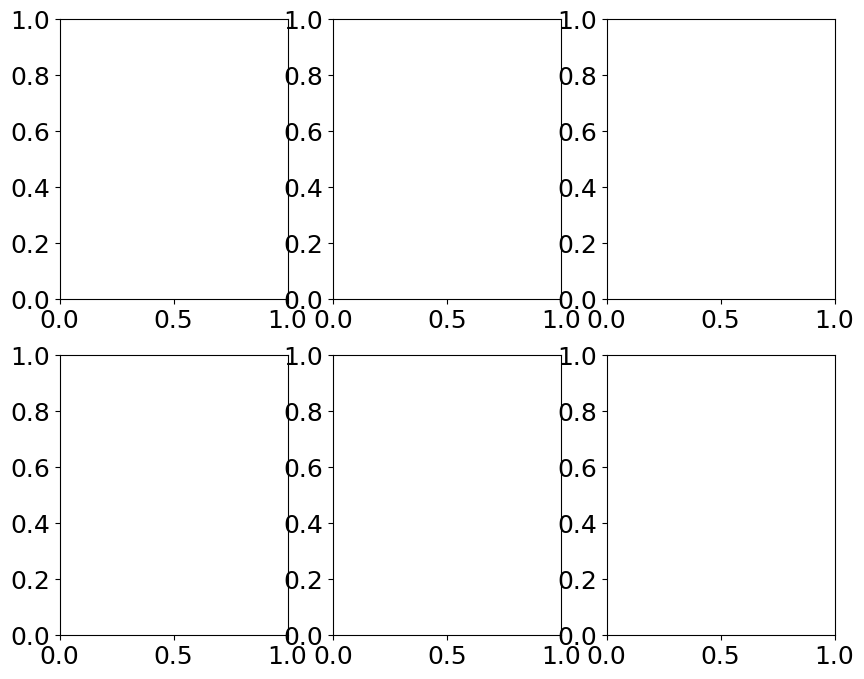

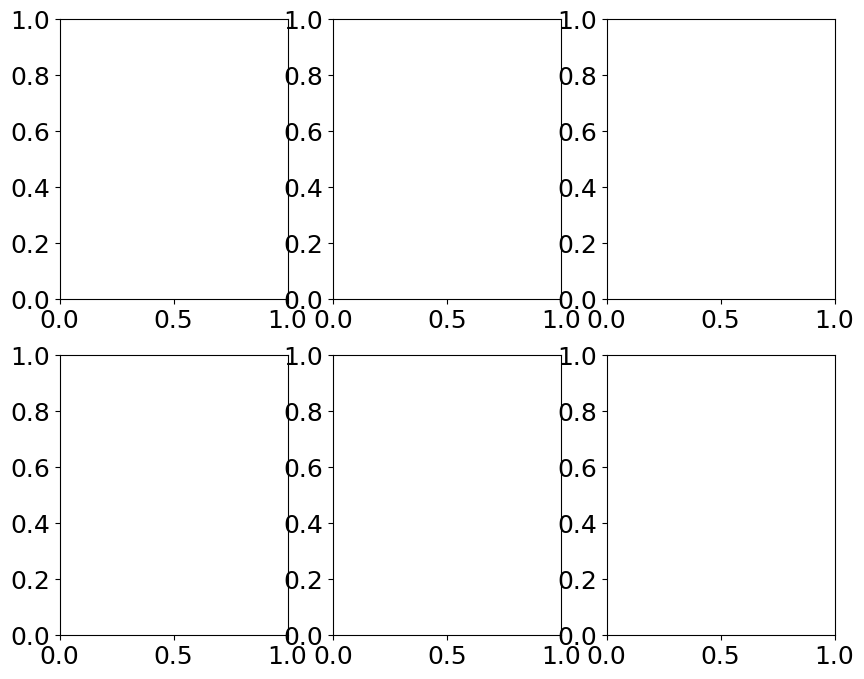

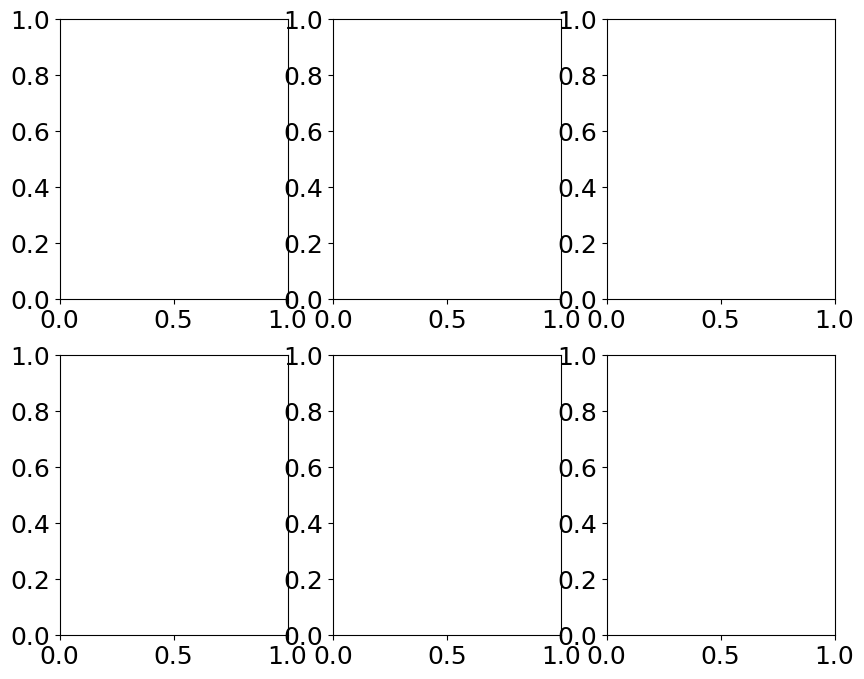

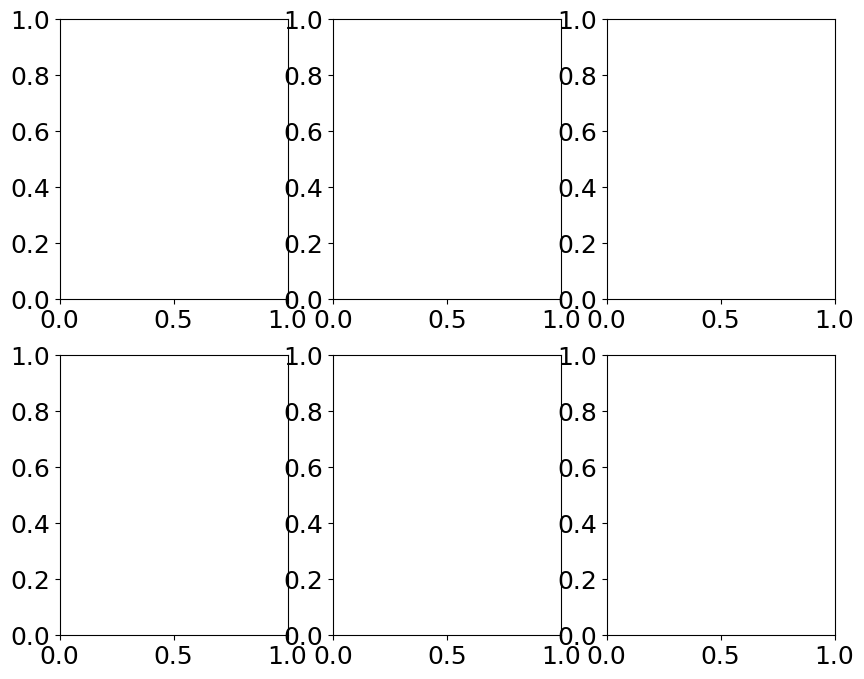

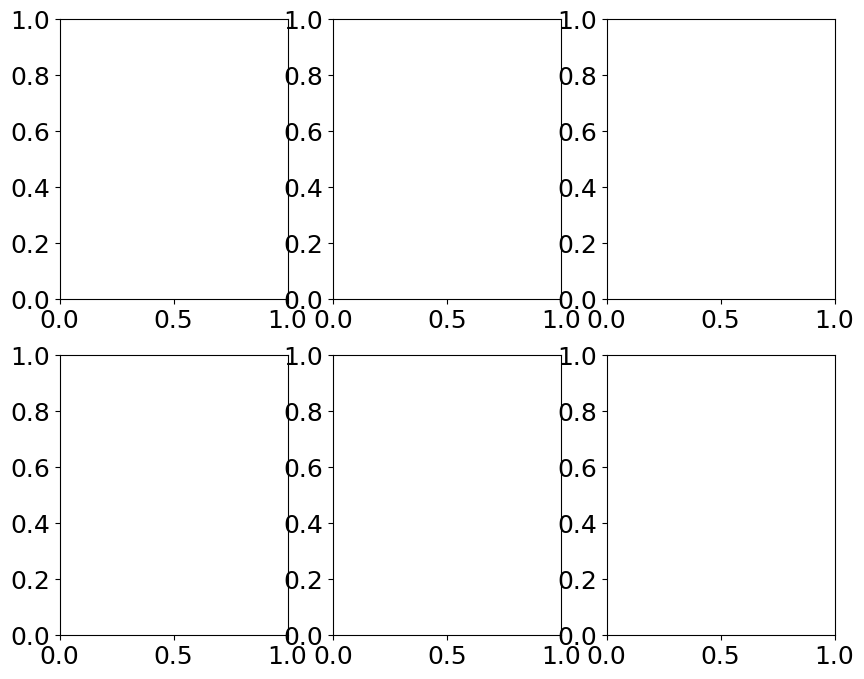

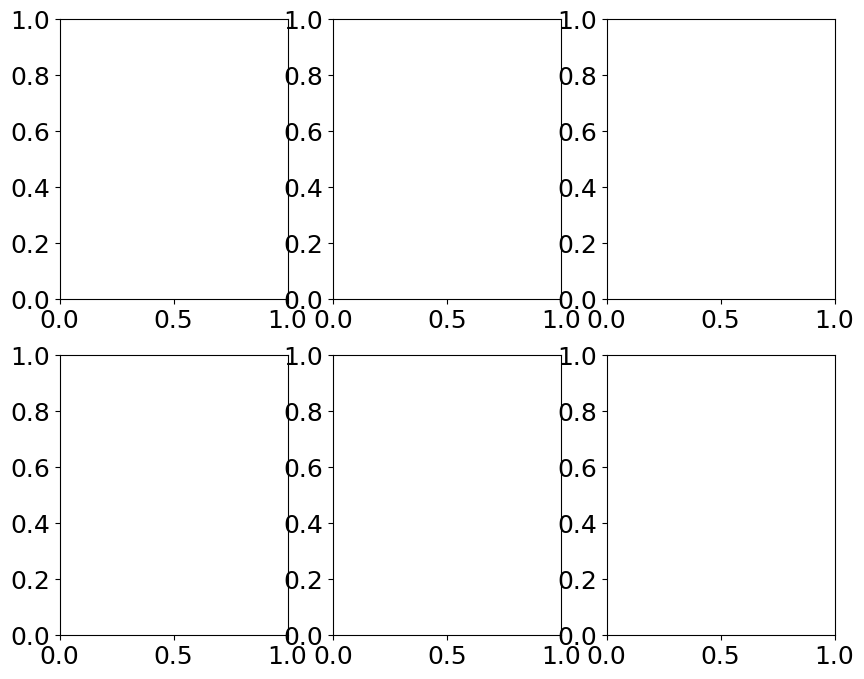

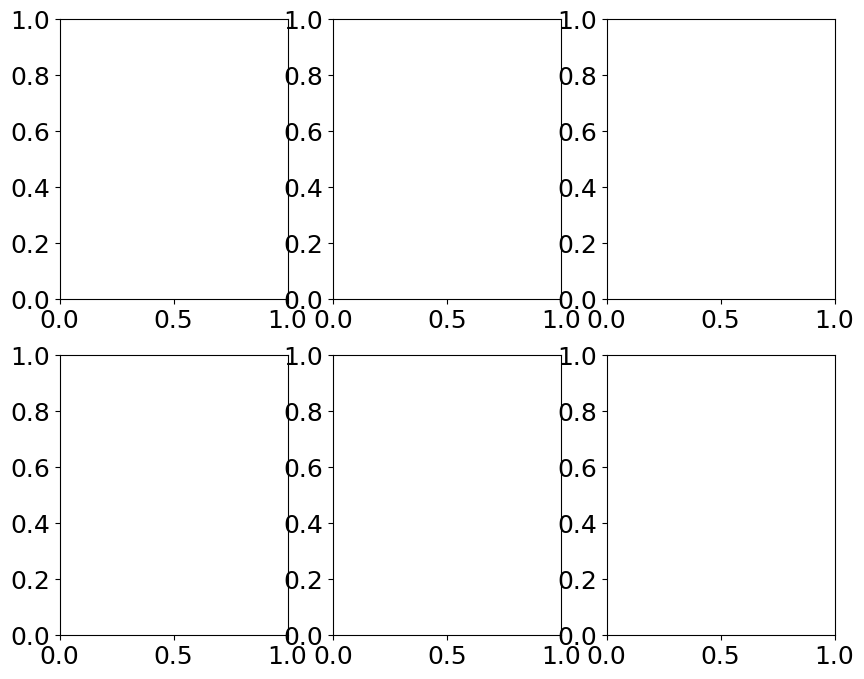

In [16]:
loss_list = {}
loss_list['recon_loss'] = []
#loss_list['sindy_loss_x'] =[]
loss_list['sindy_loss_ddx'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []
loss_val_list = []

# aqui declaramos vários "experimentos" pois nem sempre a rede converge para o modelo certo
experiment =0

model = Autoencoder(params).to(device)
print('-'*50)


best_loss = float('inf')  # Initialize with infinity
for epoch in tqdm(range(1,epochs)):
    train_step(loss_list)
    validation_step(loss_val_list)
    
    current_loss = loss_list['tot'][-1]  # Get latest total loss
    if current_loss < best_loss:
        best_loss = current_loss
        #print(f'\nNew best loss: {best_loss:.6f} at epoch {epoch}')
        #print_loss(epoch, loss_rate, loss_list)
        save_model(epoch, experiment)
        sequential_threshold(epoch, seq_thres)
        plot_validation_comparison(epoch, val_print_rate)
        
data = pd.DataFrame.from_dict(loss_list)
data.to_csv('./saved_loss/' + 'loss'+'.csv')


## Avaliação dos resultados

* Aqui vamos printar algumas imagens do nosso conjunto de validação e verificar a qualidade do output com relação a imagens que a rede nunca viu durante o treinamento

C:\Users\gubio\AppData\Local\Temp\ipykernel_4064\1709310507.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


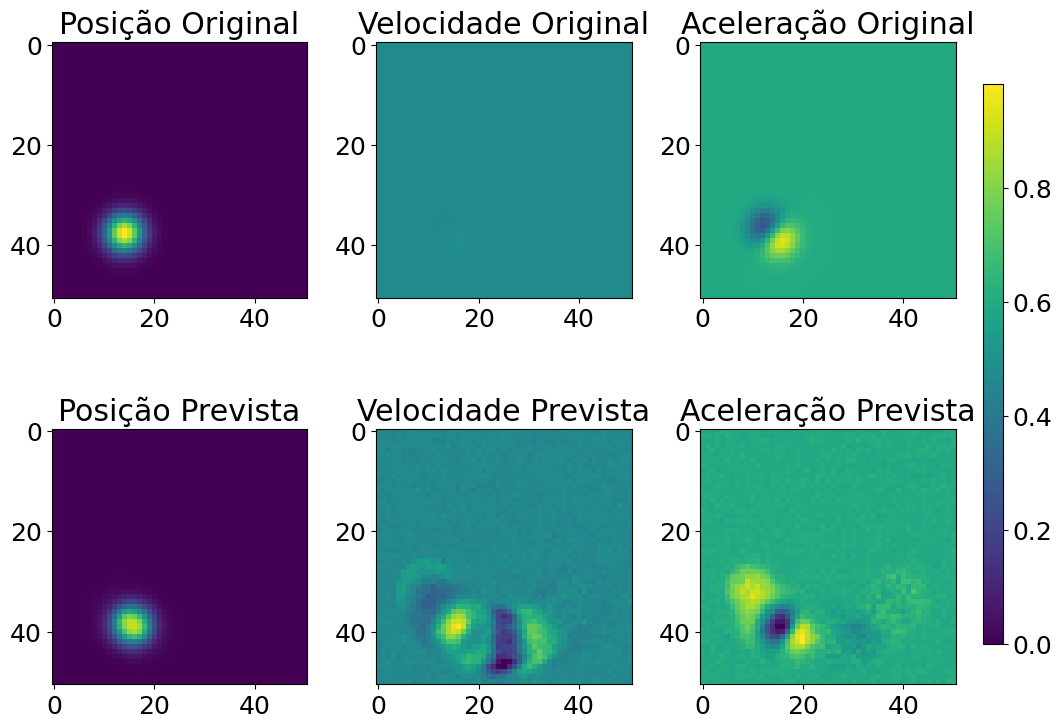

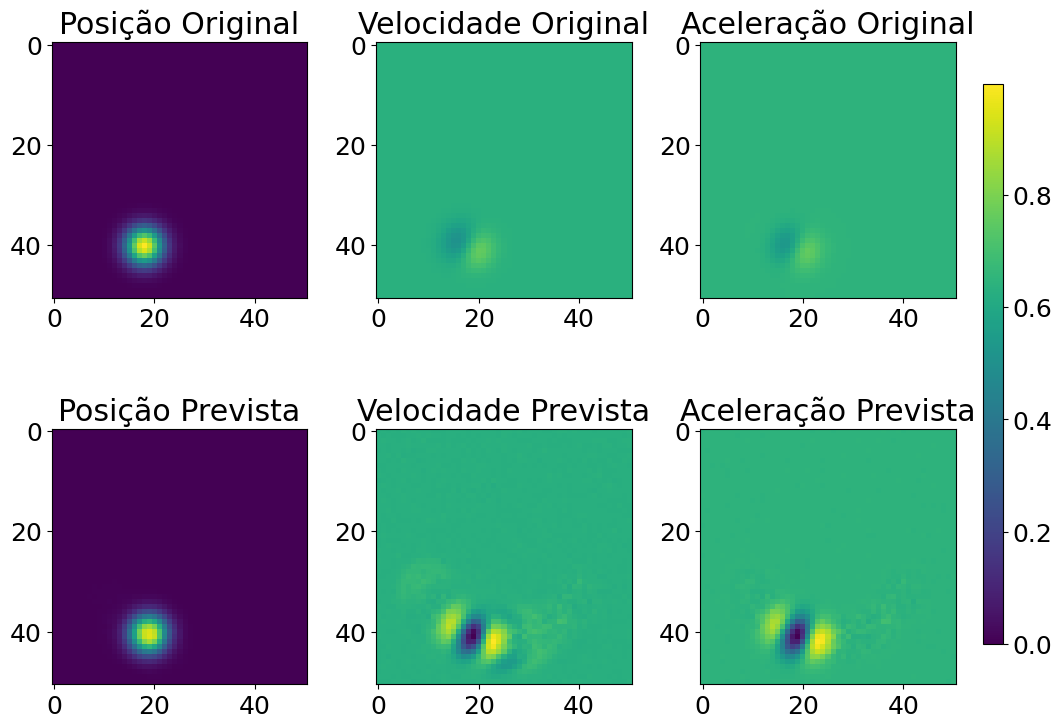

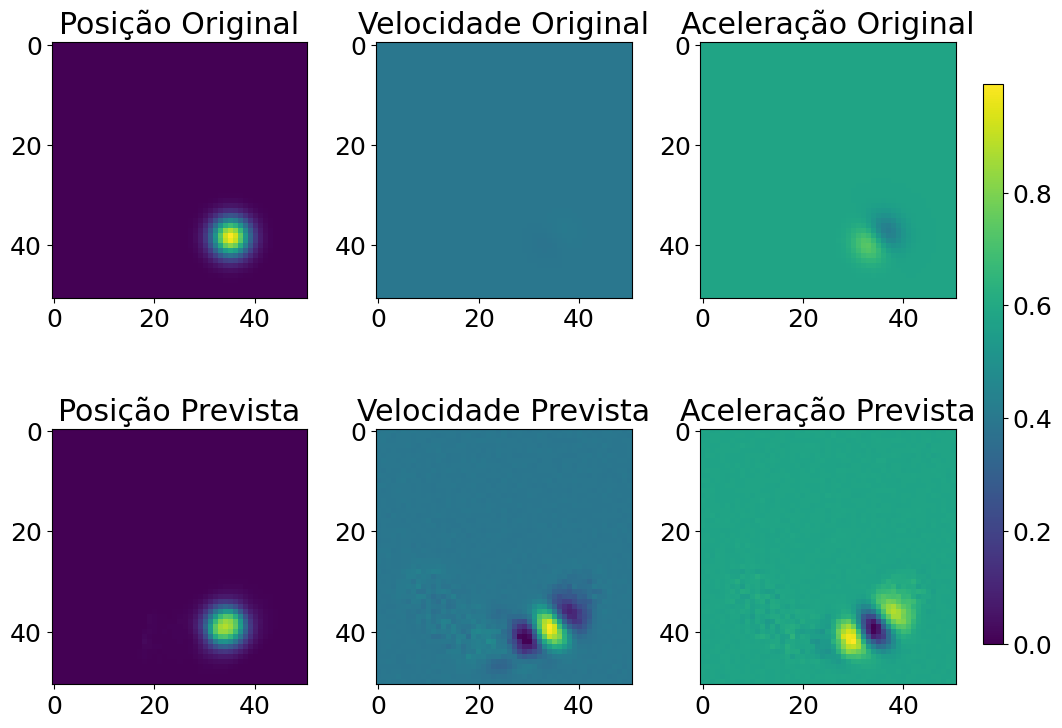

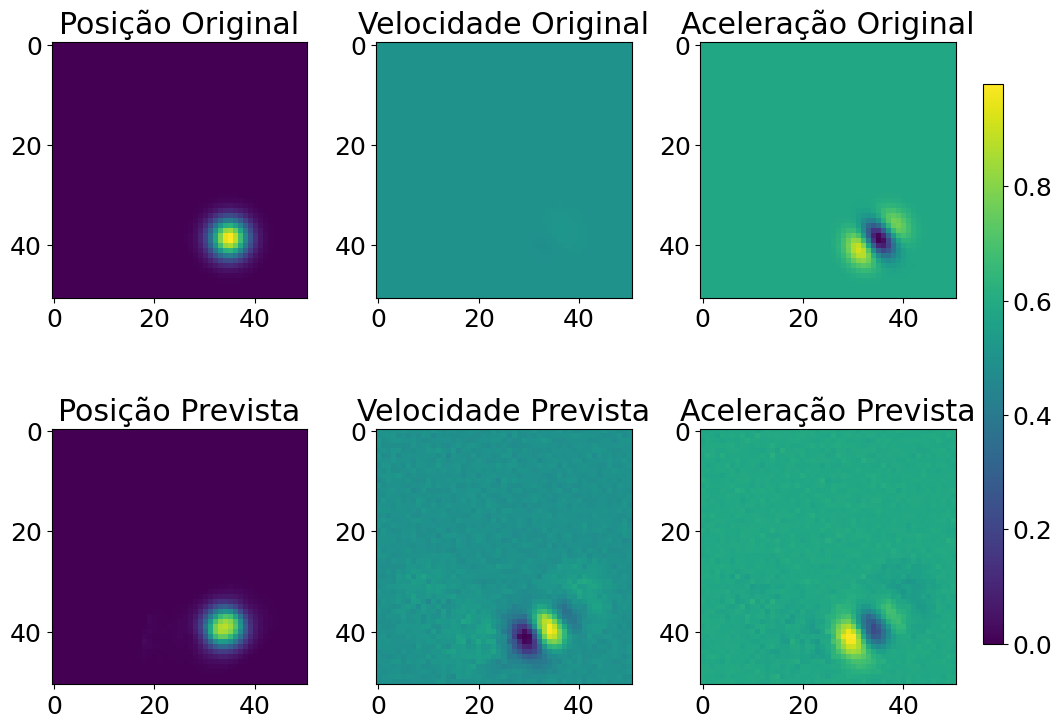

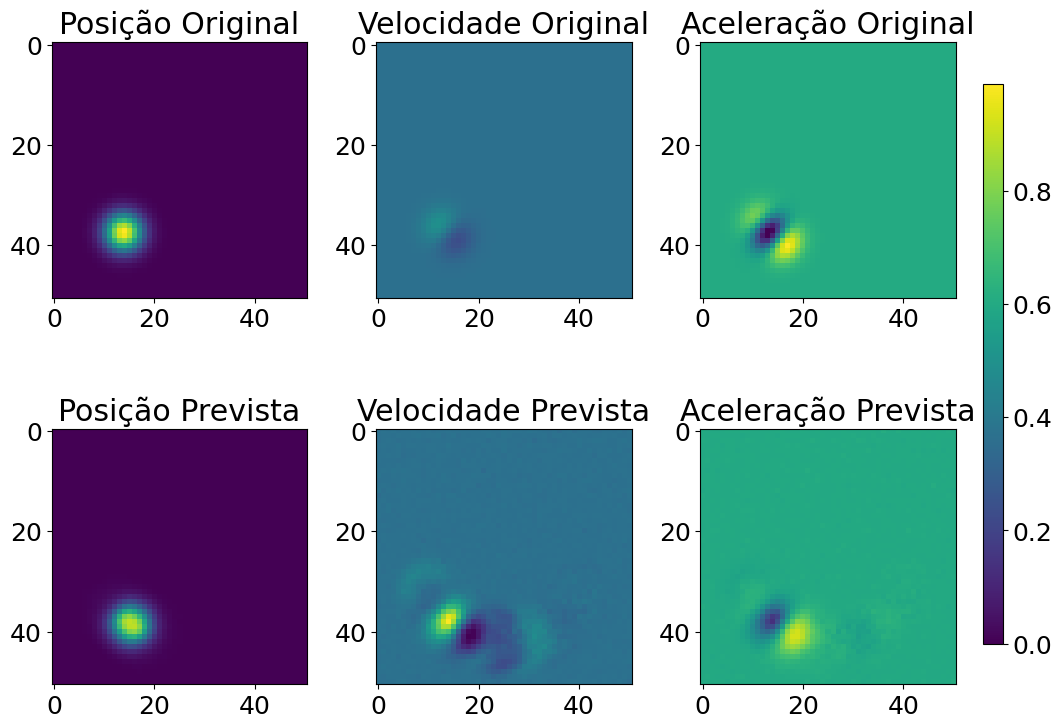

In [17]:
X_p, dX_p,ddX_p= validation_data['x'], validation_data['dx'], validation_data['ddx']#, validation_data['z'], validation_data['dz']

for time in range(0,2001, 500): #time = 1500

    X_pred, dX_pred, ddX_pred, _, _, _,scindy_predict = model(X_val,dX_val, ddX_val)
    X_pred = X_pred.cpu().detach().numpy()
    dX_pred = dX_pred.cpu().detach().numpy()
    ddX_pred = ddX_pred.cpu().detach().numpy()

    #print('\n Model is now:')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    latent_dim = params['latent_dim']

    fig, axs = plt.subplots(2, 3, figsize=(10, 8))  # Increased figure size

    # Set font sizes
    plt.rcParams.update({'font.size': 18})
    
    # Plot with consistent colorbar range
    vmin_x = min(X_p[time].min(), X_pred[time].min())
    vmax_x = max(X_p[time].max(), X_pred[time].max())
    
    vmin_dx = min(dX_p[time].min(), dX_pred[time].min())
    vmax_dx = max(dX_p[time].max(), dX_pred[time].max())
    
    vmin_ddx = min(ddX_p[time].min(), ddX_pred[time].min())
    vmax_ddx = max(ddX_p[time].max(), ddX_pred[time].max())

    # Plot the subplots
    im1 = axs[0,0].imshow(X_p[time].reshape(51,51), vmin=vmin_x, vmax=vmax_x)
    axs[0,0].set_title('Posição Original')
    
    im2 = axs[0,1].imshow(dX_p[time].reshape(51,51), vmin=vmin_dx, vmax=vmax_dx)
    axs[0,1].set_title('Velocidade Original')
    
    im3 = axs[0,2].imshow(ddX_p[time].reshape(51,51), vmin=vmin_ddx, vmax=vmax_ddx)
    axs[0,2].set_title('Aceleração Original')
    
    im4 = axs[1,0].imshow(X_pred[time].reshape(51,51), vmin=vmin_x, vmax=vmax_x)
    axs[1,0].set_title('Posição Prevista')
    
    im5 = axs[1,1].imshow(dX_pred[time].reshape(51,51), vmin=vmin_dx, vmax=vmax_dx)
    axs[1,1].set_title('Velocidade Prevista')
    
    im6 = axs[1,2].imshow(ddX_pred[time].reshape(51,51), vmin=vmin_ddx, vmax=vmax_ddx)
    axs[1,2].set_title('Aceleração Prevista')

    # Add single colorbar
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)

    plt.tight_layout()
    plt.show()

# Avaliação da função loss
* Veja que temos muitos termos na nossa loss function.
\begin{equation}
    \mathcal{L}_{\text{SINDy}} = \mathcal{L}_{\text{recon}} + \lambda_1\mathcal{L}_{\dot{x}} + \lambda_2\mathcal{L}_{\dot{z}} + \lambda_3||\boldsymbol{\Xi}||_1
\end{equation}

Onde 
\begin{equation}
    \mathcal{L}_{\text{recon}} = || \mathbf{x} - \psi \circ \varphi (\mathbf{x})||^2_2,
\end{equation}

A reconstrução da segunda derivada da imagem em termos de $z$

\begin{equation}
    \mathcal{L}_{\dot{\mathbf{x}}} = ||\ddot{\mathbf{x}} - \nabla_z^2 \psi (z) \dot{z} + \nabla_z \psi(z) \boldsymbol{\Theta}(z) \boldsymbol{\Xi} ||^2_2,
\end{equation}

\begin{equation}
   \quad \qquad \qquad = ||\ddot{\mathbf{x}} - \nabla_z^2 \psi (z) \nabla_x \varphi(\mathbf{x})\dot{\mathbf{x}} + \nabla_z \psi(z) \boldsymbol{\Theta}(z) \boldsymbol{\Xi} ||^2_2,
\end{equation}

E finalmente o termo relativo a segunda derivada do modelo gerado para $z$

\begin{equation}
    \mathcal{L}_{\dot{z}} =  || \nabla_x^2 \varphi (\mathbf{x}) \dot{\mathbf{x}}^2 + \nabla_x \varphi (\mathbf{x}) \ddot{\mathbf{x}} -  \boldsymbol{\Theta}(z(t))\boldsymbol{\Xi} ||^2_2.
\end{equation}

In [18]:
def load_model():
    '''loads model from a .pt file'''

    checkpoint = tc.load('C:/Users/gubio/OneDrive/Desktop/Gubio/Notebooks_NN_Physics/SINDyAutoencoder/saved_models/best_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = model.configure_optimizers()
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = pd.read_csv('C:/Users/gubio/OneDrive/Desktop/Gubio/Notebooks_NN_Physics/SINDyAutoencoder/saved_loss/loss.csv')
    model.XI = checkpoint['sindy_coefficients']
    model.XI_coefficient_mask = checkpoint['coefficient_mask']
    
    return model, optimizer, epoch, loss

model,_,epoca,loss = load_model()

C:\Users\gubio\AppData\Local\Temp\ipykernel_4064\3350805483.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tc.load('C:/Users/gubio/OneDrive/Desktop/Gubio/N

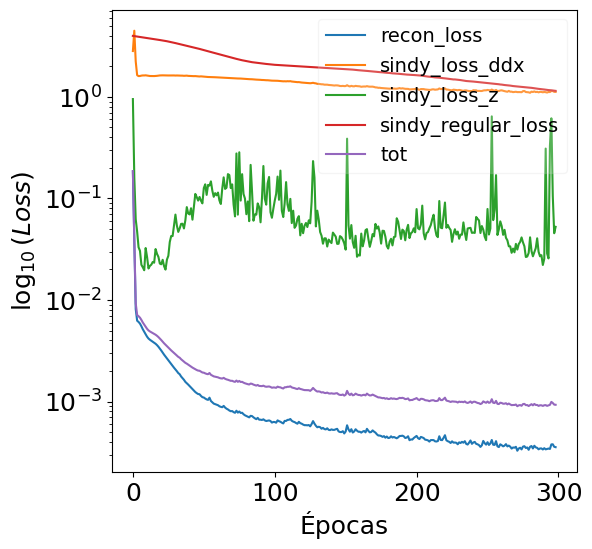

In [19]:

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 18}) 
# Plot each column in the DataFrame
for column in loss.columns[1:]:  # Skip the first column which is 'Unnamed: 0'
    plt.plot(loss[column], label=column)

# Add labels and legend
plt.ylabel('Loss')
plt.yscale('log')  
plt.legend(loc='upper right', fontsize=14, framealpha=0.2)
ax.set_xlabel('Épocas')
ax.set_ylabel('$\log_{10}(Loss)$')

plt.show()